## Final Model -- Facial Keypoint Prediction

In this notebook, we walk through a model from the tutorial referenced by the official Kaggle competition website. It was constructed by Daniel Nouri. We will use this model as the baseline of our final project.

### 0. Fire up Neural Nets Libraries

In [1]:
import os
import numpy as np
from pandas.io.parsers import read_csv
from pandas import DataFrame
from sklearn.utils import shuffle

import theano
from nolearn.lasagne import NeuralNet, TrainSplit
# nerual net layers definition
from lasagne import layers
# common gradient descent method
from lasagne.updates import nesterov_momentum
# for transforming images stochastically per batch on the fly
from nolearn.lasagne import BatchIterator

# for evaluating training time
from time import time
from datetime import datetime
# for storing and loading the trained models
import pickle

# for plotting images
import matplotlib.pyplot as plt
# for evaluating MSE
from sklearn.metrics import mean_squared_error

# Increase Python's recursion limit because the neural net model is large enough
import sys
sys.setrecursionlimit(10000)

from collections import OrderedDict
from sklearn.base import clone

try:
    from lasagne.layers.cuda_convnet import Conv2DCCLayer as Conv2DLayer
    from lasagne.layers.cuda_convnet import MaxPool2DCCLayer as MaxPool2DLayer
except ImportError:
    Conv2DLayer = layers.Conv2DLayer
    MaxPool2DLayer = layers.MaxPool2DLayer

import scipy.misc
from scipy.ndimage import imread
import cv2

%matplotlib inline    

np.random.seed(42)

WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: GRID K520 (CNMeM is disabled, cuDNN 5110)
/usr/local/lib/python3.5/dist-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


### 1. Data Path

We will further split the provided training data into our training set and development set in step 4.

In [2]:
FTRAIN = '~/data/training.csv'
FTEST = '~/data/test.csv'
FLOOKUP = '~/data/IdLookupTable.csv'

IDXTRAIN = 'train_indices.txt'
IDXDEV = 'dev_indices.txt'

### 2. View Raw Data

In [3]:
# Each row of our data refers to one face. 
# The first 30 columns refers to the labels of different facial keypoints. 
# A feature vector in the last column store pixel values of the facial image.

read_csv(FTRAIN).head(1)

left_eye_center_x  left_eye_center_y  right_eye_center_x  \
0          66.033564          39.002274           30.227008   

   right_eye_center_y  left_eye_inner_corner_x  left_eye_inner_corner_y  \
0           36.421678                59.582075                39.647423   

   left_eye_outer_corner_x  left_eye_outer_corner_y  right_eye_inner_corner_x  \
0                73.130346                39.969997                 36.356571   

   right_eye_inner_corner_y  \
0                 37.389402   

                         ...                          nose_tip_y  \
0                        ...                           57.066803   

   mouth_left_corner_x  mouth_left_corner_y  mouth_right_corner_x  \
0            61.195308            79.970165             28.614496   

   mouth_right_corner_y  mouth_center_top_lip_x  mouth_center_top_lip_y  \
0             77.388992               43.312602               72.935459   

   mouth_center_bottom_lip_x  mouth_center_bottom_lip_y  \
0                  43.130707                  84.485774   

                                               Image  
0  238 236 237 238 240 240 239 241 241 243 240 23...  

[1 rows x 31 columns]

In [4]:
# Testing data has no targets available
read_csv(FTEST).head(1)

ImageId                                              Image
0        1  182 183 182 182 180 180 176 169 156 137 124 10...

### 3. Transforming Data

In [5]:
# Write function to load the data
# Normalize the target -- coordinates : current grid 96by96
# Normalize the features -- pixels : current range 255

# choose use=['test','dev','complete_train','incomplete_train']
def load(use='complete_train', cols = None):
    """Loads data from FTEST if *test* is True, otherwise from FTRAIN. 
    Pass a list of *cols* if you're only interested in a subset of the target columns"""
    
    if use not in ['test','dev','complete_train','incomplete_train']:
        raise Exception("Not a valid input, use=['test','dev','complete_train','incomplete_train'] ")
    
    fname = FTEST if use == 'test' else FTRAIN
  
    df = read_csv(os.path.expanduser(fname)) #Load pandas dataframe
    
    if use == "dev":
        load_idx = [int(line.rstrip('\n')) for line in open(IDXDEV)]
        df = df.loc[load_idx]
    elif use == "complete_train":    
        load_idx = [int(line.rstrip('\n')) for line in open(IDXTRAIN)]
        df = df.loc[load_idx]
    elif use == "incomplete_train":
        bad_idx = [int(line.rstrip('\n')) for line in open(IDXDEV)]
        df = df.drop(bad_idx)
    
    # The Image column has pixel values separated by space
    # convert these values to numpy arrays:
    df['Image'] = df['Image'].apply(lambda im: np.fromstring(im, sep = ' '))
    
    if cols: # can selectively load some targets by specifying them in the cols argument
        df = df[list(cols) + ['Image']]
        
    #print(df.count()) # prints the number of values for each column
    if use in ['test','dev','complete_train']:
        df = df.dropna()
        
        # make feature matrix X
        # first convert pixel values from pandas 1D series to numpy 2D array
        # normalize pixel valuaes
        X = np.vstack(df['Image'].values)/255. # scale pixel values to [0,1]
        X = X.astype(np.float32) # make sure numeric val are float32
        # X is numpy.ndarray, shape (2140, 9216) == 2140 examples, 96 grid * 96 grid

        # Loading the 30 labels(targets)(keypoints) y for each face into an array
        if not use == "test": # only training examples have target columns

            y = df[df.columns[:-1]].values #last column is X, we want the y targets here
            # y is numpy.ndarray, shape(2140, 30) -- 7049 examples, 30 targets each

            y = (y - 48) / 48 # scale target coordinates to [-1.1] (currently 96 by 96)
            X, y = shuffle(X, y, random_state = 42) #shuffle training data
            y = y.astype(np.float32)

        else:
            y = None # development data has no targets available

        return X,y,df.index
    
    elif use == 'incomplete_train':
        df = df.dropna()
        X = np.vstack(df['Image'].values)/255.
        X = X.astype(np.float32)
        y = df[df.columns[:-1]].values
        y = (y - 48) / 48
        X, y = shuffle(X, y, random_state = 42)
        y = y.astype(np.float32)
        return X,y,df.index

In [6]:
# When using convolutional layers in Lasagne, we have to prepare the input data such 
# that each sample is no longer a flat vector of 9,216 pixel intensities, 
# but a three-dimensional matrix with shape (c, 0, 1), where c is the number of channels (colors), 
# and 0 and 1 correspond to the x and y dimensions of the input image. In our case, 
# the concrete shape will be (1, 96, 96), because we're dealing with a single (gray) color 
# channel only.

def load2d(use='complete_train', cols = None):
    X, y, idx = load(use=use, cols = cols)
    X = X.reshape(-1, 1, 96, 96)
    return X, y, idx

### 4. Loading training data

In [7]:
def plot_sample(x, y, axis):
    img = x.reshape(96, 96)
    axis.imshow(img, cmap = 'gray')
    axis.scatter(y[0::2]*48+48, y[1::2]*48+48, marker='x', s=10)

In [8]:
# choose use=['test','dev','complete_train','incomplete_train']
X_dev, y_dev, idx_dev = load2d(use='dev', cols=None)
print (len(idx_dev))

200


In [9]:
# choose use=['test','dev','complete_train','incomplete_train']
X_train_complete, y_train_complete, idx_train_complete = load2d(use='complete_train', cols=None)
print (len(idx_train_complete))

1940


In [10]:
# choose use=['test','dev','complete_train','incomplete_train']
X_train_incomplete, y_train_incomplete, idx_train_incomplete = load2d(use='incomplete_train', cols=None)
print (len(idx_train_incomplete))

1940


In [14]:
mini_idx = np.random.random_integers(500, size=(50))
X_mini = X_train_incomplete[mini_idx]
y_mini = y_train_incomplete[mini_idx]

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: This function is deprecated. Please call randint(1, 500 + 1) instead
  """Entry point for launching an IPython kernel.


### 5. Data Augmentation

### 5.1 Flipping half of the image on the fly

In [11]:
flip_indices = [
    (0, 2), (1, 3),
    (4, 8), (5, 9), (6, 10), (7, 11),
    (12, 16), (13, 17), (14, 18), (15, 19),
    (22, 24), (23, 25),
    ]

# Let's see if we got it right:
df = read_csv(os.path.expanduser(FTRAIN))
for i, j in flip_indices:
    print("# {} -> {}".format(df.columns[i], df.columns[j]))

# left_eye_center_x -> right_eye_center_x
# left_eye_center_y -> right_eye_center_y
# left_eye_inner_corner_x -> right_eye_inner_corner_x
# left_eye_inner_corner_y -> right_eye_inner_corner_y
# left_eye_outer_corner_x -> right_eye_outer_corner_x
# left_eye_outer_corner_y -> right_eye_outer_corner_y
# left_eyebrow_inner_end_x -> right_eyebrow_inner_end_x
# left_eyebrow_inner_end_y -> right_eyebrow_inner_end_y
# left_eyebrow_outer_end_x -> right_eyebrow_outer_end_x
# left_eyebrow_outer_end_y -> right_eyebrow_outer_end_y
# mouth_left_corner_x -> mouth_right_corner_x
# mouth_left_corner_y -> mouth_right_corner_y


In [12]:
class FlipBatchIterator(BatchIterator):
    flip_indices = [
        (0, 2), (1, 3),
        (4, 8), (5, 9), (6, 10), (7, 11),
        (12, 16), (13, 17), (14, 18), (15, 19),
        (22, 24), (23, 25),
        ]

    def transform(self, Xb, yb):
        Xb, yb = super(FlipBatchIterator, self).transform(Xb, yb)

        # Flip half of the images in this batch at random:
        bs = Xb.shape[0] #number of examples
        indices = np.random.choice(bs, bs // 2, replace=False) #choose half of them randomly
        Xb[indices] = Xb[indices, :, :, ::-1] #flip these guys randomly

        if yb is not None:
            # Horizontal flip of all x coordinates:
            yb[indices, ::2] = yb[indices, ::2] * -1

            # Swap places, e.g. left_eye_center_x -> right_eye_center_x
            for a, b in self.flip_indices:
                yb[indices, a], yb[indices, b] = (
                    yb[indices, b], yb[indices, a])

        return Xb, yb

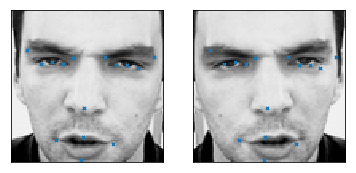

In [15]:
X_flipped = X_mini[:,:,:,::-1]

# plot two images!
fig = plt.figure(figsize = (6,3))
ax = fig.add_subplot(1,2,1,xticks=[],yticks=[])
plot_sample(X_mini[1],y_mini[1],ax)
ax = fig.add_subplot(1,2,2,xticks=[],yticks=[])
plot_sample(X_flipped[1], y_mini[1], ax)
plt.show()

### 5.2 Adaptive filter transformation 9x9 or 3x3

In [16]:
#Applying an adaptive filter (considers a 9x9 grid of neighbors)
#can mess with the 9 as a parameter

# input 
# neighborhood = ["9by9","3by3"]
def render(img, neighborhood = "9by9"):
    im = scipy.misc.toimage(img.reshape(96,96))
    im.save("foobar.png")
    src = cv2.imread("foobar.png", 0)
    n = 9 if neighborhood == "9by9" else 3
    img_edge = cv2.adaptiveThreshold(src,255,cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, n, 2)
    return(img_edge)

def adaptive_filter_transform(X_loaded, neighborhood = "9by9"):
    df_train_trans = np.empty([len(X_loaded), 9216])
    for i in range(0,len(X_loaded)):
        img = X_loaded[[i]]
        result = render(img, neighborhood = neighborhood)
        df_train_trans[i] = result.reshape(1,9216)/255
    return df_train_trans.reshape(-1, 1, 96, 96)

In [17]:
# TESTING
trans_filter = adaptive_filter_transform(X_mini, neighborhood = "3by3")
trans_filter.shape

(50, 1, 96, 96)

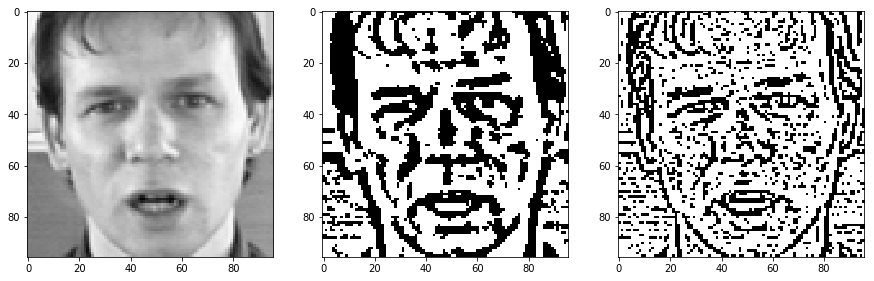

In [18]:
demo_adaptive_filter_img = X_mini[27].reshape(96,96)
demo_9by9_img_o = X_mini[27].reshape(96,96)
demo_9by9_result = render(demo_9by9_img_o)

#check transformation
demo_3by3_result_func = trans_filter[27].reshape(96,96)

#compare the results visually
fig = plt.figure(figsize=(15, 15))
fig.add_subplot(1,3,1).imshow(demo_adaptive_filter_img,cmap='gray')
fig.add_subplot(1,3,2).imshow(demo_9by9_result,cmap='gray')
fig.add_subplot(1,3,3).imshow(demo_3by3_result_func,cmap='gray')

### 5.4 Adjust b&w contrast of image

In [19]:
# f is a contrast factor: 1/f addition or subtraction if higher or lower than area mean (1 pixel in all directions)
# resulting patter looks like fingerprint contours on image

# input X_mini[1](1, 96, 96)
# output (9216,)
def contrast_b(img,f):
    
    Arr = np.reshape(img,(96,96)) # creates np 96x96 array to work with 
    Arr_out=np.zeros((96,96))   # blank array to fill in values
    
    for i in range(1,95):  # scan X columns, stay in bounds, dont care about edges (sorry)
        for j in range(1,95):  #scan Y rows, stay in bounds
            area=[]                        # blank list for area pixel vals
            for rows in range(-1,2):        # row cycle 
                for cols in range(-1,2):      # col cycle
                    area.append(Arr[i+rows,j+cols])      #keep appending area list with vals
            if np.mean(area)< Arr[i,j]:
                Arr_out[i,j]= Arr[i,j] + (1-Arr[i,j])/f
            else:
                Arr_out[i,j]= Arr[i,j] - (1-Arr[i,j])/f

    return np.ravel(Arr_out).reshape(96,96)


def contrast_transform(X_loaded, f=4):
    
    df_train_trans = np.empty([len(X_loaded), 9216])
    
    for i in range(0,len(X_loaded)):
        img = X_loaded[[i]]
        result = contrast_b(img,f=f)
        df_train_trans[i] = result.reshape(1,9216)/255
        
    return df_train_trans.reshape(-1, 1, 96, 96)

In [20]:
# TESTING
trans_contrast = contrast_transform(X_mini, f=10)
trans_contrast.shape

(50, 1, 96, 96)

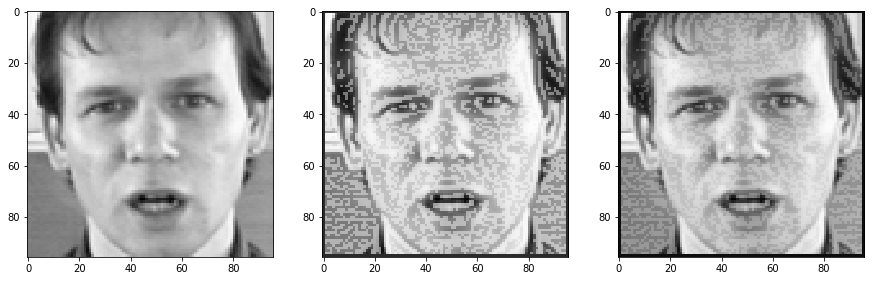

In [21]:
demo_contrast_img = X_mini[27].reshape(96,96)
demo_contrast_img_o = X_mini[27].reshape(96,96)
demo_contrast_result = contrast_b(demo_contrast_img_o,4)

#check transformation
demo_contrast_result_func = trans_contrast[27].reshape(96,96)

#compare the results visually
fig = plt.figure(figsize=(15, 15))
fig.add_subplot(1,3,1).imshow(demo_contrast_img,cmap='gray')
fig.add_subplot(1,3,2).imshow(demo_contrast_result,cmap='gray')
fig.add_subplot(1,3,3).imshow(demo_contrast_result_func,cmap='gray')

### 6. Adjust Variable -- function to update parameters such as learning rate and moment with epochs 

In [22]:
def float32(k):
    return np.cast['float32'](k)

In [23]:
class AdjustVariable(object):
    def __init__(self, name, start=0.03, stop=0.001):
        self.name = name
        self.start, self.stop = start, stop
        self.ls = None

    def __call__(self, nn, train_history):
        if self.ls is None:
            self.ls = np.linspace(self.start, self.stop, nn.max_epochs)

        epoch = train_history[-1]['epoch']
        new_value = float32(self.ls[epoch - 1])
        getattr(nn, self.name).set_value(new_value)

### 7. Early Stopping -- doesn't have to run max epochs once validation loss stablizes 

In [24]:
class EarlyStopping(object):
    def __init__(self, patience=100):
        self.patience = patience
        self.best_valid = np.inf
        self.best_valid_epoch = 0
        self.best_weights = None

    def __call__(self, nn, train_history):
        current_valid = train_history[-1]['valid_loss']
        current_epoch = train_history[-1]['epoch']
        if current_valid < self.best_valid:
            self.best_valid = current_valid
            self.best_valid_epoch = current_epoch
            self.best_weights = nn.get_all_params_values()
        elif self.best_valid_epoch + self.patience < current_epoch:
            print("Early stopping.")
            print("Best valid loss was {:.6f} at epoch {}.".format(
                self.best_valid, self.best_valid_epoch))
            nn.load_params_from(self.best_weights)
            raise StopIteration()

### 8. Convolutional Neural Net Specification

In [46]:
net12 = NeuralNet(
    layers=[
        ('input', layers.InputLayer),
        ('conv1', Conv2DLayer),
        ('pool1', MaxPool2DLayer),
        ('dropout1', layers.DropoutLayer),
        ('conv2', Conv2DLayer),
        ('pool2', MaxPool2DLayer),
        ('dropout2', layers.DropoutLayer),
        ('conv3', Conv2DLayer),
        ('pool3', MaxPool2DLayer),
        ('dropout3', layers.DropoutLayer),
        ('hidden4', layers.DenseLayer),
        ('dropout4', layers.DropoutLayer),
        ('hidden5', layers.DenseLayer),
        ('output', layers.DenseLayer),
        ],
    input_shape=(None, 1, 96, 96),
    conv1_num_filters=32, conv1_filter_size=(3, 3), pool1_pool_size=(2, 2),
    dropout1_p=0.1,
    conv2_num_filters=64, conv2_filter_size=(2, 2), pool2_pool_size=(2, 2),
    dropout2_p=0.2,
    conv3_num_filters=128, conv3_filter_size=(2, 2), pool3_pool_size=(2, 2),
    dropout3_p=0.3,
    hidden4_num_units=1000,
    dropout4_p=0.5,
    hidden5_num_units=1000,
    output_num_units=30, output_nonlinearity=None,

    update_learning_rate=theano.shared(float32(0.03)),    update_momentum=theano.shared(float32(0.9)),

    regression=True,
    batch_iterator_train=FlipBatchIterator(batch_size=128),
    on_epoch_finished=[
        AdjustVariable('update_learning_rate', start=0.03, stop=0.0001),
        AdjustVariable('update_momentum', start=0.9, stop=0.999),
        EarlyStopping(patience=200),
        ],
    max_epochs=10000,
    verbose=1,
    )

### 9. Train and store the model

In [ ]:
time0 = time()
net12.fit(X_train, y_train)
print(time()-time0)


with open('net12.pickle', 'wb') as f:
    pickle.dump(net12, f, -1)

### 9.5 Load the Pickle 
(if net is train already)

In [12]:
fname_pretrain = 'net12.pickle'
with open(fname_pretrain, 'rb') as f:  # !
    net_pretrain = pickle.load(f)

In [16]:
net_pretrain.save_params_to('net_pretrain_saved_params.txt')

### 9.6 Create Specialists Dictionary

In [25]:
SPECIALIST_SETTINGS = [
    dict(
        columns=(
            'left_eye_center_x', 'left_eye_center_y',
            'right_eye_center_x', 'right_eye_center_y',
            ),
        flip_indices=((0, 2), (1, 3)),
        ),

    dict(
        columns=(
            'nose_tip_x', 'nose_tip_y',
            ),
        flip_indices=(),
        ),

    dict(
        columns=(
            'mouth_left_corner_x', 'mouth_left_corner_y',
            'mouth_right_corner_x', 'mouth_right_corner_y',
            'mouth_center_top_lip_x', 'mouth_center_top_lip_y',
            ),
        flip_indices=((0, 2), (1, 3)),
        ),

    dict(
        columns=(
            'mouth_center_bottom_lip_x',
            'mouth_center_bottom_lip_y',
            ),
        flip_indices=(),
        ),

    dict(
        columns=(
            'left_eye_inner_corner_x', 'left_eye_inner_corner_y',
            'right_eye_inner_corner_x', 'right_eye_inner_corner_y',
            'left_eye_outer_corner_x', 'left_eye_outer_corner_y',
            'right_eye_outer_corner_x', 'right_eye_outer_corner_y',
            ),
        flip_indices=((0, 2), (1, 3), (4, 6), (5, 7)),
        ),

    dict(
        columns=(
            'left_eyebrow_inner_end_x', 'left_eyebrow_inner_end_y',
            'right_eyebrow_inner_end_x', 'right_eyebrow_inner_end_y',
            'left_eyebrow_outer_end_x', 'left_eyebrow_outer_end_y',
            'right_eyebrow_outer_end_x', 'right_eyebrow_outer_end_y',
            ),
        flip_indices=((0, 2), (1, 3), (4, 6), (5, 7)),
        ),
    ]

SPECIALIST_NAMES = ["eye_center", "nose_tip", "mouth_corner", "mouth_center", "eye_corner", "eyebrow"]
SPECIALIST_OUTPUTNODES = [4,2,6,2,8,8]

### 9.7 Train Specialists (from scratch)

In [22]:
net_pretrain = None

# create dictionary to store specialists
specialists = OrderedDict()

i = 0
# loop through specialists one by one
for i in range(len(SPECIALIST_SETTINGS)):
    setting = SPECIALIST_SETTINGS[i]
    specialist_name = SPECIALIST_NAMES[i]
    cols = setting['columns']
    X_specialist, y_specialist, idx = load2d(cols=cols)
    print ("y output nodes:", y_specialist.shape[1])
    print ("-------------------------------------------------------")
    print ("Specialist:",i)
    print ("# examples used:", X_specialist.shape[0])
    # clone pretrained net
    model = clone(net12) 
    # adjust number of output nodes
    model.output_num_units = y_specialist.shape[1] 
    # adjust indices to flip
    model.batch_iterator_train.flip_indices = setting['flip_indices']
    # redefine max number to epochs to lower
    model.max_epochs = 3000   
    # model.max_epochs = int(4e6 / y_specialist.shape[0])
    
    if 'kwargs' in setting:
        # an option 'kwargs' in the settings list may be used to
        # set any other parameter of the net:
        vars(model).update(setting['kwargs'])

    if net_pretrain is not None:
        # if a pretrain model was given, use it to initialize the
        # weights of our new specialist model:
        model.load_params_from(net_pretrain)   

    print("Training model for columns {} for {} epochs".format(cols, model.max_epochs))
    model.fit(X_specialist, y_specialist)
    specialists[specialist_name] = model


left_eye_center_x     6839
left_eye_center_y     6839
right_eye_center_x    6836
right_eye_center_y    6836
Image                 6849
dtype: int64
y output nodes: 4
-------------------------------------------------------
Specialist: 0
# examples used: 6833
Training model for columns ('left_eye_center_x', 'left_eye_center_y', 'right_eye_center_x', 'right_eye_center_y') for 3000 epochs


/usr/local/lib/python3.5/dist-packages/sklearn/base.py:114: DeprecationWarning: Estimator NeuralNet modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/base.py:114: DeprecationWarning: Estimator NeuralNet modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/base.py:114: DeprecationWarning: Estimator NeuralNet modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/base.py:114: DeprecationWarning: Estimator NeuralNet modifies parameters in __init__. This behavior is deprecated as of 0.

# Neural Network with 16535476 learnable parameters

## Layer information

  #  name      size
---  --------  ---------
  0  input     1x96x96
  1  conv1     32x94x94
  2  pool1     32x47x47
  3  dropout1  32x47x47
  4  conv2     64x46x46
  5  pool2     64x23x23
  6  dropout2  64x23x23
  7  conv3     128x22x22
  8  pool3     128x11x11
  9  dropout3  128x11x11
 10  hidden4   1000
 11  dropout4  1000
 12  hidden5   1000
 13  output    4

# Neural Network with 16535476 learnable parameters

## Layer information

  #  name      size
---  --------  ---------
  0  input     1x96x96
  1  conv1     32x94x94
  2  pool1     32x47x47
  3  dropout1  32x47x47
  4  conv2     64x46x46
  5  pool2     64x23x23
  6  dropout2  64x23x23
  7  conv3     128x22x22
  8  pool3     128x11x11
  9  dropout3  128x11x11
 10  hidden4   1000
 11  dropout4  1000
 12  hidden5   1000
 13  output    4

  epoch    trn loss    val loss    trn/val  dur
-------  ----------  ----------  ---------  -----
      1     0.01031   

/usr/local/lib/python3.5/dist-packages/sklearn/base.py:114: DeprecationWarning: Estimator NeuralNet modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/base.py:114: DeprecationWarning: Estimator NeuralNet modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/base.py:114: DeprecationWarning: Estimator NeuralNet modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/base.py:114: DeprecationWarning: Estimator NeuralNet modifies parameters in __init__. This behavior is deprecated as of 0.

# Neural Network with 16533474 learnable parameters

## Layer information

  #  name      size
---  --------  ---------
  0  input     1x96x96
  1  conv1     32x94x94
  2  pool1     32x47x47
  3  dropout1  32x47x47
  4  conv2     64x46x46
  5  pool2     64x23x23
  6  dropout2  64x23x23
  7  conv3     128x22x22
  8  pool3     128x11x11
  9  dropout3  128x11x11
 10  hidden4   1000
 11  dropout4  1000
 12  hidden5   1000
 13  output    2

# Neural Network with 16533474 learnable parameters

## Layer information

  #  name      size
---  --------  ---------
  0  input     1x96x96
  1  conv1     32x94x94
  2  pool1     32x47x47
  3  dropout1  32x47x47
  4  conv2     64x46x46
  5  pool2     64x23x23
  6  dropout2  64x23x23
  7  conv3     128x22x22
  8  pool3     128x11x11
  9  dropout3  128x11x11
 10  hidden4   1000
 11  dropout4  1000
 12  hidden5   1000
 13  output    2

  epoch    trn loss    val loss    trn/val  dur
-------  ----------  ----------  ---------  -----
      1     0.01392   

/usr/local/lib/python3.5/dist-packages/sklearn/base.py:114: DeprecationWarning: Estimator NeuralNet modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/base.py:114: DeprecationWarning: Estimator NeuralNet modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/base.py:114: DeprecationWarning: Estimator NeuralNet modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/base.py:114: DeprecationWarning: Estimator NeuralNet modifies parameters in __init__. This behavior is deprecated as of 0.

# Neural Network with 16537478 learnable parameters

## Layer information

  #  name      size
---  --------  ---------
  0  input     1x96x96
  1  conv1     32x94x94
  2  pool1     32x47x47
  3  dropout1  32x47x47
  4  conv2     64x46x46
  5  pool2     64x23x23
  6  dropout2  64x23x23
  7  conv3     128x22x22
  8  pool3     128x11x11
  9  dropout3  128x11x11
 10  hidden4   1000
 11  dropout4  1000
 12  hidden5   1000
 13  output    6

# Neural Network with 16537478 learnable parameters

## Layer information

  #  name      size
---  --------  ---------
  0  input     1x96x96
  1  conv1     32x94x94
  2  pool1     32x47x47
  3  dropout1  32x47x47
  4  conv2     64x46x46
  5  pool2     64x23x23
  6  dropout2  64x23x23
  7  conv3     128x22x22
  8  pool3     128x11x11
  9  dropout3  128x11x11
 10  hidden4   1000
 11  dropout4  1000
 12  hidden5   1000
 13  output    6

  epoch    trn loss    val loss    trn/val  dur
-------  ----------  ----------  ---------  -----
      1     0.04424   

/usr/local/lib/python3.5/dist-packages/sklearn/base.py:114: DeprecationWarning: Estimator NeuralNet modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/base.py:114: DeprecationWarning: Estimator NeuralNet modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/base.py:114: DeprecationWarning: Estimator NeuralNet modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/base.py:114: DeprecationWarning: Estimator NeuralNet modifies parameters in __init__. This behavior is deprecated as of 0.

# Neural Network with 16533474 learnable parameters

## Layer information

  #  name      size
---  --------  ---------
  0  input     1x96x96
  1  conv1     32x94x94
  2  pool1     32x47x47
  3  dropout1  32x47x47
  4  conv2     64x46x46
  5  pool2     64x23x23
  6  dropout2  64x23x23
  7  conv3     128x22x22
  8  pool3     128x11x11
  9  dropout3  128x11x11
 10  hidden4   1000
 11  dropout4  1000
 12  hidden5   1000
 13  output    2

# Neural Network with 16533474 learnable parameters

## Layer information

  #  name      size
---  --------  ---------
  0  input     1x96x96
  1  conv1     32x94x94
  2  pool1     32x47x47
  3  dropout1  32x47x47
  4  conv2     64x46x46
  5  pool2     64x23x23
  6  dropout2  64x23x23
  7  conv3     128x22x22
  8  pool3     128x11x11
  9  dropout3  128x11x11
 10  hidden4   1000
 11  dropout4  1000
 12  hidden5   1000
 13  output    2

  epoch    trn loss    val loss    trn/val  dur
-------  ----------  ----------  ---------  -----
      1     0.02099   

/usr/local/lib/python3.5/dist-packages/sklearn/base.py:114: DeprecationWarning: Estimator NeuralNet modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/base.py:114: DeprecationWarning: Estimator NeuralNet modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/base.py:114: DeprecationWarning: Estimator NeuralNet modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/base.py:114: DeprecationWarning: Estimator NeuralNet modifies parameters in __init__. This behavior is deprecated as of 0.

# Neural Network with 16539480 learnable parameters

## Layer information

  #  name      size
---  --------  ---------
  0  input     1x96x96
  1  conv1     32x94x94
  2  pool1     32x47x47
  3  dropout1  32x47x47
  4  conv2     64x46x46
  5  pool2     64x23x23
  6  dropout2  64x23x23
  7  conv3     128x22x22
  8  pool3     128x11x11
  9  dropout3  128x11x11
 10  hidden4   1000
 11  dropout4  1000
 12  hidden5   1000
 13  output    8

# Neural Network with 16539480 learnable parameters

## Layer information

  #  name      size
---  --------  ---------
  0  input     1x96x96
  1  conv1     32x94x94
  2  pool1     32x47x47
  3  dropout1  32x47x47
  4  conv2     64x46x46
  5  pool2     64x23x23
  6  dropout2  64x23x23
  7  conv3     128x22x22
  8  pool3     128x11x11
  9  dropout3  128x11x11
 10  hidden4   1000
 11  dropout4  1000
 12  hidden5   1000
 13  output    8

  epoch    trn loss    val loss    trn/val  dur
-------  ----------  ----------  ---------  -----
      1     0.02599   

/usr/local/lib/python3.5/dist-packages/sklearn/base.py:114: DeprecationWarning: Estimator NeuralNet modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/base.py:114: DeprecationWarning: Estimator NeuralNet modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/base.py:114: DeprecationWarning: Estimator NeuralNet modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/base.py:114: DeprecationWarning: Estimator NeuralNet modifies parameters in __init__. This behavior is deprecated as of 0.

# Neural Network with 16539480 learnable parameters

## Layer information

  #  name      size
---  --------  ---------
  0  input     1x96x96
  1  conv1     32x94x94
  2  pool1     32x47x47
  3  dropout1  32x47x47
  4  conv2     64x46x46
  5  pool2     64x23x23
  6  dropout2  64x23x23
  7  conv3     128x22x22
  8  pool3     128x11x11
  9  dropout3  128x11x11
 10  hidden4   1000
 11  dropout4  1000
 12  hidden5   1000
 13  output    8

# Neural Network with 16539480 learnable parameters

## Layer information

  #  name      size
---  --------  ---------
  0  input     1x96x96
  1  conv1     32x94x94
  2  pool1     32x47x47
  3  dropout1  32x47x47
  4  conv2     64x46x46
  5  pool2     64x23x23
  6  dropout2  64x23x23
  7  conv3     128x22x22
  8  pool3     128x11x11
  9  dropout3  128x11x11
 10  hidden4   1000
 11  dropout4  1000
 12  hidden5   1000
 13  output    8

  epoch    trn loss    val loss    trn/val  dur
-------  ----------  ----------  ---------  -----
      1     0.04588   

In [23]:
# OPTION 1: as pickles
with open('net-specialists.pickle', 'wb') as f:
    # this time we're persisting a dictionary with all models:
    pickle.dump(specialists, f, -1)

# OPTION 2: as params
for i in range(len(SPECIALIST_NAMES)):
    specialist_name = SPECIALIST_NAMES[i]
    specialist_model = specialists[specialist_name]
    file_name = "specialist_"+str(specialist_name)+"_saved_params.txt"
    specialist_model.save_params_to(file_name)

## 9.7.2 Load Pre-trained Specialists

In [26]:
# OPTION 1: as pickles
fname_specialists='net-specialists.pickle'
with open(fname_specialists, 'rb') as f:
    pre_trained_models = pickle.load(f)

In [ ]:
# OPTION 2: as params
FILE_NAMES = ['specialist_mouth_center_saved_params.txt',
             'specialist_nose_tip_saved_params.txt',
             'specialist_mouth_corner_saved_params.txt',
             'specialist_mouth_center_saved_params.txt',
             'specialist_eye_corner_saved_params.txt',
             'specialist_eyebrow_saved_params.txt']

pre_trained_models = OrderedDict()
for i in range(len(SPECIALIST_NAMES)):
    specialist_name = SPECIALIST_NAMES[i] 
    file_name = FILE_NAMES[i]
    num_output_nodes = SPECIALIST_OUTPUTNODES[i]
    specialist_model = clone(net12)
    specialist_model.max_epochs = 3000
    specialist_model.output_num_units = num_output_nodes
    
    specialist_model.load_params_from(file_name)
    pre_trained_models[specialist_name] = specialist_model

## 9.7.3 Re-trained Specialists with augmented data

In [ ]:
net_pretrain = None


i = 0
# loop through specialists one by one

setting = SPECIALIST_SETTINGS[i]
specialist_name = SPECIALIST_NAMES[i]
pre_trained_model = pre_trained_models[specialist_name]
cols = setting['columns']

# this needs more work with augmented data!!!!!
X_specialist, y_specialist, idx = load2d(use='incomplete_train', cols=cols)
X_specialist_contrast = contrast_transform(X_specialist, f=4)
X_specialist_filter_3by3 = adaptive_filter_transform(X_specialist, neighborhood = "3by3")   
X_specialist_filter_9by9 = adaptive_filter_transform(X_specialist, neighborhood = "9by9")   

X_train_combo=np.vstack((X_specialist,X_specialist_contrast))
X_train_combo=np.vstack((X_train_combo,X_specialist_filter_3by3))
X_train_combo=np.vstack((X_train_combo,X_specialist_filter_9by9))
y_train_combo=np.vstack((y_specialist,y_specialist))
y_train_combo=np.vstack((y_train_combo,y_specialist))
y_train_combo=np.vstack((y_train_combo,y_specialist))

X_train_combo = X_train_combo.astype(np.float32)

if X_train_combo.shape[0] != y_train_combo.shape[0]:
    raise Exception("Length X and Length Y after augmentation are different")

print ("y output nodes:", y_train_combo.shape[1])
print ("-------------------------------------------------------")
print ("Specialist:",i)
print ("# examples used:", X_train_combo.shape[0])
# clone pretrained net
model = clone(pre_trained_model) 
# adjust number of output nodes
model.output_num_units = y_train_combo.shape[1] 
# adjust indices to flip
model.batch_iterator_train.flip_indices = setting['flip_indices']
# redefine max number to epochs to lower
model.max_epochs = 3000   
# model.max_epochs = int(4e6 / y_specialist.shape[0])

if 'kwargs' in setting:
    # an option 'kwargs' in the settings list may be used to
    # set any other parameter of the net:
    vars(model).update(setting['kwargs'])

if net_pretrain is not None:
    # if a pretrain model was given, use it to initialize the
    # weights of our new specialist model:
    model.load_params_from(pre_trained_model)   

print("Training model for columns {} for {} epochs".format(cols, model.max_epochs))
model.fit(X_train_combo, y_train_combo)
#re_trained_specialists[specialist_name] = model

file_name = "retrained_specialist_"+str(specialist_name)+"_saved_params.txt"
model.save_params_to(file_name)

with open('net-retrained_specialists_0.pickle', 'wb') as f:
    # this time we're persisting a dictionary with all models:
    pickle.dump(model, f, -1)

y output nodes: 4
-------------------------------------------------------
Specialist: 0
# examples used: 27332
Training model for columns ('left_eye_center_x', 'left_eye_center_y', 'right_eye_center_x', 'right_eye_center_y') for 3000 epochs


/usr/local/lib/python3.5/dist-packages/sklearn/base.py:114: DeprecationWarning: Estimator NeuralNet modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/base.py:114: DeprecationWarning: Estimator NeuralNet modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/base.py:114: DeprecationWarning: Estimator NeuralNet modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/base.py:114: DeprecationWarning: Estimator NeuralNet modifies parameters in __init__. This behavior is deprecated as of 0.

# Neural Network with 16535476 learnable parameters

## Layer information

  #  name      size
---  --------  ---------
  0  input     1x96x96
  1  conv1     32x94x94
  2  pool1     32x47x47
  3  dropout1  32x47x47
  4  conv2     64x46x46
  5  pool2     64x23x23
  6  dropout2  64x23x23
  7  conv3     128x22x22
  8  pool3     128x11x11
  9  dropout3  128x11x11
 10  hidden4   1000
 11  dropout4  1000
 12  hidden5   1000
 13  output    4

# Neural Network with 16535476 learnable parameters

## Layer information

  #  name      size
---  --------  ---------
  0  input     1x96x96
  1  conv1     32x94x94
  2  pool1     32x47x47
  3  dropout1  32x47x47
  4  conv2     64x46x46
  5  pool2     64x23x23
  6  dropout2  64x23x23
  7  conv3     128x22x22
  8  pool3     128x11x11
  9  dropout3  128x11x11
 10  hidden4   1000
 11  dropout4  1000
 12  hidden5   1000
 13  output    4

# Neural Network with 16535476 learnable parameters

## Layer information

  #  name      size
---  --------  ---------


     38     0.00427     0.00465    0.91928  25.66s
     38     0.00427     0.00465    0.91928  25.66s
     39     0.00425     0.00464    0.91484  25.62s
     39     0.00425     0.00464    0.91484  25.62s
     39     0.00425     0.00464    0.91484  25.62s
     40     0.00423     0.00462    0.91414  25.63s
     40     0.00423     0.00462    0.91414  25.63s
     40     0.00423     0.00462    0.91414  25.63s
     41     0.00419     0.00463    0.90629  25.67s
     41     0.00419     0.00463    0.90629  25.67s
     41     0.00419     0.00463    0.90629  25.67s
     42     0.00416     0.00462    0.90135  25.63s
     42     0.00416     0.00462    0.90135  25.63s
     42     0.00416     0.00462    0.90135  25.63s
     43     0.00413     0.00460    0.89723  25.64s
     43     0.00413     0.00460    0.89723  25.64s
     43     0.00413     0.00460    0.89723  25.64s
     44     0.00410     0.00464    0.88484  25.63s
     44     0.00410     0.00464    0.88484  25.63s
     44     0.00410     0.00464

     84     0.00370     0.00450    0.82307  25.64s
     85     0.00370     0.00450    0.82200  25.67s
     85     0.00370     0.00450    0.82200  25.67s
     85     0.00370     0.00450    0.82200  25.67s
     86     0.00371     0.00450    0.82340  25.65s
     86     0.00371     0.00450    0.82340  25.65s
     86     0.00371     0.00450    0.82340  25.65s
     87     0.00370     0.00451    0.81999  25.64s
     87     0.00370     0.00451    0.81999  25.64s
     87     0.00370     0.00451    0.81999  25.64s
     88     0.00369     0.00449    0.82145  25.65s
     88     0.00369     0.00449    0.82145  25.65s
     88     0.00369     0.00449    0.82145  25.65s
     89     0.00368     0.00453    0.81261  25.70s
     89     0.00368     0.00453    0.81261  25.70s
     89     0.00368     0.00453    0.81261  25.70s
     90     0.00369     0.00450    0.81959  25.65s
     90     0.00369     0.00450    0.81959  25.65s
     90     0.00369     0.00450    0.81959  25.65s
     91     0.00369     0.00450

    132     0.00351     0.00449    0.78217  25.67s
    132     0.00351     0.00449    0.78217  25.67s
    133     0.00349     0.00450    0.77489  25.66s
    133     0.00349     0.00450    0.77489  25.66s
    133     0.00349     0.00450    0.77489  25.66s
    134     0.00349     0.00449    0.77558  25.67s
    134     0.00349     0.00449    0.77558  25.67s
    134     0.00349     0.00449    0.77558  25.67s
    135     0.00348     0.00446    0.78034  25.66s
    135     0.00348     0.00446    0.78034  25.66s
    135     0.00348     0.00446    0.78034  25.66s
    136     0.00348     0.00446    0.78046  25.66s
    136     0.00348     0.00446    0.78046  25.66s
    136     0.00348     0.00446    0.78046  25.66s
    137     0.00347     0.00446    0.77729  25.71s
    137     0.00347     0.00446    0.77729  25.71s
    137     0.00347     0.00446    0.77729  25.71s
    138     0.00348     0.00445    0.78182  25.68s
    138     0.00348     0.00445    0.78182  25.68s
    138     0.00348     0.00445

    180     0.00329     0.00445    0.73897  25.70s
    180     0.00329     0.00445    0.73897  25.70s
    180     0.00329     0.00445    0.73897  25.70s
    181     0.00330     0.00446    0.73864  25.67s
    181     0.00330     0.00446    0.73864  25.67s
    181     0.00330     0.00446    0.73864  25.67s
    182     0.00329     0.00444    0.74138  25.68s
    182     0.00329     0.00444    0.74138  25.68s
    182     0.00329     0.00444    0.74138  25.68s
    183     0.00328     0.00445    0.73637  25.67s
    183     0.00328     0.00445    0.73637  25.67s
    183     0.00328     0.00445    0.73637  25.67s
    184     0.00329     0.00445    0.73823  25.66s
    184     0.00329     0.00445    0.73823  25.66s
    184     0.00329     0.00445    0.73823  25.66s
    185     0.00327     0.00445    0.73542  25.72s
    185     0.00327     0.00445    0.73542  25.72s
    185     0.00327     0.00445    0.73542  25.72s
    186     0.00328     0.00444    0.73957  25.66s
    186     0.00328     0.00444

    227     0.00315     0.00438    0.71949  25.69s
    228     0.00315     0.00435    0.72400  25.69s
    228     0.00315     0.00435    0.72400  25.69s
    228     0.00315     0.00435    0.72400  25.69s
    229     0.00315     0.00440    0.71559  25.69s
    229     0.00315     0.00440    0.71559  25.69s
    229     0.00315     0.00440    0.71559  25.69s
    230     0.00314     0.00441    0.71258  25.67s
    230     0.00314     0.00441    0.71258  25.67s
    230     0.00314     0.00441    0.71258  25.67s
    231     0.00314     0.00435    0.72140  25.67s
    231     0.00314     0.00435    0.72140  25.67s
    231     0.00314     0.00435    0.72140  25.67s
    232     0.00314     0.00435    0.72234  25.69s
    232     0.00314     0.00435    0.72234  25.69s
    232     0.00314     0.00435    0.72234  25.69s
    233     0.00312     0.00434    0.71968  25.70s
    233     0.00312     0.00434    0.71968  25.70s
    233     0.00312     0.00434    0.71968  25.70s
    234     0.00312     0.00433

    274     0.00304     0.00414    0.73462  25.67s
    274     0.00304     0.00414    0.73462  25.67s
    274     0.00304     0.00414    0.73462  25.67s
    275     0.00304     0.00417    0.72949  25.66s
    275     0.00304     0.00417    0.72949  25.66s
    275     0.00304     0.00417    0.72949  25.66s
    276     0.00304     0.00413    0.73510  25.66s
    276     0.00304     0.00413    0.73510  25.66s
    276     0.00304     0.00413    0.73510  25.66s
    277     0.00303     0.00413    0.73298  25.68s
    277     0.00303     0.00413    0.73298  25.68s
    277     0.00303     0.00413    0.73298  25.68s
    278     0.00303     0.00414    0.73308  25.68s
    278     0.00303     0.00414    0.73308  25.68s
    278     0.00303     0.00414    0.73308  25.68s
    279     0.00302     0.00410    0.73604  25.69s
    279     0.00302     0.00410    0.73604  25.69s
    279     0.00302     0.00410    0.73604  25.69s
    280     0.00302     0.00410    0.73704  25.68s
    280     0.00302     0.00410

    322     0.00293     0.00371    0.78992  25.69s
    322     0.00293     0.00371    0.78992  25.69s
    322     0.00293     0.00371    0.78992  25.69s
    323     0.00293     0.00368    0.79456  25.69s
    323     0.00293     0.00368    0.79456  25.69s
    323     0.00293     0.00368    0.79456  25.69s
    324     0.00293     0.00367    0.79839  25.67s
    324     0.00293     0.00367    0.79839  25.67s
    324     0.00293     0.00367    0.79839  25.67s
    325     0.00292     0.00373    0.78339  25.70s
    325     0.00292     0.00373    0.78339  25.70s
    325     0.00292     0.00373    0.78339  25.70s
    326     0.00293     0.00369    0.79362  25.71s
    326     0.00293     0.00369    0.79362  25.71s
    326     0.00293     0.00369    0.79362  25.71s
    327     0.00293     0.00370    0.79209  25.69s
    327     0.00293     0.00370    0.79209  25.69s
    327     0.00293     0.00370    0.79209  25.69s
    328     0.00292     0.00366    0.79925  25.71s
    328     0.00292     0.00366

    369     0.00284     0.00344    0.82667  25.66s
    369     0.00284     0.00344    0.82667  25.66s
    369     0.00284     0.00344    0.82667  25.66s
    370     0.00284     0.00342    0.83066  25.69s
    370     0.00284     0.00342    0.83066  25.69s
    370     0.00284     0.00342    0.83066  25.69s
    371     0.00284     0.00337    0.84186  25.69s
    371     0.00284     0.00337    0.84186  25.69s
    371     0.00284     0.00337    0.84186  25.69s
    372     0.00282     0.00343    0.82210  25.67s
    372     0.00282     0.00343    0.82210  25.67s
    372     0.00282     0.00343    0.82210  25.67s
    373     0.00282     0.00339    0.83258  25.67s
    373     0.00282     0.00339    0.83258  25.67s
    373     0.00282     0.00339    0.83258  25.67s
    374     0.00282     0.00337    0.83717  25.68s
    374     0.00282     0.00337    0.83717  25.68s
    374     0.00282     0.00337    0.83717  25.68s
    375     0.00282     0.00340    0.83057  25.68s
    375     0.00282     0.00340

    417     0.00273     0.00315    0.86519  25.68s
    417     0.00273     0.00315    0.86519  25.68s
    418     0.00274     0.00313    0.87616  25.71s
    418     0.00274     0.00313    0.87616  25.71s
    418     0.00274     0.00313    0.87616  25.71s
    419     0.00273     0.00316    0.86559  25.70s
    419     0.00273     0.00316    0.86559  25.70s
    419     0.00273     0.00316    0.86559  25.70s
    420     0.00272     0.00321    0.84748  25.69s
    420     0.00272     0.00321    0.84748  25.69s
    420     0.00272     0.00321    0.84748  25.69s
    421     0.00273     0.00311    0.87671  25.69s
    421     0.00273     0.00311    0.87671  25.69s
    421     0.00273     0.00311    0.87671  25.69s
    422     0.00273     0.00315    0.86847  25.68s
    422     0.00273     0.00315    0.86847  25.68s
    422     0.00273     0.00315    0.86847  25.68s
    423     0.00273     0.00312    0.87553  25.71s
    423     0.00273     0.00312    0.87553  25.71s
    423     0.00273     0.00312

    466     0.00267     0.00298    0.89579  25.70s
    466     0.00267     0.00298    0.89579  25.70s
    467     0.00264     0.00292    0.90425  25.70s
    467     0.00264     0.00292    0.90425  25.70s
    467     0.00264     0.00292    0.90425  25.70s
    468     0.00266     0.00297    0.89578  25.70s
    468     0.00266     0.00297    0.89578  25.70s
    468     0.00266     0.00297    0.89578  25.70s
    469     0.00267     0.00295    0.90551  25.69s
    469     0.00267     0.00295    0.90551  25.69s
    469     0.00267     0.00295    0.90551  25.69s
    470     0.00266     0.00295    0.90185  25.70s
    470     0.00266     0.00295    0.90185  25.70s
    470     0.00266     0.00295    0.90185  25.70s
    471     0.00264     0.00295    0.89474  25.69s
    471     0.00264     0.00295    0.89474  25.69s
    471     0.00264     0.00295    0.89474  25.69s
    472     0.00263     0.00297    0.88657  25.74s
    472     0.00263     0.00297    0.88657  25.74s
    472     0.00263     0.00297

    517     0.00260     0.00281    0.92354  25.69s
    518     0.00258     0.00280    0.91925  25.72s
    518     0.00258     0.00280    0.91925  25.72s
    518     0.00258     0.00280    0.91925  25.72s
    519     0.00258     0.00282    0.91582  25.67s
    519     0.00258     0.00282    0.91582  25.67s
    519     0.00258     0.00282    0.91582  25.67s
    520     0.00256     0.00279    0.91844  25.72s
    520     0.00256     0.00279    0.91844  25.72s
    520     0.00256     0.00279    0.91844  25.72s
    521     0.00260     0.00273    0.95024  25.68s
    521     0.00260     0.00273    0.95024  25.68s
    521     0.00260     0.00273    0.95024  25.68s
    522     0.00257     0.00280    0.91706  25.69s
    522     0.00257     0.00280    0.91706  25.69s
    522     0.00257     0.00280    0.91706  25.69s
    523     0.00258     0.00271    0.95098  25.69s
    523     0.00258     0.00271    0.95098  25.69s
    523     0.00258     0.00271    0.95098  25.69s
    524     0.00257     0.00277

    567     0.00252     0.00260    0.97056  25.70s
    567     0.00252     0.00260    0.97056  25.70s
    567     0.00252     0.00260    0.97056  25.70s
    568     0.00254     0.00258    0.98084  25.73s
    568     0.00254     0.00258    0.98084  25.73s
    568     0.00254     0.00258    0.98084  25.73s
    569     0.00254     0.00264    0.96355  25.71s
    569     0.00254     0.00264    0.96355  25.71s
    569     0.00254     0.00264    0.96355  25.71s
    570     0.00251     0.00262    0.96090  25.66s
    570     0.00251     0.00262    0.96090  25.66s
    570     0.00251     0.00262    0.96090  25.66s
    571     0.00253     0.00266    0.95148  25.67s
    571     0.00253     0.00266    0.95148  25.67s
    571     0.00253     0.00266    0.95148  25.67s
    572     0.00253     0.00264    0.96031  25.70s
    572     0.00253     0.00264    0.96031  25.70s
    572     0.00253     0.00264    0.96031  25.70s
    573     0.00252     0.00262    0.96159  25.69s
    573     0.00252     0.00262

    617     0.00247     0.00247    1.00042  25.69s
    617     0.00247     0.00247    1.00042  25.69s
    618     0.00249     0.00247    1.00790  25.71s
    618     0.00249     0.00247    1.00790  25.71s
    618     0.00249     0.00247    1.00790  25.71s
    619     0.00246     0.00249    0.98731  25.71s
    619     0.00246     0.00249    0.98731  25.71s
    619     0.00246     0.00249    0.98731  25.71s
    620     0.00248     0.00248    1.00005  25.69s
    620     0.00248     0.00248    1.00005  25.69s
    620     0.00248     0.00248    1.00005  25.69s
    621     0.00247     0.00250    0.98554  25.70s
    621     0.00247     0.00250    0.98554  25.70s
    621     0.00247     0.00250    0.98554  25.70s
    622     0.00246     0.00248    0.99480  25.70s
    622     0.00246     0.00248    0.99480  25.70s
    622     0.00246     0.00248    0.99480  25.70s
    623     0.00248     0.00247    1.00270  25.70s
    623     0.00248     0.00247    1.00270  25.70s
    623     0.00248     0.00247

    667     0.00242     0.00241    1.00450  25.70s
    668     0.00243     0.00235    1.03676  25.68s
    668     0.00243     0.00235    1.03676  25.68s
    668     0.00243     0.00235    1.03676  25.68s
    669     0.00242     0.00240    1.00945  25.69s
    669     0.00242     0.00240    1.00945  25.69s
    669     0.00242     0.00240    1.00945  25.69s
    670     0.00242     0.00236    1.02546  25.69s
    670     0.00242     0.00236    1.02546  25.69s
    670     0.00242     0.00236    1.02546  25.69s
    671     0.00244     0.00244    0.99935  25.70s
    671     0.00244     0.00244    0.99935  25.70s
    671     0.00244     0.00244    0.99935  25.70s
    672     0.00244     0.00237    1.02575  25.69s
    672     0.00244     0.00237    1.02575  25.69s
    672     0.00244     0.00237    1.02575  25.69s
    673     0.00244     0.00239    1.02354  25.71s
    673     0.00244     0.00239    1.02354  25.71s
    673     0.00244     0.00239    1.02354  25.71s
    674     0.00244     0.00235

    719     0.00239     0.00233    1.02623  25.69s
    719     0.00239     0.00233    1.02623  25.69s
    719     0.00239     0.00233    1.02623  25.69s
    720     0.00239     0.00229    1.04494  25.70s
    720     0.00239     0.00229    1.04494  25.70s
    720     0.00239     0.00229    1.04494  25.70s
    721     0.00240     0.00231    1.03962  25.73s
    721     0.00240     0.00231    1.03962  25.73s
    721     0.00240     0.00231    1.03962  25.73s
    722     0.00240     0.00229    1.04559  25.71s
    722     0.00240     0.00229    1.04559  25.71s
    722     0.00240     0.00229    1.04559  25.71s
    723     0.00239     0.00229    1.04165  25.75s
    723     0.00239     0.00229    1.04165  25.75s
    723     0.00239     0.00229    1.04165  25.75s
    724     0.00240     0.00229    1.04518  25.68s
    724     0.00240     0.00229    1.04518  25.68s
    724     0.00240     0.00229    1.04518  25.68s
    725     0.00241     0.00230    1.04595  25.69s
    725     0.00241     0.00230

    771     0.00235     0.00222    1.05823  25.73s
    771     0.00235     0.00222    1.05823  25.73s
    771     0.00235     0.00222    1.05823  25.73s
    772     0.00236     0.00220    1.06900  25.71s
    772     0.00236     0.00220    1.06900  25.71s
    772     0.00236     0.00220    1.06900  25.71s
    773     0.00236     0.00222    1.06245  25.70s
    773     0.00236     0.00222    1.06245  25.70s
    773     0.00236     0.00222    1.06245  25.70s
    774     0.00237     0.00218    1.08884  25.70s
    774     0.00237     0.00218    1.08884  25.70s
    774     0.00237     0.00218    1.08884  25.70s
    775     0.00239     0.00224    1.06438  25.69s
    775     0.00239     0.00224    1.06438  25.69s
    775     0.00239     0.00224    1.06438  25.69s
    776     0.00237     0.00220    1.07821  25.70s
    776     0.00237     0.00220    1.07821  25.70s
    776     0.00237     0.00220    1.07821  25.70s
    777     0.00237     0.00225    1.05576  25.68s
    777     0.00237     0.00225

    822     0.00236     0.00218    1.08132  25.69s
    823     0.00235     0.00217    1.08018  25.70s
    823     0.00235     0.00217    1.08018  25.70s
    823     0.00235     0.00217    1.08018  25.70s
    824     0.00234     0.00213    1.09938  25.69s
    824     0.00234     0.00213    1.09938  25.69s
    824     0.00234     0.00213    1.09938  25.69s
    825     0.00233     0.00216    1.07839  25.72s
    825     0.00233     0.00216    1.07839  25.72s
    825     0.00233     0.00216    1.07839  25.72s
    826     0.00234     0.00216    1.07993  25.70s
    826     0.00234     0.00216    1.07993  25.70s
    826     0.00234     0.00216    1.07993  25.70s
    827     0.00235     0.00213    1.10248  25.68s
    827     0.00235     0.00213    1.10248  25.68s
    827     0.00235     0.00213    1.10248  25.68s
    828     0.00231     0.00217    1.06581  25.70s
    828     0.00231     0.00217    1.06581  25.70s
    828     0.00231     0.00217    1.06581  25.70s
    829     0.00234     0.00211

    875     0.00230     0.00214    1.07591  25.69s
    875     0.00230     0.00214    1.07591  25.69s
    876     0.00231     0.00207    1.11646  25.71s
    876     0.00231     0.00207    1.11646  25.71s
    876     0.00231     0.00207    1.11646  25.71s
    877     0.00231     0.00209    1.10216  25.70s
    877     0.00231     0.00209    1.10216  25.70s
    877     0.00231     0.00209    1.10216  25.70s
    878     0.00231     0.00214    1.08323  25.74s
    878     0.00231     0.00214    1.08323  25.74s
    878     0.00231     0.00214    1.08323  25.74s
    879     0.00232     0.00208    1.11612  25.70s
    879     0.00232     0.00208    1.11612  25.70s
    879     0.00232     0.00208    1.11612  25.70s
    880     0.00231     0.00212    1.09075  25.69s
    880     0.00231     0.00212    1.09075  25.69s
    880     0.00231     0.00212    1.09075  25.69s
    881     0.00231     0.00212    1.08794  25.71s
    881     0.00231     0.00212    1.08794  25.71s
    881     0.00231     0.00212

    927     0.00229     0.00207    1.10999  25.72s
    928     0.00228     0.00208    1.09512  25.72s
    928     0.00228     0.00208    1.09512  25.72s
    928     0.00228     0.00208    1.09512  25.72s
    929     0.00229     0.00210    1.08877  25.70s
    929     0.00229     0.00210    1.08877  25.70s
    929     0.00229     0.00210    1.08877  25.70s
    930     0.00231     0.00210    1.09552  25.70s
    930     0.00231     0.00210    1.09552  25.70s
    930     0.00231     0.00210    1.09552  25.70s
    931     0.00228     0.00207    1.10335  25.70s
    931     0.00228     0.00207    1.10335  25.70s
    931     0.00228     0.00207    1.10335  25.70s
    932     0.00227     0.00205    1.11004  25.71s
    932     0.00227     0.00205    1.11004  25.71s
    932     0.00227     0.00205    1.11004  25.71s
    933     0.00230     0.00206    1.11190  25.69s
    933     0.00230     0.00206    1.11190  25.69s
    933     0.00230     0.00206    1.11190  25.69s
    934     0.00229     0.00206

    980     0.00225     0.00206    1.09292  25.69s
    980     0.00225     0.00206    1.09292  25.69s
    980     0.00225     0.00206    1.09292  25.69s
    981     0.00227     0.00205    1.10836  25.69s
    981     0.00227     0.00205    1.10836  25.69s
    981     0.00227     0.00205    1.10836  25.69s
    982     0.00226     0.00203    1.11319  25.69s
    982     0.00226     0.00203    1.11319  25.69s
    982     0.00226     0.00203    1.11319  25.69s
    983     0.00226     0.00205    1.10546  25.70s
    983     0.00226     0.00205    1.10546  25.70s
    983     0.00226     0.00205    1.10546  25.70s
    984     0.00227     0.00201    1.13254  25.70s
    984     0.00227     0.00201    1.13254  25.70s
    984     0.00227     0.00201    1.13254  25.70s
    985     0.00227     0.00206    1.10094  25.70s
    985     0.00227     0.00206    1.10094  25.70s
    985     0.00227     0.00206    1.10094  25.70s
    986     0.00226     0.00206    1.09806  25.74s
    986     0.00226     0.00206

   1032     0.00225     0.00203    1.10806  25.68s
   1032     0.00225     0.00203    1.10806  25.68s
   1033     0.00223     0.00196    1.13534  25.69s
   1033     0.00223     0.00196    1.13534  25.69s
   1033     0.00223     0.00196    1.13534  25.69s
   1034     0.00226     0.00198    1.14176  25.74s
   1034     0.00226     0.00198    1.14176  25.74s
   1034     0.00226     0.00198    1.14176  25.74s
   1035     0.00224     0.00200    1.11806  25.68s
   1035     0.00224     0.00200    1.11806  25.68s
   1035     0.00224     0.00200    1.11806  25.68s
   1036     0.00225     0.00202    1.11548  25.72s
   1036     0.00225     0.00202    1.11548  25.72s
   1036     0.00225     0.00202    1.11548  25.72s
   1037     0.00225     0.00196    1.14289  25.69s
   1037     0.00225     0.00196    1.14289  25.69s
   1037     0.00225     0.00196    1.14289  25.69s
   1038     0.00223     0.00197    1.13654  25.70s
   1038     0.00223     0.00197    1.13654  25.70s
   1038     0.00223     0.00197

   1084     0.00223     0.00192    1.16571  25.72s
   1085     0.00223     0.00196    1.13850  25.70s
   1085     0.00223     0.00196    1.13850  25.70s
   1085     0.00223     0.00196    1.13850  25.70s
   1086     0.00223     0.00196    1.13351  25.70s
   1086     0.00223     0.00196    1.13351  25.70s
   1086     0.00223     0.00196    1.13351  25.70s
   1087     0.00222     0.00195    1.13973  25.71s
   1087     0.00222     0.00195    1.13973  25.71s
   1087     0.00222     0.00195    1.13973  25.71s
   1088     0.00222     0.00197    1.13014  25.71s
   1088     0.00222     0.00197    1.13014  25.71s
   1088     0.00222     0.00197    1.13014  25.71s
   1089     0.00223     0.00197    1.13407  25.72s
   1089     0.00223     0.00197    1.13407  25.72s
   1089     0.00223     0.00197    1.13407  25.72s
   1090     0.00222     0.00195    1.14300  25.71s
   1090     0.00222     0.00195    1.14300  25.71s
   1090     0.00222     0.00195    1.14300  25.71s
   1091     0.00221     0.00193

   1137     0.00220     0.00193    1.13671  25.70s
   1137     0.00220     0.00193    1.13671  25.70s
   1137     0.00220     0.00193    1.13671  25.70s
   1138     0.00223     0.00192    1.16012  25.71s
   1138     0.00223     0.00192    1.16012  25.71s
   1138     0.00223     0.00192    1.16012  25.71s
   1139     0.00222     0.00195    1.14167  25.70s
   1139     0.00222     0.00195    1.14167  25.70s
   1139     0.00222     0.00195    1.14167  25.70s
   1140     0.00221     0.00190    1.16249  25.69s
   1140     0.00221     0.00190    1.16249  25.69s
   1140     0.00221     0.00190    1.16249  25.69s
   1141     0.00221     0.00192    1.15125  25.77s
   1141     0.00221     0.00192    1.15125  25.77s
   1141     0.00221     0.00192    1.15125  25.77s
   1142     0.00220     0.00192    1.14491  25.70s
   1142     0.00220     0.00192    1.14491  25.70s
   1142     0.00220     0.00192    1.14491  25.70s
   1143     0.00222     0.00192    1.15548  25.71s
   1143     0.00222     0.00192

   1190     0.00219     0.00192    1.14103  25.70s
   1190     0.00219     0.00192    1.14103  25.70s
   1190     0.00219     0.00192    1.14103  25.70s
   1191     0.00221     0.00189    1.17313  25.70s
   1191     0.00221     0.00189    1.17313  25.70s
   1191     0.00221     0.00189    1.17313  25.70s
   1192     0.00218     0.00190    1.14757  25.70s
   1192     0.00218     0.00190    1.14757  25.70s
   1192     0.00218     0.00190    1.14757  25.70s
   1193     0.00219     0.00193    1.13517  25.71s
   1193     0.00219     0.00193    1.13517  25.71s
   1193     0.00219     0.00193    1.13517  25.71s
   1194     0.00219     0.00190    1.15383  25.71s
   1194     0.00219     0.00190    1.15383  25.71s
   1194     0.00219     0.00190    1.15383  25.71s
   1195     0.00218     0.00190    1.14461  25.70s
   1195     0.00218     0.00190    1.14461  25.70s
   1195     0.00218     0.00190    1.14461  25.70s
   1196     0.00218     0.00191    1.14331  25.70s
   1196     0.00218     0.00191

   1242     0.00219     0.00186    1.17791  25.69s
   1242     0.00219     0.00186    1.17791  25.69s
   1242     0.00219     0.00186    1.17791  25.69s
   1243     0.00217     0.00189    1.15029  25.70s
   1243     0.00217     0.00189    1.15029  25.70s
   1243     0.00217     0.00189    1.15029  25.70s
   1244     0.00218     0.00189    1.15342  25.70s
   1244     0.00218     0.00189    1.15342  25.70s
   1244     0.00218     0.00189    1.15342  25.70s
   1245     0.00219     0.00190    1.15371  25.69s
   1245     0.00219     0.00190    1.15371  25.69s
   1245     0.00219     0.00190    1.15371  25.69s
   1246     0.00218     0.00184    1.18791  25.69s
   1246     0.00218     0.00184    1.18791  25.69s
   1246     0.00218     0.00184    1.18791  25.69s
   1247     0.00218     0.00188    1.16148  25.72s
   1247     0.00218     0.00188    1.16148  25.72s
   1247     0.00218     0.00188    1.16148  25.72s
   1248     0.00217     0.00186    1.16978  25.70s
   1248     0.00217     0.00186

   1295     0.00217     0.00181    1.20239  25.70s
   1295     0.00217     0.00181    1.20239  25.70s
   1296     0.00217     0.00184    1.18310  25.71s
   1296     0.00217     0.00184    1.18310  25.71s
   1296     0.00217     0.00184    1.18310  25.71s
   1297     0.00217     0.00183    1.19067  25.74s
   1297     0.00217     0.00183    1.19067  25.74s
   1297     0.00217     0.00183    1.19067  25.74s
   1298     0.00216     0.00185    1.16701  25.71s
   1298     0.00216     0.00185    1.16701  25.71s
   1298     0.00216     0.00185    1.16701  25.71s
   1299     0.00216     0.00180    1.19999  25.68s
   1299     0.00216     0.00180    1.19999  25.68s
   1299     0.00216     0.00180    1.19999  25.68s
   1300     0.00217     0.00185    1.17308  25.70s
   1300     0.00217     0.00185    1.17308  25.70s
   1300     0.00217     0.00185    1.17308  25.70s
   1301     0.00218     0.00184    1.18552  25.72s
   1301     0.00218     0.00184    1.18552  25.72s
   1301     0.00218     0.00184

   1347     0.00217     0.00183    1.19003  25.70s
   1348     0.00214     0.00182    1.17574  25.72s
   1348     0.00214     0.00182    1.17574  25.72s
   1348     0.00214     0.00182    1.17574  25.72s
   1349     0.00216     0.00181    1.19304  25.68s
   1349     0.00216     0.00181    1.19304  25.68s
   1349     0.00216     0.00181    1.19304  25.68s
   1350     0.00215     0.00185    1.16121  25.71s
   1350     0.00215     0.00185    1.16121  25.71s
   1350     0.00215     0.00185    1.16121  25.71s
   1351     0.00215     0.00184    1.16703  25.71s
   1351     0.00215     0.00184    1.16703  25.71s
   1351     0.00215     0.00184    1.16703  25.71s
   1352     0.00215     0.00180    1.19309  25.70s
   1352     0.00215     0.00180    1.19309  25.70s
   1352     0.00215     0.00180    1.19309  25.70s
   1353     0.00216     0.00180    1.19921  25.69s
   1353     0.00216     0.00180    1.19921  25.69s
   1353     0.00216     0.00180    1.19921  25.69s
   1354     0.00214     0.00181

   1400     0.00214     0.00178    1.20229  25.72s
   1401     0.00215     0.00182    1.18583  25.73s
   1401     0.00215     0.00182    1.18583  25.73s
   1401     0.00215     0.00182    1.18583  25.73s
   1402     0.00216     0.00177    1.21826  25.70s
   1402     0.00216     0.00177    1.21826  25.70s
   1402     0.00216     0.00177    1.21826  25.70s
   1403     0.00214     0.00177    1.20702  25.70s
   1403     0.00214     0.00177    1.20702  25.70s
   1403     0.00214     0.00177    1.20702  25.70s
   1404     0.00216     0.00177    1.21999  25.74s
   1404     0.00216     0.00177    1.21999  25.74s
   1404     0.00216     0.00177    1.21999  25.74s
   1405     0.00214     0.00180    1.18706  25.70s
   1405     0.00214     0.00180    1.18706  25.70s
   1405     0.00214     0.00180    1.18706  25.70s
   1406     0.00216     0.00182    1.18820  25.70s
   1406     0.00216     0.00182    1.18820  25.70s
   1406     0.00216     0.00182    1.18820  25.70s
   1407     0.00214     0.00184

   1454     0.00214     0.00178    1.19835  25.69s
   1454     0.00214     0.00178    1.19835  25.69s
   1454     0.00214     0.00178    1.19835  25.69s
   1455     0.00215     0.00179    1.19939  25.70s
   1455     0.00215     0.00179    1.19939  25.70s
   1455     0.00215     0.00179    1.19939  25.70s
   1456     0.00214     0.00175    1.21996  25.67s
   1456     0.00214     0.00175    1.21996  25.67s
   1456     0.00214     0.00175    1.21996  25.67s
   1457     0.00215     0.00177    1.21463  25.71s
   1457     0.00215     0.00177    1.21463  25.71s
   1457     0.00215     0.00177    1.21463  25.71s
   1458     0.00215     0.00180    1.18921  25.69s
   1458     0.00215     0.00180    1.18921  25.69s
   1458     0.00215     0.00180    1.18921  25.69s
   1459     0.00214     0.00183    1.17378  25.69s
   1459     0.00214     0.00183    1.17378  25.69s
   1459     0.00214     0.00183    1.17378  25.69s
   1460     0.00213     0.00178    1.19737  25.70s
   1460     0.00213     0.00178

   1507     0.00213     0.00180    1.18587  25.70s
   1507     0.00213     0.00180    1.18587  25.70s
   1508     0.00211     0.00179    1.17537  25.70s
   1508     0.00211     0.00179    1.17537  25.70s
   1508     0.00211     0.00179    1.17537  25.70s
   1509     0.00214     0.00181    1.18614  25.68s
   1509     0.00214     0.00181    1.18614  25.68s
   1509     0.00214     0.00181    1.18614  25.68s
   1510     0.00213     0.00175    1.21755  25.67s
   1510     0.00213     0.00175    1.21755  25.67s
   1510     0.00213     0.00175    1.21755  25.67s
   1511     0.00213     0.00185    1.15352  25.71s
   1511     0.00213     0.00185    1.15352  25.71s
   1511     0.00213     0.00185    1.15352  25.71s
   1512     0.00213     0.00176    1.20934  25.73s
   1512     0.00213     0.00176    1.20934  25.73s
   1512     0.00213     0.00176    1.20934  25.73s
   1513     0.00213     0.00178    1.20169  25.72s
   1513     0.00213     0.00178    1.20169  25.72s
   1513     0.00213     0.00178

   1560     0.00211     0.00174    1.21152  25.71s
   1560     0.00211     0.00174    1.21152  25.71s
   1560     0.00211     0.00174    1.21152  25.71s
   1561     0.00212     0.00177    1.19348  25.68s
   1561     0.00212     0.00177    1.19348  25.68s
   1561     0.00212     0.00177    1.19348  25.68s
   1562     0.00213     0.00173    1.23639  25.70s
   1562     0.00213     0.00173    1.23639  25.70s
   1562     0.00213     0.00173    1.23639  25.70s
   1563     0.00211     0.00174    1.21035  25.70s
   1563     0.00211     0.00174    1.21035  25.70s
   1563     0.00211     0.00174    1.21035  25.70s
   1564     0.00211     0.00175    1.20094  25.68s
   1564     0.00211     0.00175    1.20094  25.68s
   1564     0.00211     0.00175    1.20094  25.68s
   1565     0.00211     0.00176    1.19978  25.69s
   1565     0.00211     0.00176    1.19978  25.69s
   1565     0.00211     0.00176    1.19978  25.69s
   1566     0.00212     0.00176    1.20148  25.68s
   1566     0.00212     0.00176

   1612     0.00211     0.00180    1.17547  25.69s
   1613     0.00211     0.00179    1.17781  25.69s
   1613     0.00211     0.00179    1.17781  25.69s
   1613     0.00211     0.00179    1.17781  25.69s
   1614     0.00211     0.00177    1.18685  25.70s
   1614     0.00211     0.00177    1.18685  25.70s
   1614     0.00211     0.00177    1.18685  25.70s
   1615     0.00211     0.00177    1.19521  25.69s
   1615     0.00211     0.00177    1.19521  25.69s
   1615     0.00211     0.00177    1.19521  25.69s
   1616     0.00210     0.00177    1.18991  25.68s
   1616     0.00210     0.00177    1.18991  25.68s
   1616     0.00210     0.00177    1.18991  25.68s
   1617     0.00210     0.00177    1.18417  25.71s
   1617     0.00210     0.00177    1.18417  25.71s
   1617     0.00210     0.00177    1.18417  25.71s
   1618     0.00212     0.00172    1.23030  25.69s
   1618     0.00212     0.00172    1.23030  25.69s
   1618     0.00212     0.00172    1.23030  25.69s
   1619     0.00212     0.00175

   1666     0.00210     0.00172    1.22058  25.70s
   1666     0.00210     0.00172    1.22058  25.70s
   1666     0.00210     0.00172    1.22058  25.70s
   1667     0.00208     0.00181    1.15083  25.71s
   1667     0.00208     0.00181    1.15083  25.71s
   1667     0.00208     0.00181    1.15083  25.71s
   1668     0.00210     0.00173    1.21326  25.69s
   1668     0.00210     0.00173    1.21326  25.69s
   1668     0.00210     0.00173    1.21326  25.69s
   1669     0.00210     0.00175    1.19943  25.69s
   1669     0.00210     0.00175    1.19943  25.69s
   1669     0.00210     0.00175    1.19943  25.69s
   1670     0.00209     0.00174    1.20502  25.69s
   1670     0.00209     0.00174    1.20502  25.69s
   1670     0.00209     0.00174    1.20502  25.69s
   1671     0.00210     0.00174    1.20285  25.70s
   1671     0.00210     0.00174    1.20285  25.70s
   1671     0.00210     0.00174    1.20285  25.70s
   1672     0.00210     0.00174    1.21032  25.69s
   1672     0.00210     0.00174

   1718     0.00209     0.00170    1.23236  25.67s
   1719     0.00209     0.00168    1.24620  25.70s
   1719     0.00209     0.00168    1.24620  25.70s
   1719     0.00209     0.00168    1.24620  25.70s
   1720     0.00209     0.00173    1.21115  25.68s
   1720     0.00209     0.00173    1.21115  25.68s
   1720     0.00209     0.00173    1.21115  25.68s
   1721     0.00209     0.00170    1.22851  25.69s
   1721     0.00209     0.00170    1.22851  25.69s
   1721     0.00209     0.00170    1.22851  25.69s
   1722     0.00208     0.00169    1.23208  25.70s
   1722     0.00208     0.00169    1.23208  25.70s
   1722     0.00208     0.00169    1.23208  25.70s
   1723     0.00209     0.00172    1.21453  25.68s
   1723     0.00209     0.00172    1.21453  25.68s
   1723     0.00209     0.00172    1.21453  25.68s
   1724     0.00209     0.00171    1.22491  25.68s
   1724     0.00209     0.00171    1.22491  25.68s
   1724     0.00209     0.00171    1.22491  25.68s
   1725     0.00210     0.00169

   1771     0.00208     0.00167    1.24716  25.67s
   1771     0.00208     0.00167    1.24716  25.67s
   1772     0.00206     0.00169    1.21925  25.70s
   1772     0.00206     0.00169    1.21925  25.70s
   1772     0.00206     0.00169    1.21925  25.70s
   1773     0.00208     0.00170    1.22273  25.72s
   1773     0.00208     0.00170    1.22273  25.72s
   1773     0.00208     0.00170    1.22273  25.72s
   1774     0.00208     0.00167    1.24342  25.69s
   1774     0.00208     0.00167    1.24342  25.69s
   1774     0.00208     0.00167    1.24342  25.69s
   1775     0.00209     0.00167    1.25168  25.73s
   1775     0.00209     0.00167    1.25168  25.73s
   1775     0.00209     0.00167    1.25168  25.73s
   1776     0.00207     0.00170    1.21847  25.68s
   1776     0.00207     0.00170    1.21847  25.68s
   1776     0.00207     0.00170    1.21847  25.68s
   1777     0.00208     0.00167    1.24359  25.69s
   1777     0.00208     0.00167    1.24359  25.69s
   1777     0.00208     0.00167

   1824     0.00207     0.00168    1.23216  25.68s
   1824     0.00207     0.00168    1.23216  25.68s
   1825     0.00205     0.00169    1.21184  25.69s
   1825     0.00205     0.00169    1.21184  25.69s
   1825     0.00205     0.00169    1.21184  25.69s
   1826     0.00207     0.00168    1.23616  25.69s
   1826     0.00207     0.00168    1.23616  25.69s
   1826     0.00207     0.00168    1.23616  25.69s
   1827     0.00207     0.00165    1.25510  25.70s
   1827     0.00207     0.00165    1.25510  25.70s
   1827     0.00207     0.00165    1.25510  25.70s
   1828     0.00207     0.00173    1.19814  25.68s
   1828     0.00207     0.00173    1.19814  25.68s
   1828     0.00207     0.00173    1.19814  25.68s
   1829     0.00208     0.00170    1.22508  25.69s
   1829     0.00208     0.00170    1.22508  25.69s
   1829     0.00208     0.00170    1.22508  25.69s
   1830     0.00207     0.00169    1.22618  25.70s
   1830     0.00207     0.00169    1.22618  25.70s
   1830     0.00207     0.00169

   1877     0.00208     0.00169    1.22664  25.67s
   1877     0.00208     0.00169    1.22664  25.67s
   1877     0.00208     0.00169    1.22664  25.67s
   1878     0.00206     0.00173    1.18992  25.72s
   1878     0.00206     0.00173    1.18992  25.72s
   1878     0.00206     0.00173    1.18992  25.72s
   1879     0.00209     0.00169    1.23459  25.68s
   1879     0.00209     0.00169    1.23459  25.68s
   1879     0.00209     0.00169    1.23459  25.68s
   1880     0.00207     0.00170    1.22254  25.68s
   1880     0.00207     0.00170    1.22254  25.68s
   1880     0.00207     0.00170    1.22254  25.68s
   1881     0.00207     0.00166    1.24585  25.67s
   1881     0.00207     0.00166    1.24585  25.67s
   1881     0.00207     0.00166    1.24585  25.67s
   1882     0.00206     0.00167    1.23592  25.71s
   1882     0.00206     0.00167    1.23592  25.71s
   1882     0.00206     0.00167    1.23592  25.71s
   1883     0.00207     0.00165    1.25716  25.68s
   1883     0.00207     0.00165

   1930     0.00205     0.00162    1.26446  25.72s
   1930     0.00205     0.00162    1.26446  25.72s
   1931     0.00206     0.00170    1.21166  25.68s
   1931     0.00206     0.00170    1.21166  25.68s
   1931     0.00206     0.00170    1.21166  25.68s
   1932     0.00206     0.00165    1.24534  25.70s
   1932     0.00206     0.00165    1.24534  25.70s
   1932     0.00206     0.00165    1.24534  25.70s
   1933     0.00206     0.00172    1.20064  25.69s
   1933     0.00206     0.00172    1.20064  25.69s
   1933     0.00206     0.00172    1.20064  25.69s
   1934     0.00207     0.00171    1.20847  25.67s
   1934     0.00207     0.00171    1.20847  25.67s
   1934     0.00207     0.00171    1.20847  25.67s
   1935     0.00205     0.00166    1.23959  25.68s
   1935     0.00205     0.00166    1.23959  25.68s
   1935     0.00205     0.00166    1.23959  25.68s
   1936     0.00204     0.00167    1.22482  25.69s
   1936     0.00204     0.00167    1.22482  25.69s
   1936     0.00204     0.00167

   1983     0.00204     0.00166    1.22831  25.68s
   1983     0.00204     0.00166    1.22831  25.68s
   1984     0.00207     0.00168    1.22798  25.67s
   1984     0.00207     0.00168    1.22798  25.67s
   1984     0.00207     0.00168    1.22798  25.67s
   1985     0.00204     0.00165    1.23546  25.69s
   1985     0.00204     0.00165    1.23546  25.69s
   1985     0.00204     0.00165    1.23546  25.69s
   1986     0.00204     0.00164    1.24475  25.70s
   1986     0.00204     0.00164    1.24475  25.70s
   1986     0.00204     0.00164    1.24475  25.70s
   1987     0.00203     0.00168    1.21152  25.70s
   1987     0.00203     0.00168    1.21152  25.70s
   1987     0.00203     0.00168    1.21152  25.70s
   1988     0.00207     0.00167    1.23487  25.69s
   1988     0.00207     0.00167    1.23487  25.69s
   1988     0.00207     0.00167    1.23487  25.69s
   1989     0.00205     0.00168    1.22110  25.67s
   1989     0.00205     0.00168    1.22110  25.67s
   1989     0.00205     0.00168

   2036     0.00204     0.00167    1.21873  25.68s
   2037     0.00204     0.00168    1.21107  25.71s
   2037     0.00204     0.00168    1.21107  25.71s
   2037     0.00204     0.00168    1.21107  25.71s
   2038     0.00204     0.00169    1.20772  25.73s
   2038     0.00204     0.00169    1.20772  25.73s
   2038     0.00204     0.00169    1.20772  25.73s
   2039     0.00203     0.00163    1.24830  25.67s
   2039     0.00203     0.00163    1.24830  25.67s
   2039     0.00203     0.00163    1.24830  25.67s
   2040     0.00204     0.00165    1.23509  25.68s
   2040     0.00204     0.00165    1.23509  25.68s
   2040     0.00204     0.00165    1.23509  25.68s
   2041     0.00204     0.00166    1.23522  25.69s
   2041     0.00204     0.00166    1.23522  25.69s
   2041     0.00204     0.00166    1.23522  25.69s
   2042     0.00205     0.00167    1.23183  25.69s
   2042     0.00205     0.00167    1.23183  25.69s
   2042     0.00205     0.00167    1.23183  25.69s
   2043     0.00205     0.00164

   2089     0.00204     0.00164    1.24691  25.67s
   2090     0.00204     0.00170    1.19771  25.68s
   2090     0.00204     0.00170    1.19771  25.68s
   2090     0.00204     0.00170    1.19771  25.68s
   2091     0.00202     0.00164    1.23546  25.70s
   2091     0.00202     0.00164    1.23546  25.70s
   2091     0.00202     0.00164    1.23546  25.70s
   2092     0.00203     0.00164    1.23655  25.71s
   2092     0.00203     0.00164    1.23655  25.71s
   2092     0.00203     0.00164    1.23655  25.71s
   2093     0.00204     0.00164    1.24408  25.68s
   2093     0.00204     0.00164    1.24408  25.68s
   2093     0.00204     0.00164    1.24408  25.68s
   2094     0.00203     0.00165    1.23172  25.68s
   2094     0.00203     0.00165    1.23172  25.68s
   2094     0.00203     0.00165    1.23172  25.68s
   2095     0.00204     0.00167    1.21852  25.68s
   2095     0.00204     0.00167    1.21852  25.68s
   2095     0.00204     0.00167    1.21852  25.68s
   2096     0.00204     0.00164

   2143     0.00204     0.00163    1.25323  25.70s
   2143     0.00204     0.00163    1.25323  25.70s
   2143     0.00204     0.00163    1.25323  25.70s
   2144     0.00203     0.00161    1.25697  25.70s
   2144     0.00203     0.00161    1.25697  25.70s
   2144     0.00203     0.00161    1.25697  25.70s
   2145     0.00203     0.00167    1.21378  25.69s
   2145     0.00203     0.00167    1.21378  25.69s
   2145     0.00203     0.00167    1.21378  25.69s
   2146     0.00202     0.00165    1.21993  25.73s
   2146     0.00202     0.00165    1.21993  25.73s
   2146     0.00202     0.00165    1.21993  25.73s
   2147     0.00203     0.00165    1.23381  25.69s
   2147     0.00203     0.00165    1.23381  25.69s
   2147     0.00203     0.00165    1.23381  25.69s
   2148     0.00202     0.00163    1.23749  25.67s
   2148     0.00202     0.00163    1.23749  25.67s
   2148     0.00202     0.00163    1.23749  25.67s
   2149     0.00205     0.00173    1.18703  25.67s
   2149     0.00205     0.00173

   2196     0.00203     0.00162    1.24982  25.69s
   2196     0.00203     0.00162    1.24982  25.69s
   2196     0.00203     0.00162    1.24982  25.69s
   2197     0.00201     0.00163    1.23152  25.68s
   2197     0.00201     0.00163    1.23152  25.68s
   2197     0.00201     0.00163    1.23152  25.68s
   2198     0.00203     0.00167    1.21638  25.69s
   2198     0.00203     0.00167    1.21638  25.69s
   2198     0.00203     0.00167    1.21638  25.69s
   2199     0.00202     0.00162    1.25154  25.68s
   2199     0.00202     0.00162    1.25154  25.68s
   2199     0.00202     0.00162    1.25154  25.68s
   2200     0.00203     0.00164    1.24000  25.72s
   2200     0.00203     0.00164    1.24000  25.72s
   2200     0.00203     0.00164    1.24000  25.72s
   2201     0.00203     0.00164    1.23497  25.66s
   2201     0.00203     0.00164    1.23497  25.66s
   2201     0.00203     0.00164    1.23497  25.66s
   2202     0.00202     0.00165    1.22530  25.69s
   2202     0.00202     0.00165

   2249     0.00203     0.00161    1.26692  25.72s
   2249     0.00203     0.00161    1.26692  25.72s
   2250     0.00201     0.00161    1.24726  25.68s
   2250     0.00201     0.00161    1.24726  25.68s
   2250     0.00201     0.00161    1.24726  25.68s
   2251     0.00203     0.00161    1.26491  25.67s
   2251     0.00203     0.00161    1.26491  25.67s
   2251     0.00203     0.00161    1.26491  25.67s
   2252     0.00202     0.00164    1.22738  25.69s
   2252     0.00202     0.00164    1.22738  25.69s
   2252     0.00202     0.00164    1.22738  25.69s
   2253     0.00203     0.00168    1.20408  25.73s
   2253     0.00203     0.00168    1.20408  25.73s
   2253     0.00203     0.00168    1.20408  25.73s
   2254     0.00201     0.00158    1.27010  25.67s
   2254     0.00201     0.00158    1.27010  25.67s
   2254     0.00201     0.00158    1.27010  25.67s
   2255     0.00201     0.00165    1.21960  25.68s
   2255     0.00201     0.00165    1.21960  25.68s
   2255     0.00201     0.00165

   2303     0.00202     0.00164    1.23433  25.68s
   2303     0.00202     0.00164    1.23433  25.68s
   2303     0.00202     0.00164    1.23433  25.68s
   2304     0.00201     0.00163    1.23475  25.68s
   2304     0.00201     0.00163    1.23475  25.68s
   2304     0.00201     0.00163    1.23475  25.68s
   2305     0.00200     0.00169    1.17942  25.69s
   2305     0.00200     0.00169    1.17942  25.69s
   2305     0.00200     0.00169    1.17942  25.69s
   2306     0.00201     0.00163    1.23103  25.70s
   2306     0.00201     0.00163    1.23103  25.70s
   2306     0.00201     0.00163    1.23103  25.70s
   2307     0.00200     0.00163    1.22808  25.67s
   2307     0.00200     0.00163    1.22808  25.67s
   2307     0.00200     0.00163    1.22808  25.67s
   2308     0.00201     0.00164    1.22307  25.71s
   2308     0.00201     0.00164    1.22307  25.71s
   2308     0.00201     0.00164    1.22307  25.71s
   2309     0.00203     0.00162    1.25380  25.69s
   2309     0.00203     0.00162

   2356     0.00201     0.00162    1.24027  25.68s
   2357     0.00200     0.00160    1.25486  25.67s
   2357     0.00200     0.00160    1.25486  25.67s
   2357     0.00200     0.00160    1.25486  25.67s
   2358     0.00200     0.00160    1.24838  25.68s
   2358     0.00200     0.00160    1.24838  25.68s
   2358     0.00200     0.00160    1.24838  25.68s
   2359     0.00202     0.00158    1.27785  25.67s
   2359     0.00202     0.00158    1.27785  25.67s
   2359     0.00202     0.00158    1.27785  25.67s
   2360     0.00200     0.00159    1.25320  25.67s
   2360     0.00200     0.00159    1.25320  25.67s
   2360     0.00200     0.00159    1.25320  25.67s
   2361     0.00200     0.00160    1.25087  25.74s
   2361     0.00200     0.00160    1.25087  25.74s
   2361     0.00200     0.00160    1.25087  25.74s
   2362     0.00202     0.00160    1.26332  25.69s
   2362     0.00202     0.00160    1.26332  25.69s
   2362     0.00202     0.00160    1.26332  25.69s
   2363     0.00200     0.00162

   2410     0.00200     0.00166    1.21008  25.68s
   2410     0.00200     0.00166    1.21008  25.68s
   2411     0.00202     0.00167    1.21175  25.68s
   2411     0.00202     0.00167    1.21175  25.68s
   2411     0.00202     0.00167    1.21175  25.68s
   2412     0.00203     0.00172    1.17504  25.68s
   2412     0.00203     0.00172    1.17504  25.68s
   2412     0.00203     0.00172    1.17504  25.68s
   2413     0.00202     0.00165    1.22128  25.68s
   2413     0.00202     0.00165    1.22128  25.68s
   2413     0.00202     0.00165    1.22128  25.68s
   2414     0.00201     0.00170    1.18444  25.67s
   2414     0.00201     0.00170    1.18444  25.67s
   2414     0.00201     0.00170    1.18444  25.67s
   2415     0.00201     0.00165    1.22204  25.67s
   2415     0.00201     0.00165    1.22204  25.67s
   2415     0.00201     0.00165    1.22204  25.67s
   2416     0.00202     0.00164    1.22668  25.66s
   2416     0.00202     0.00164    1.22668  25.66s
   2416     0.00202     0.00164

   2464     0.00204     0.00165    1.23341  25.69s
   2464     0.00204     0.00165    1.23341  25.69s
   2464     0.00204     0.00165    1.23341  25.69s
   2465     0.00203     0.00164    1.24097  25.68s
   2465     0.00203     0.00164    1.24097  25.68s
   2465     0.00203     0.00164    1.24097  25.68s
   2466     0.00203     0.00163    1.24351  25.67s
   2466     0.00203     0.00163    1.24351  25.67s
   2466     0.00203     0.00163    1.24351  25.67s
   2467     0.00203     0.00160    1.26880  25.71s
   2467     0.00203     0.00160    1.26880  25.71s
   2467     0.00203     0.00160    1.26880  25.71s
   2468     0.00205     0.00164    1.24798  25.68s
   2468     0.00205     0.00164    1.24798  25.68s
   2468     0.00205     0.00164    1.24798  25.68s
   2469     0.00202     0.00159    1.27412  25.72s
   2469     0.00202     0.00159    1.27412  25.72s
   2469     0.00202     0.00159    1.27412  25.72s
   2470     0.00203     0.00162    1.25937  25.67s
   2470     0.00203     0.00162

   2517     0.00206     0.00161    1.28624  25.72s
   2517     0.00206     0.00161    1.28624  25.72s
   2518     0.00207     0.00158    1.30900  25.67s
   2518     0.00207     0.00158    1.30900  25.67s
   2518     0.00207     0.00158    1.30900  25.67s
   2519     0.00206     0.00161    1.27531  25.67s
   2519     0.00206     0.00161    1.27531  25.67s
   2519     0.00206     0.00161    1.27531  25.67s
   2520     0.00207     0.00162    1.27592  25.68s
   2520     0.00207     0.00162    1.27592  25.68s
   2520     0.00207     0.00162    1.27592  25.68s
   2521     0.00206     0.00161    1.27882  25.68s
   2521     0.00206     0.00161    1.27882  25.68s
   2521     0.00206     0.00161    1.27882  25.68s
   2522     0.00207     0.00165    1.25461  25.69s
   2522     0.00207     0.00165    1.25461  25.69s
   2522     0.00207     0.00165    1.25461  25.69s
   2523     0.00207     0.00161    1.28686  25.69s
   2523     0.00207     0.00161    1.28686  25.69s
   2523     0.00207     0.00161

   2571     0.00216     0.00176    1.22538  25.72s
   2571     0.00216     0.00176    1.22538  25.72s
   2571     0.00216     0.00176    1.22538  25.72s
   2572     0.00217     0.00171    1.27417  25.69s
   2572     0.00217     0.00171    1.27417  25.69s
   2572     0.00217     0.00171    1.27417  25.69s
   2573     0.00214     0.00189    1.13487  25.68s
   2573     0.00214     0.00189    1.13487  25.68s
   2573     0.00214     0.00189    1.13487  25.68s
   2574     0.00215     0.00174    1.23497  25.69s
   2574     0.00215     0.00174    1.23497  25.69s
   2574     0.00215     0.00174    1.23497  25.69s
   2575     0.00213     0.00191    1.11436  25.67s
   2575     0.00213     0.00191    1.11436  25.67s
   2575     0.00213     0.00191    1.11436  25.67s
   2576     0.00211     0.00183    1.15179  25.69s
   2576     0.00211     0.00183    1.15179  25.69s
   2576     0.00211     0.00183    1.15179  25.69s
   2577     0.00208     0.00190    1.09569  25.72s
   2577     0.00208     0.00190

   2624     0.00201     0.00157    1.28114  25.71s
   2625     0.00203     0.00161    1.26303  25.70s
   2625     0.00203     0.00161    1.26303  25.70s
   2625     0.00203     0.00161    1.26303  25.70s
   2626     0.00200     0.00160    1.24567  25.69s
   2626     0.00200     0.00160    1.24567  25.69s
   2626     0.00200     0.00160    1.24567  25.69s
   2627     0.00201     0.00159    1.26085  25.68s
   2627     0.00201     0.00159    1.26085  25.68s
   2627     0.00201     0.00159    1.26085  25.68s
   2628     0.00199     0.00156    1.27627  25.68s
   2628     0.00199     0.00156    1.27627  25.68s
   2628     0.00199     0.00156    1.27627  25.68s
   2629     0.00202     0.00158    1.27310  25.68s
   2629     0.00202     0.00158    1.27310  25.68s
   2629     0.00202     0.00158    1.27310  25.68s
   2630     0.00200     0.00159    1.25663  25.68s
   2630     0.00200     0.00159    1.25663  25.68s
   2630     0.00200     0.00159    1.25663  25.68s
   2631     0.00199     0.00159

   2678     0.00201     0.00160    1.26152  25.69s
   2678     0.00201     0.00160    1.26152  25.69s
   2678     0.00201     0.00160    1.26152  25.69s
   2679     0.00201     0.00162    1.24470  25.68s
   2679     0.00201     0.00162    1.24470  25.68s
   2679     0.00201     0.00162    1.24470  25.68s
   2680     0.00200     0.00160    1.25020  25.68s
   2680     0.00200     0.00160    1.25020  25.68s
   2680     0.00200     0.00160    1.25020  25.68s
   2681     0.00202     0.00162    1.24802  25.67s
   2681     0.00202     0.00162    1.24802  25.67s
   2681     0.00202     0.00162    1.24802  25.67s
   2682     0.00201     0.00160    1.25516  25.68s
   2682     0.00201     0.00160    1.25516  25.68s
   2682     0.00201     0.00160    1.25516  25.68s
   2683     0.00201     0.00165    1.22292  25.68s
   2683     0.00201     0.00165    1.22292  25.68s
   2683     0.00201     0.00165    1.22292  25.68s
   2684     0.00202     0.00164    1.23421  25.73s
   2684     0.00202     0.00164

/usr/local/lib/python3.5/dist-packages/sklearn/base.py:114: DeprecationWarning: Estimator NeuralNet modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/base.py:114: DeprecationWarning: Estimator NeuralNet modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/base.py:114: DeprecationWarning: Estimator NeuralNet modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/base.py:114: DeprecationWarning: Estimator NeuralNet modifies parameters in __init__. This behavior is deprecated as of 0.

# Neural Network with 16533474 learnable parameters

## Layer information

  #  name      size
---  --------  ---------
  0  input     1x96x96
  1  conv1     32x94x94
  2  pool1     32x47x47
  3  dropout1  32x47x47
  4  conv2     64x46x46
  5  pool2     64x23x23
  6  dropout2  64x23x23
  7  conv3     128x22x22
  8  pool3     128x11x11
  9  dropout3  128x11x11
 10  hidden4   1000
 11  dropout4  1000
 12  hidden5   1000
 13  output    2

# Neural Network with 16533474 learnable parameters

## Layer information

  #  name      size
---  --------  ---------
  0  input     1x96x96
  1  conv1     32x94x94
  2  pool1     32x47x47
  3  dropout1  32x47x47
  4  conv2     64x46x46
  5  pool2     64x23x23
  6  dropout2  64x23x23
  7  conv3     128x22x22
  8  pool3     128x11x11
  9  dropout3  128x11x11
 10  hidden4   1000
 11  dropout4  1000
 12  hidden5   1000
 13  output    2

# Neural Network with 16533474 learnable parameters

## Layer information

  #  name      size
---  --------  ---------


     38     0.00842     0.01180    0.71315  25.70s
     39     0.00839     0.01133    0.74034  25.69s
     39     0.00839     0.01133    0.74034  25.69s
     39     0.00839     0.01133    0.74034  25.69s
     40     0.00835     0.01147    0.72783  25.70s
     40     0.00835     0.01147    0.72783  25.70s
     40     0.00835     0.01147    0.72783  25.70s
     41     0.00831     0.01150    0.72242  25.70s
     41     0.00831     0.01150    0.72242  25.70s
     41     0.00831     0.01150    0.72242  25.70s
     42     0.00819     0.01165    0.70281  25.69s
     42     0.00819     0.01165    0.70281  25.69s
     42     0.00819     0.01165    0.70281  25.69s
     43     0.00824     0.01148    0.71773  25.71s
     43     0.00824     0.01148    0.71773  25.71s
     43     0.00824     0.01148    0.71773  25.71s
     44     0.00818     0.01154    0.70903  25.71s
     44     0.00818     0.01154    0.70903  25.71s
     44     0.00818     0.01154    0.70903  25.71s
     45     0.00816     0.01144

     84     0.00726     0.01080    0.67263  25.73s
     84     0.00726     0.01080    0.67263  25.73s
     85     0.00723     0.01080    0.66946  25.71s
     85     0.00723     0.01080    0.66946  25.71s
     85     0.00723     0.01080    0.66946  25.71s
     86     0.00723     0.01068    0.67640  25.71s
     86     0.00723     0.01068    0.67640  25.71s
     86     0.00723     0.01068    0.67640  25.71s
     87     0.00724     0.01057    0.68467  25.71s
     87     0.00724     0.01057    0.68467  25.71s
     87     0.00724     0.01057    0.68467  25.71s
     88     0.00724     0.01064    0.68031  25.71s
     88     0.00724     0.01064    0.68031  25.71s
     88     0.00724     0.01064    0.68031  25.71s
     89     0.00720     0.01086    0.66292  25.71s
     89     0.00720     0.01086    0.66292  25.71s
     89     0.00720     0.01086    0.66292  25.71s
     90     0.00720     0.01052    0.68445  25.71s
     90     0.00720     0.01052    0.68445  25.71s
     90     0.00720     0.01052

    131     0.00668     0.01043    0.64097  25.70s
    132     0.00663     0.01012    0.65498  25.72s
    132     0.00663     0.01012    0.65498  25.72s
    132     0.00663     0.01012    0.65498  25.72s
    133     0.00667     0.01016    0.65705  25.71s
    133     0.00667     0.01016    0.65705  25.71s
    133     0.00667     0.01016    0.65705  25.71s
    134     0.00661     0.01054    0.62716  25.73s
    134     0.00661     0.01054    0.62716  25.73s
    134     0.00661     0.01054    0.62716  25.73s
    135     0.00662     0.01028    0.64441  25.71s
    135     0.00662     0.01028    0.64441  25.71s
    135     0.00662     0.01028    0.64441  25.71s
    136     0.00665     0.01041    0.63867  25.71s
    136     0.00665     0.01041    0.63867  25.71s
    136     0.00665     0.01041    0.63867  25.71s
    137     0.00661     0.01042    0.63414  25.72s
    137     0.00661     0.01042    0.63414  25.72s
    137     0.00661     0.01042    0.63414  25.72s
    138     0.00660     0.01018

    180     0.00631     0.01004    0.62887  25.72s
    180     0.00631     0.01004    0.62887  25.72s
    181     0.00627     0.01042    0.60135  25.72s
    181     0.00627     0.01042    0.60135  25.72s
    181     0.00627     0.01042    0.60135  25.72s
    182     0.00625     0.01061    0.58908  25.71s
    182     0.00625     0.01061    0.58908  25.71s
    182     0.00625     0.01061    0.58908  25.71s
    183     0.00625     0.00982    0.63595  25.71s
    183     0.00625     0.00982    0.63595  25.71s
    183     0.00625     0.00982    0.63595  25.71s
    184     0.00626     0.01003    0.62360  25.72s
    184     0.00626     0.01003    0.62360  25.72s
    184     0.00626     0.01003    0.62360  25.72s
    185     0.00622     0.01023    0.60822  25.72s
    185     0.00622     0.01023    0.60822  25.72s
    185     0.00622     0.01023    0.60822  25.72s
    186     0.00621     0.01021    0.60827  25.76s
    186     0.00621     0.01021    0.60827  25.76s
    186     0.00621     0.01021

    229     0.00596     0.00903    0.65935  25.72s
    229     0.00596     0.00903    0.65935  25.72s
    229     0.00596     0.00903    0.65935  25.72s
    230     0.00596     0.00907    0.65736  25.72s
    230     0.00596     0.00907    0.65736  25.72s
    230     0.00596     0.00907    0.65736  25.72s
    231     0.00595     0.00916    0.64958  25.71s
    231     0.00595     0.00916    0.64958  25.71s
    231     0.00595     0.00916    0.64958  25.71s
    232     0.00597     0.00913    0.65375  25.72s
    232     0.00597     0.00913    0.65375  25.72s
    232     0.00597     0.00913    0.65375  25.72s
    233     0.00596     0.00848    0.70216  25.71s
    233     0.00596     0.00848    0.70216  25.71s
    233     0.00596     0.00848    0.70216  25.71s
    234     0.00594     0.00841    0.70591  25.71s
    234     0.00594     0.00841    0.70591  25.71s
    234     0.00594     0.00841    0.70591  25.71s
    235     0.00593     0.00839    0.70695  25.72s
    235     0.00593     0.00839

    277     0.00576     0.00803    0.71756  25.73s
    277     0.00576     0.00803    0.71756  25.73s
    278     0.00574     0.00777    0.73827  25.72s
    278     0.00574     0.00777    0.73827  25.72s
    278     0.00574     0.00777    0.73827  25.72s
    279     0.00571     0.00842    0.67835  25.73s
    279     0.00571     0.00842    0.67835  25.73s
    279     0.00571     0.00842    0.67835  25.73s
    280     0.00571     0.00805    0.70930  25.71s
    280     0.00571     0.00805    0.70930  25.71s
    280     0.00571     0.00805    0.70930  25.71s
    281     0.00571     0.00779    0.73373  25.71s
    281     0.00571     0.00779    0.73373  25.71s
    281     0.00571     0.00779    0.73373  25.71s
    282     0.00571     0.00814    0.70187  25.74s
    282     0.00571     0.00814    0.70187  25.74s
    282     0.00571     0.00814    0.70187  25.74s
    283     0.00569     0.00796    0.71546  25.71s
    283     0.00569     0.00796    0.71546  25.71s
    283     0.00569     0.00796

    327     0.00553     0.00700    0.79049  25.71s
    327     0.00553     0.00700    0.79049  25.71s
    327     0.00553     0.00700    0.79049  25.71s
    328     0.00552     0.00693    0.79628  25.75s
    328     0.00552     0.00693    0.79628  25.75s
    328     0.00552     0.00693    0.79628  25.75s
    329     0.00558     0.00678    0.82371  25.73s
    329     0.00558     0.00678    0.82371  25.73s
    329     0.00558     0.00678    0.82371  25.73s
    330     0.00553     0.00662    0.83562  25.71s
    330     0.00553     0.00662    0.83562  25.71s
    330     0.00553     0.00662    0.83562  25.71s
    331     0.00556     0.00687    0.80944  25.71s
    331     0.00556     0.00687    0.80944  25.71s
    331     0.00556     0.00687    0.80944  25.71s
    332     0.00549     0.00700    0.78454  25.72s
    332     0.00549     0.00700    0.78454  25.72s
    332     0.00549     0.00700    0.78454  25.72s
    333     0.00552     0.00691    0.79870  25.76s
    333     0.00552     0.00691

    377     0.00540     0.00637    0.84894  25.73s
    378     0.00537     0.00622    0.86353  25.72s
    378     0.00537     0.00622    0.86353  25.72s
    378     0.00537     0.00622    0.86353  25.72s
    379     0.00539     0.00649    0.82971  25.74s
    379     0.00539     0.00649    0.82971  25.74s
    379     0.00539     0.00649    0.82971  25.74s
    380     0.00536     0.00617    0.86895  25.72s
    380     0.00536     0.00617    0.86895  25.72s
    380     0.00536     0.00617    0.86895  25.72s
    381     0.00537     0.00627    0.85564  25.76s
    381     0.00537     0.00627    0.85564  25.76s
    381     0.00537     0.00627    0.85564  25.76s
    382     0.00537     0.00630    0.85215  25.72s
    382     0.00537     0.00630    0.85215  25.72s
    382     0.00537     0.00630    0.85215  25.72s
    383     0.00539     0.00652    0.82604  25.71s
    383     0.00539     0.00652    0.82604  25.71s
    383     0.00539     0.00652    0.82604  25.71s
    384     0.00538     0.00669

    428     0.00525     0.00576    0.91223  25.71s
    429     0.00525     0.00590    0.88973  25.77s
    429     0.00525     0.00590    0.88973  25.77s
    429     0.00525     0.00590    0.88973  25.77s
    430     0.00524     0.00619    0.84691  25.72s
    430     0.00524     0.00619    0.84691  25.72s
    430     0.00524     0.00619    0.84691  25.72s
    431     0.00524     0.00580    0.90401  25.72s
    431     0.00524     0.00580    0.90401  25.72s
    431     0.00524     0.00580    0.90401  25.72s
    432     0.00524     0.00592    0.88625  25.72s
    432     0.00524     0.00592    0.88625  25.72s
    432     0.00524     0.00592    0.88625  25.72s
    433     0.00525     0.00595    0.88233  25.71s
    433     0.00525     0.00595    0.88233  25.71s
    433     0.00525     0.00595    0.88233  25.71s
    434     0.00523     0.00577    0.90712  25.72s
    434     0.00523     0.00577    0.90712  25.72s
    434     0.00523     0.00577    0.90712  25.72s
    435     0.00523     0.00567

    479     0.00514     0.00543    0.94757  25.75s
    479     0.00514     0.00543    0.94757  25.75s
    480     0.00517     0.00537    0.96187  25.73s
    480     0.00517     0.00537    0.96187  25.73s
    480     0.00517     0.00537    0.96187  25.73s
    481     0.00516     0.00544    0.94828  25.71s
    481     0.00516     0.00544    0.94828  25.71s
    481     0.00516     0.00544    0.94828  25.71s
    482     0.00515     0.00537    0.95889  25.72s
    482     0.00515     0.00537    0.95889  25.72s
    482     0.00515     0.00537    0.95889  25.72s
    483     0.00515     0.00519    0.99112  25.72s
    483     0.00515     0.00519    0.99112  25.72s
    483     0.00515     0.00519    0.99112  25.72s
    484     0.00512     0.00545    0.93986  25.72s
    484     0.00512     0.00545    0.93986  25.72s
    484     0.00512     0.00545    0.93986  25.72s
    485     0.00510     0.00520    0.98092  25.74s
    485     0.00510     0.00520    0.98092  25.74s
    485     0.00510     0.00520

    531     0.00507     0.00528    0.96017  25.71s
    531     0.00507     0.00528    0.96017  25.71s
    531     0.00507     0.00528    0.96017  25.71s
    532     0.00501     0.00515    0.97159  25.71s
    532     0.00501     0.00515    0.97159  25.71s
    532     0.00501     0.00515    0.97159  25.71s
    533     0.00508     0.00514    0.98691  25.73s
    533     0.00508     0.00514    0.98691  25.73s
    533     0.00508     0.00514    0.98691  25.73s
    534     0.00503     0.00504    0.99772  25.71s
    534     0.00503     0.00504    0.99772  25.71s
    534     0.00503     0.00504    0.99772  25.71s
    535     0.00504     0.00538    0.93571  25.72s
    535     0.00504     0.00538    0.93571  25.72s
    535     0.00504     0.00538    0.93571  25.72s
    536     0.00501     0.00525    0.95420  25.76s
    536     0.00501     0.00525    0.95420  25.76s
    536     0.00501     0.00525    0.95420  25.76s
    537     0.00504     0.00512    0.98419  25.74s
    537     0.00504     0.00512

    582     0.00497     0.00493    1.00770  25.71s
    582     0.00497     0.00493    1.00770  25.71s
    582     0.00497     0.00493    1.00770  25.71s
    583     0.00494     0.00485    1.01900  25.72s
    583     0.00494     0.00485    1.01900  25.72s
    583     0.00494     0.00485    1.01900  25.72s
    584     0.00496     0.00507    0.97771  25.78s
    584     0.00496     0.00507    0.97771  25.78s
    584     0.00496     0.00507    0.97771  25.78s
    585     0.00496     0.00504    0.98503  25.72s
    585     0.00496     0.00504    0.98503  25.72s
    585     0.00496     0.00504    0.98503  25.72s
    586     0.00496     0.00499    0.99400  25.73s
    586     0.00496     0.00499    0.99400  25.73s
    586     0.00496     0.00499    0.99400  25.73s
    587     0.00495     0.00507    0.97759  25.72s
    587     0.00495     0.00507    0.97759  25.72s
    587     0.00495     0.00507    0.97759  25.72s
    588     0.00493     0.00506    0.97487  25.71s
    588     0.00493     0.00506

    633     0.00490     0.00480    1.02207  25.72s
    633     0.00490     0.00480    1.02207  25.72s
    634     0.00492     0.00464    1.06120  25.72s
    634     0.00492     0.00464    1.06120  25.72s
    634     0.00492     0.00464    1.06120  25.72s
    635     0.00490     0.00466    1.05122  25.73s
    635     0.00490     0.00466    1.05122  25.73s
    635     0.00490     0.00466    1.05122  25.73s
    636     0.00490     0.00478    1.02447  25.73s
    636     0.00490     0.00478    1.02447  25.73s
    636     0.00490     0.00478    1.02447  25.73s
    637     0.00491     0.00476    1.03105  25.72s
    637     0.00491     0.00476    1.03105  25.72s
    637     0.00491     0.00476    1.03105  25.72s
    638     0.00489     0.00477    1.02518  25.72s
    638     0.00489     0.00477    1.02518  25.72s
    638     0.00489     0.00477    1.02518  25.72s
    639     0.00489     0.00490    0.99663  25.74s
    639     0.00489     0.00490    0.99663  25.74s
    639     0.00489     0.00490

    685     0.00482     0.00461    1.04733  25.74s
    686     0.00485     0.00482    1.00715  25.74s
    686     0.00485     0.00482    1.00715  25.74s
    686     0.00485     0.00482    1.00715  25.74s
    687     0.00482     0.00459    1.04943  25.74s
    687     0.00482     0.00459    1.04943  25.74s
    687     0.00482     0.00459    1.04943  25.74s
    688     0.00482     0.00480    1.00445  25.73s
    688     0.00482     0.00480    1.00445  25.73s
    688     0.00482     0.00480    1.00445  25.73s
    689     0.00479     0.00471    1.01822  25.75s
    689     0.00479     0.00471    1.01822  25.75s
    689     0.00479     0.00471    1.01822  25.75s
    690     0.00485     0.00479    1.01229  25.73s
    690     0.00485     0.00479    1.01229  25.73s
    690     0.00485     0.00479    1.01229  25.73s
    691     0.00482     0.00454    1.06259  25.73s
    691     0.00482     0.00454    1.06259  25.73s
    691     0.00482     0.00454    1.06259  25.73s
    692     0.00483     0.00472

    737     0.00476     0.00469    1.01531  25.73s
    737     0.00476     0.00469    1.01531  25.73s
    738     0.00476     0.00452    1.05158  25.73s
    738     0.00476     0.00452    1.05158  25.73s
    738     0.00476     0.00452    1.05158  25.73s
    739     0.00478     0.00456    1.04619  25.78s
    739     0.00478     0.00456    1.04619  25.78s
    739     0.00478     0.00456    1.04619  25.78s
    740     0.00478     0.00458    1.04299  25.74s
    740     0.00478     0.00458    1.04299  25.74s
    740     0.00478     0.00458    1.04299  25.74s
    741     0.00478     0.00457    1.04424  25.73s
    741     0.00478     0.00457    1.04424  25.73s
    741     0.00478     0.00457    1.04424  25.73s
    742     0.00478     0.00441    1.08585  25.73s
    742     0.00478     0.00441    1.08585  25.73s
    742     0.00478     0.00441    1.08585  25.73s
    743     0.00476     0.00436    1.09181  25.73s
    743     0.00476     0.00436    1.09181  25.73s
    743     0.00476     0.00436

    789     0.00473     0.00463    1.02247  25.73s
    789     0.00473     0.00463    1.02247  25.73s
    789     0.00473     0.00463    1.02247  25.73s
    790     0.00472     0.00434    1.08864  25.74s
    790     0.00472     0.00434    1.08864  25.74s
    790     0.00472     0.00434    1.08864  25.74s
    791     0.00473     0.00443    1.06812  25.73s
    791     0.00473     0.00443    1.06812  25.73s
    791     0.00473     0.00443    1.06812  25.73s
    792     0.00472     0.00445    1.06084  25.73s
    792     0.00472     0.00445    1.06084  25.73s
    792     0.00472     0.00445    1.06084  25.73s
    793     0.00474     0.00430    1.10132  25.73s
    793     0.00474     0.00430    1.10132  25.73s
    793     0.00474     0.00430    1.10132  25.73s
    794     0.00473     0.00446    1.06065  25.73s
    794     0.00473     0.00446    1.06065  25.73s
    794     0.00473     0.00446    1.06065  25.73s
    795     0.00473     0.00440    1.07470  25.74s
    795     0.00473     0.00440

    841     0.00467     0.00428    1.09214  25.70s
    841     0.00467     0.00428    1.09214  25.70s
    841     0.00467     0.00428    1.09214  25.70s
    842     0.00468     0.00428    1.09174  25.69s
    842     0.00468     0.00428    1.09174  25.69s
    842     0.00468     0.00428    1.09174  25.69s
    843     0.00469     0.00429    1.09248  25.70s
    843     0.00469     0.00429    1.09248  25.70s
    843     0.00469     0.00429    1.09248  25.70s
    844     0.00468     0.00428    1.09505  25.70s
    844     0.00468     0.00428    1.09505  25.70s
    844     0.00468     0.00428    1.09505  25.70s
    845     0.00468     0.00447    1.04629  25.70s
    845     0.00468     0.00447    1.04629  25.70s
    845     0.00468     0.00447    1.04629  25.70s
    846     0.00470     0.00444    1.05735  25.70s
    846     0.00470     0.00444    1.05735  25.70s
    846     0.00470     0.00444    1.05735  25.70s
    847     0.00470     0.00415    1.13353  25.70s
    847     0.00470     0.00415

    893     0.00464     0.00438    1.06089  25.71s
    893     0.00464     0.00438    1.06089  25.71s
    894     0.00464     0.00416    1.11569  25.69s
    894     0.00464     0.00416    1.11569  25.69s
    894     0.00464     0.00416    1.11569  25.69s
    895     0.00464     0.00422    1.10025  25.70s
    895     0.00464     0.00422    1.10025  25.70s
    895     0.00464     0.00422    1.10025  25.70s
    896     0.00463     0.00431    1.07374  25.76s
    896     0.00463     0.00431    1.07374  25.76s
    896     0.00463     0.00431    1.07374  25.76s
    897     0.00464     0.00427    1.08592  25.69s
    897     0.00464     0.00427    1.08592  25.69s
    897     0.00464     0.00427    1.08592  25.69s
    898     0.00460     0.00430    1.07174  25.70s
    898     0.00460     0.00430    1.07174  25.70s
    898     0.00460     0.00430    1.07174  25.70s
    899     0.00466     0.00429    1.08771  25.70s
    899     0.00466     0.00429    1.08771  25.70s
    899     0.00466     0.00429

    946     0.00461     0.00424    1.08561  25.74s
    946     0.00461     0.00424    1.08561  25.74s
    946     0.00461     0.00424    1.08561  25.74s
    947     0.00461     0.00438    1.05242  25.73s
    947     0.00461     0.00438    1.05242  25.73s
    947     0.00461     0.00438    1.05242  25.73s
    948     0.00460     0.00416    1.10471  25.74s
    948     0.00460     0.00416    1.10471  25.74s
    948     0.00460     0.00416    1.10471  25.74s
    949     0.00460     0.00434    1.05977  25.74s
    949     0.00460     0.00434    1.05977  25.74s
    949     0.00460     0.00434    1.05977  25.74s
    950     0.00461     0.00436    1.05835  25.73s
    950     0.00461     0.00436    1.05835  25.73s
    950     0.00461     0.00436    1.05835  25.73s
    951     0.00458     0.00423    1.08461  25.76s
    951     0.00458     0.00423    1.08461  25.76s
    951     0.00458     0.00423    1.08461  25.76s
    952     0.00462     0.00432    1.06946  25.73s
    952     0.00462     0.00432

    998     0.00460     0.00423    1.08708  25.73s
    999     0.00456     0.00421    1.08179  25.72s
    999     0.00456     0.00421    1.08179  25.72s
    999     0.00456     0.00421    1.08179  25.72s
   1000     0.00457     0.00431    1.06024  25.71s
   1000     0.00457     0.00431    1.06024  25.71s
   1000     0.00457     0.00431    1.06024  25.71s
   1001     0.00457     0.00414    1.10348  25.69s
   1001     0.00457     0.00414    1.10348  25.69s
   1001     0.00457     0.00414    1.10348  25.69s
   1002     0.00459     0.00413    1.10998  25.71s
   1002     0.00459     0.00413    1.10998  25.71s
   1002     0.00459     0.00413    1.10998  25.71s
   1003     0.00459     0.00412    1.11241  25.70s
   1003     0.00459     0.00412    1.11241  25.70s
   1003     0.00459     0.00412    1.11241  25.70s
   1004     0.00456     0.00408    1.11912  25.72s
   1004     0.00456     0.00408    1.11912  25.72s
   1004     0.00456     0.00408    1.11912  25.72s
   1005     0.00457     0.00407

   1051     0.00456     0.00410    1.11262  25.70s
   1052     0.00454     0.00436    1.04281  25.69s
   1052     0.00454     0.00436    1.04281  25.69s
   1052     0.00454     0.00436    1.04281  25.69s
   1053     0.00455     0.00420    1.08407  25.77s
   1053     0.00455     0.00420    1.08407  25.77s
   1053     0.00455     0.00420    1.08407  25.77s
   1054     0.00456     0.00409    1.11363  25.71s
   1054     0.00456     0.00409    1.11363  25.71s
   1054     0.00456     0.00409    1.11363  25.71s
   1055     0.00456     0.00406    1.12305  25.71s
   1055     0.00456     0.00406    1.12305  25.71s
   1055     0.00456     0.00406    1.12305  25.71s
   1056     0.00454     0.00407    1.11554  25.72s
   1056     0.00454     0.00407    1.11554  25.72s
   1056     0.00454     0.00407    1.11554  25.72s
   1057     0.00454     0.00404    1.12499  25.72s
   1057     0.00454     0.00404    1.12499  25.72s
   1057     0.00454     0.00404    1.12499  25.72s
   1058     0.00455     0.00412

   1104     0.00454     0.00403    1.12763  25.71s
   1104     0.00454     0.00403    1.12763  25.71s
   1105     0.00452     0.00403    1.12221  25.73s
   1105     0.00452     0.00403    1.12221  25.73s
   1105     0.00452     0.00403    1.12221  25.73s
   1106     0.00452     0.00403    1.12198  25.71s
   1106     0.00452     0.00403    1.12198  25.71s
   1106     0.00452     0.00403    1.12198  25.71s
   1107     0.00452     0.00407    1.11025  25.71s
   1107     0.00452     0.00407    1.11025  25.71s
   1107     0.00452     0.00407    1.11025  25.71s
   1108     0.00453     0.00413    1.09649  25.71s
   1108     0.00453     0.00413    1.09649  25.71s
   1108     0.00453     0.00413    1.09649  25.71s
   1109     0.00452     0.00402    1.12352  25.72s
   1109     0.00452     0.00402    1.12352  25.72s
   1109     0.00452     0.00402    1.12352  25.72s
   1110     0.00450     0.00402    1.11894  25.71s
   1110     0.00450     0.00402    1.11894  25.71s
   1110     0.00450     0.00402

   1157     0.00450     0.00395    1.13930  25.71s
   1157     0.00450     0.00395    1.13930  25.71s
   1157     0.00450     0.00395    1.13930  25.71s
   1158     0.00449     0.00408    1.09936  25.72s
   1158     0.00449     0.00408    1.09936  25.72s
   1158     0.00449     0.00408    1.09936  25.72s
   1159     0.00452     0.00423    1.06987  25.71s
   1159     0.00452     0.00423    1.06987  25.71s
   1159     0.00452     0.00423    1.06987  25.71s
   1160     0.00451     0.00408    1.10776  25.72s
   1160     0.00451     0.00408    1.10776  25.72s
   1160     0.00451     0.00408    1.10776  25.72s
   1161     0.00450     0.00430    1.04518  25.74s
   1161     0.00450     0.00430    1.04518  25.74s
   1161     0.00450     0.00430    1.04518  25.74s
   1162     0.00451     0.00407    1.10789  25.75s
   1162     0.00451     0.00407    1.10789  25.75s
   1162     0.00451     0.00407    1.10789  25.75s
   1163     0.00450     0.00399    1.12677  25.74s
   1163     0.00450     0.00399

   1209     0.00450     0.00399    1.12709  25.71s
   1210     0.00450     0.00396    1.13434  25.78s
   1210     0.00450     0.00396    1.13434  25.78s
   1210     0.00450     0.00396    1.13434  25.78s
   1211     0.00450     0.00391    1.15027  25.71s
   1211     0.00450     0.00391    1.15027  25.71s
   1211     0.00450     0.00391    1.15027  25.71s
   1212     0.00449     0.00415    1.08149  25.72s
   1212     0.00449     0.00415    1.08149  25.72s
   1212     0.00449     0.00415    1.08149  25.72s
   1213     0.00447     0.00405    1.10380  25.71s
   1213     0.00447     0.00405    1.10380  25.71s
   1213     0.00447     0.00405    1.10380  25.71s
   1214     0.00448     0.00399    1.12304  25.72s
   1214     0.00448     0.00399    1.12304  25.72s
   1214     0.00448     0.00399    1.12304  25.72s
   1215     0.00450     0.00397    1.13192  25.71s
   1215     0.00450     0.00397    1.13192  25.71s
   1215     0.00450     0.00397    1.13192  25.71s
   1216     0.00449     0.00395

   1262     0.00447     0.00391    1.14339  25.71s
   1263     0.00448     0.00394    1.13730  25.75s
   1263     0.00448     0.00394    1.13730  25.75s
   1263     0.00448     0.00394    1.13730  25.75s
   1264     0.00447     0.00383    1.16732  25.72s
   1264     0.00447     0.00383    1.16732  25.72s
   1264     0.00447     0.00383    1.16732  25.72s
   1265     0.00448     0.00389    1.15128  25.71s
   1265     0.00448     0.00389    1.15128  25.71s
   1265     0.00448     0.00389    1.15128  25.71s
   1266     0.00447     0.00402    1.11207  25.73s
   1266     0.00447     0.00402    1.11207  25.73s
   1266     0.00447     0.00402    1.11207  25.73s
   1267     0.00447     0.00401    1.11406  25.71s
   1267     0.00447     0.00401    1.11406  25.71s
   1267     0.00447     0.00401    1.11406  25.71s
   1268     0.00447     0.00395    1.13148  25.72s
   1268     0.00447     0.00395    1.13148  25.72s
   1268     0.00447     0.00395    1.13148  25.72s
   1269     0.00446     0.00394

   1315     0.00446     0.00392    1.13786  25.74s
   1316     0.00449     0.00388    1.15732  25.71s
   1316     0.00449     0.00388    1.15732  25.71s
   1316     0.00449     0.00388    1.15732  25.71s
   1317     0.00445     0.00411    1.08376  25.72s
   1317     0.00445     0.00411    1.08376  25.72s
   1317     0.00445     0.00411    1.08376  25.72s
   1318     0.00444     0.00389    1.14188  25.81s
   1318     0.00444     0.00389    1.14188  25.81s
   1318     0.00444     0.00389    1.14188  25.81s
   1319     0.00447     0.00402    1.11291  25.75s
   1319     0.00447     0.00402    1.11291  25.75s
   1319     0.00447     0.00402    1.11291  25.75s
   1320     0.00448     0.00389    1.14995  25.72s
   1320     0.00448     0.00389    1.14995  25.72s
   1320     0.00448     0.00389    1.14995  25.72s
   1321     0.00448     0.00394    1.13845  25.72s
   1321     0.00448     0.00394    1.13845  25.72s
   1321     0.00448     0.00394    1.13845  25.72s
   1322     0.00445     0.00395

   1368     0.00445     0.00386    1.15262  25.72s
   1368     0.00445     0.00386    1.15262  25.72s
   1369     0.00450     0.00390    1.15335  25.71s
   1369     0.00450     0.00390    1.15335  25.71s
   1369     0.00450     0.00390    1.15335  25.71s
   1370     0.00445     0.00402    1.10907  25.71s
   1370     0.00445     0.00402    1.10907  25.71s
   1370     0.00445     0.00402    1.10907  25.71s
   1371     0.00444     0.00393    1.13039  25.72s
   1371     0.00444     0.00393    1.13039  25.72s
   1371     0.00444     0.00393    1.13039  25.72s
   1372     0.00445     0.00389    1.14433  25.71s
   1372     0.00445     0.00389    1.14433  25.71s
   1372     0.00445     0.00389    1.14433  25.71s
   1373     0.00446     0.00393    1.13460  25.72s
   1373     0.00446     0.00393    1.13460  25.72s
   1373     0.00446     0.00393    1.13460  25.72s
   1374     0.00445     0.00392    1.13732  25.71s
   1374     0.00445     0.00392    1.13732  25.71s
   1374     0.00445     0.00392

   1421     0.00443     0.00388    1.14187  25.71s
   1421     0.00443     0.00388    1.14187  25.71s
   1422     0.00442     0.00394    1.12227  25.72s
   1422     0.00442     0.00394    1.12227  25.72s
   1422     0.00442     0.00394    1.12227  25.72s
   1423     0.00444     0.00392    1.13194  25.71s
   1423     0.00444     0.00392    1.13194  25.71s
   1423     0.00444     0.00392    1.13194  25.71s
   1424     0.00443     0.00392    1.13154  25.72s
   1424     0.00443     0.00392    1.13154  25.72s
   1424     0.00443     0.00392    1.13154  25.72s
   1425     0.00444     0.00386    1.14898  25.71s
   1425     0.00444     0.00386    1.14898  25.71s
   1425     0.00444     0.00386    1.14898  25.71s
   1426     0.00441     0.00380    1.16037  25.74s
   1426     0.00441     0.00380    1.16037  25.74s
   1426     0.00441     0.00380    1.16037  25.74s
   1427     0.00446     0.00393    1.13365  25.79s
   1427     0.00446     0.00393    1.13365  25.79s
   1427     0.00446     0.00393

   1474     0.00441     0.00385    1.14592  25.75s
   1475     0.00442     0.00384    1.15246  25.79s
   1475     0.00442     0.00384    1.15246  25.79s
   1475     0.00442     0.00384    1.15246  25.79s
   1476     0.00443     0.00388    1.14024  25.74s
   1476     0.00443     0.00388    1.14024  25.74s
   1476     0.00443     0.00388    1.14024  25.74s
   1477     0.00442     0.00395    1.11779  25.74s
   1477     0.00442     0.00395    1.11779  25.74s
   1477     0.00442     0.00395    1.11779  25.74s
   1478     0.00441     0.00386    1.14230  25.73s
   1478     0.00441     0.00386    1.14230  25.73s
   1478     0.00441     0.00386    1.14230  25.73s
   1479     0.00443     0.00380    1.16632  25.74s
   1479     0.00443     0.00380    1.16632  25.74s
   1479     0.00443     0.00380    1.16632  25.74s
   1480     0.00440     0.00378    1.16411  25.73s
   1480     0.00440     0.00378    1.16411  25.73s
   1480     0.00440     0.00378    1.16411  25.73s
   1481     0.00442     0.00388

   1528     0.00439     0.00391    1.12131  25.73s
   1528     0.00439     0.00391    1.12131  25.73s
   1528     0.00439     0.00391    1.12131  25.73s
   1529     0.00442     0.00388    1.13846  25.74s
   1529     0.00442     0.00388    1.13846  25.74s
   1529     0.00442     0.00388    1.13846  25.74s
   1530     0.00438     0.00397    1.10245  25.72s
   1530     0.00438     0.00397    1.10245  25.72s
   1530     0.00438     0.00397    1.10245  25.72s
   1531     0.00439     0.00398    1.10236  25.74s
   1531     0.00439     0.00398    1.10236  25.74s
   1531     0.00439     0.00398    1.10236  25.74s
   1532     0.00439     0.00382    1.14783  25.73s
   1532     0.00439     0.00382    1.14783  25.73s
   1532     0.00439     0.00382    1.14783  25.73s
   1533     0.00440     0.00385    1.14122  25.75s
   1533     0.00440     0.00385    1.14122  25.75s
   1533     0.00440     0.00385    1.14122  25.75s
   1534     0.00440     0.00387    1.13488  25.72s
   1534     0.00440     0.00387

   1581     0.00439     0.00390    1.12619  25.71s
   1581     0.00439     0.00390    1.12619  25.71s
   1582     0.00439     0.00385    1.13945  25.72s
   1582     0.00439     0.00385    1.13945  25.72s
   1582     0.00439     0.00385    1.13945  25.72s
   1583     0.00440     0.00378    1.16651  25.74s
   1583     0.00440     0.00378    1.16651  25.74s
   1583     0.00440     0.00378    1.16651  25.74s
   1584     0.00438     0.00386    1.13620  25.77s
   1584     0.00438     0.00386    1.13620  25.77s
   1584     0.00438     0.00386    1.13620  25.77s
   1585     0.00439     0.00378    1.16201  25.73s
   1585     0.00439     0.00378    1.16201  25.73s
   1585     0.00439     0.00378    1.16201  25.73s
   1586     0.00439     0.00385    1.14094  25.71s
   1586     0.00439     0.00385    1.14094  25.71s
   1586     0.00439     0.00385    1.14094  25.71s
   1587     0.00438     0.00375    1.16614  25.72s
   1587     0.00438     0.00375    1.16614  25.72s
   1587     0.00438     0.00375

   1634     0.00438     0.00390    1.12322  25.72s
   1634     0.00438     0.00390    1.12322  25.72s
   1635     0.00438     0.00385    1.13699  25.73s
   1635     0.00438     0.00385    1.13699  25.73s
   1635     0.00438     0.00385    1.13699  25.73s
   1636     0.00437     0.00387    1.12936  25.71s
   1636     0.00437     0.00387    1.12936  25.71s
   1636     0.00437     0.00387    1.12936  25.71s
   1637     0.00436     0.00389    1.12268  25.73s
   1637     0.00436     0.00389    1.12268  25.73s
   1637     0.00436     0.00389    1.12268  25.73s
   1638     0.00437     0.00382    1.14601  25.74s
   1638     0.00437     0.00382    1.14601  25.74s
   1638     0.00437     0.00382    1.14601  25.74s
   1639     0.00435     0.00382    1.13695  25.71s
   1639     0.00435     0.00382    1.13695  25.71s
   1639     0.00435     0.00382    1.13695  25.71s
   1640     0.00436     0.00384    1.13413  25.72s
   1640     0.00436     0.00384    1.13413  25.72s
   1640     0.00436     0.00384

   1687     0.00436     0.00374    1.16369  25.72s
   1687     0.00436     0.00374    1.16369  25.72s
   1687     0.00436     0.00374    1.16369  25.72s
   1688     0.00436     0.00381    1.14439  25.74s
   1688     0.00436     0.00381    1.14439  25.74s
   1688     0.00436     0.00381    1.14439  25.74s
   1689     0.00433     0.00378    1.14584  25.75s
   1689     0.00433     0.00378    1.14584  25.75s
   1689     0.00433     0.00378    1.14584  25.75s
   1690     0.00435     0.00384    1.13366  25.72s
   1690     0.00435     0.00384    1.13366  25.72s
   1690     0.00435     0.00384    1.13366  25.72s
   1691     0.00434     0.00393    1.10480  25.72s
   1691     0.00434     0.00393    1.10480  25.72s
   1691     0.00434     0.00393    1.10480  25.72s
   1692     0.00436     0.00380    1.14768  25.78s
   1692     0.00436     0.00380    1.14768  25.78s
   1692     0.00436     0.00380    1.14768  25.78s
   1693     0.00434     0.00380    1.14357  25.72s
   1693     0.00434     0.00380

   1740     0.00432     0.00382    1.13082  25.76s
   1740     0.00432     0.00382    1.13082  25.76s
   1740     0.00432     0.00382    1.13082  25.76s
   1741     0.00433     0.00386    1.12060  25.76s
   1741     0.00433     0.00386    1.12060  25.76s
   1741     0.00433     0.00386    1.12060  25.76s
   1742     0.00433     0.00379    1.14371  25.76s
   1742     0.00433     0.00379    1.14371  25.76s
   1742     0.00433     0.00379    1.14371  25.76s
   1743     0.00432     0.00382    1.13179  25.73s
   1743     0.00432     0.00382    1.13179  25.73s
   1743     0.00432     0.00382    1.13179  25.73s
   1744     0.00432     0.00383    1.12661  25.73s
   1744     0.00432     0.00383    1.12661  25.73s
   1744     0.00432     0.00383    1.12661  25.73s
   1745     0.00430     0.00374    1.15064  25.74s
   1745     0.00430     0.00374    1.15064  25.74s
   1745     0.00430     0.00374    1.15064  25.74s
   1746     0.00433     0.00375    1.15499  25.74s
   1746     0.00433     0.00375

   1792     0.00431     0.00377    1.14276  25.72s
   1793     0.00432     0.00374    1.15517  25.73s
   1793     0.00432     0.00374    1.15517  25.73s
   1793     0.00432     0.00374    1.15517  25.73s
   1794     0.00432     0.00379    1.13967  25.72s
   1794     0.00432     0.00379    1.13967  25.72s
   1794     0.00432     0.00379    1.13967  25.72s
   1795     0.00430     0.00378    1.13882  25.76s
   1795     0.00430     0.00378    1.13882  25.76s
   1795     0.00430     0.00378    1.13882  25.76s
   1796     0.00430     0.00374    1.15024  25.72s
   1796     0.00430     0.00374    1.15024  25.72s
   1796     0.00430     0.00374    1.15024  25.72s
   1797     0.00431     0.00386    1.11780  25.76s
   1797     0.00431     0.00386    1.11780  25.76s
   1797     0.00431     0.00386    1.11780  25.76s
   1798     0.00430     0.00375    1.14671  25.72s
   1798     0.00430     0.00375    1.14671  25.72s
   1798     0.00430     0.00375    1.14671  25.72s
   1799     0.00432     0.00373

   1845     0.00429     0.00374    1.14820  25.72s
   1846     0.00432     0.00376    1.14872  25.72s
   1846     0.00432     0.00376    1.14872  25.72s
   1846     0.00432     0.00376    1.14872  25.72s
   1847     0.00431     0.00373    1.15426  25.73s
   1847     0.00431     0.00373    1.15426  25.73s
   1847     0.00431     0.00373    1.15426  25.73s
   1848     0.00429     0.00379    1.13142  25.72s
   1848     0.00429     0.00379    1.13142  25.72s
   1848     0.00429     0.00379    1.13142  25.72s
   1849     0.00429     0.00371    1.15708  25.79s
   1849     0.00429     0.00371    1.15708  25.79s
   1849     0.00429     0.00371    1.15708  25.79s
   1850     0.00429     0.00374    1.14651  25.72s
   1850     0.00429     0.00374    1.14651  25.72s
   1850     0.00429     0.00374    1.14651  25.72s
   1851     0.00429     0.00367    1.16818  25.74s
   1851     0.00429     0.00367    1.16818  25.74s
   1851     0.00429     0.00367    1.16818  25.74s
   1852     0.00429     0.00373

   1898     0.00429     0.00366    1.17125  25.75s
   1898     0.00429     0.00366    1.17125  25.75s
   1899     0.00430     0.00371    1.15916  25.71s
   1899     0.00430     0.00371    1.15916  25.71s
   1899     0.00430     0.00371    1.15916  25.71s
   1900     0.00427     0.00379    1.12497  25.71s
   1900     0.00427     0.00379    1.12497  25.71s
   1900     0.00427     0.00379    1.12497  25.71s
   1901     0.00428     0.00369    1.16094  25.71s
   1901     0.00428     0.00369    1.16094  25.71s
   1901     0.00428     0.00369    1.16094  25.71s
   1902     0.00428     0.00370    1.15790  25.72s
   1902     0.00428     0.00370    1.15790  25.72s
   1902     0.00428     0.00370    1.15790  25.72s
   1903     0.00430     0.00375    1.14543  25.72s
   1903     0.00430     0.00375    1.14543  25.72s
   1903     0.00430     0.00375    1.14543  25.72s
   1904     0.00427     0.00379    1.12651  25.72s
   1904     0.00427     0.00379    1.12651  25.72s
   1904     0.00427     0.00379

   1951     0.00425     0.00367    1.15668  25.72s
   1951     0.00425     0.00367    1.15668  25.72s
   1951     0.00425     0.00367    1.15668  25.72s
   1952     0.00428     0.00377    1.13348  25.71s
   1952     0.00428     0.00377    1.13348  25.71s
   1952     0.00428     0.00377    1.13348  25.71s
   1953     0.00426     0.00377    1.12969  25.72s
   1953     0.00426     0.00377    1.12969  25.72s
   1953     0.00426     0.00377    1.12969  25.72s
   1954     0.00426     0.00375    1.13542  25.71s
   1954     0.00426     0.00375    1.13542  25.71s
   1954     0.00426     0.00375    1.13542  25.71s
   1955     0.00426     0.00366    1.16219  25.70s
   1955     0.00426     0.00366    1.16219  25.70s
   1955     0.00426     0.00366    1.16219  25.70s
   1956     0.00428     0.00372    1.14812  25.72s
   1956     0.00428     0.00372    1.14812  25.72s
   1956     0.00428     0.00372    1.14812  25.72s
   1957     0.00426     0.00368    1.15685  25.73s
   1957     0.00426     0.00368

   2004     0.00424     0.00372    1.14054  25.74s
   2004     0.00424     0.00372    1.14054  25.74s
   2005     0.00424     0.00374    1.13369  25.75s
   2005     0.00424     0.00374    1.13369  25.75s
   2005     0.00424     0.00374    1.13369  25.75s
   2006     0.00424     0.00365    1.16017  25.81s
   2006     0.00424     0.00365    1.16017  25.81s
   2006     0.00424     0.00365    1.16017  25.81s
   2007     0.00425     0.00387    1.09736  25.75s
   2007     0.00425     0.00387    1.09736  25.75s
   2007     0.00425     0.00387    1.09736  25.75s
   2008     0.00425     0.00367    1.15773  25.73s
   2008     0.00425     0.00367    1.15773  25.73s
   2008     0.00425     0.00367    1.15773  25.73s
   2009     0.00425     0.00372    1.14407  25.71s
   2009     0.00425     0.00372    1.14407  25.71s
   2009     0.00425     0.00372    1.14407  25.71s
   2010     0.00426     0.00368    1.15579  25.72s
   2010     0.00426     0.00368    1.15579  25.72s
   2010     0.00426     0.00368

   2057     0.00424     0.00374    1.13370  25.71s
   2057     0.00424     0.00374    1.13370  25.71s
   2057     0.00424     0.00374    1.13370  25.71s
   2058     0.00421     0.00364    1.15849  25.73s
   2058     0.00421     0.00364    1.15849  25.73s
   2058     0.00421     0.00364    1.15849  25.73s
   2059     0.00423     0.00372    1.13730  25.71s
   2059     0.00423     0.00372    1.13730  25.71s
   2059     0.00423     0.00372    1.13730  25.71s
   2060     0.00423     0.00371    1.14002  25.71s
   2060     0.00423     0.00371    1.14002  25.71s
   2060     0.00423     0.00371    1.14002  25.71s
   2061     0.00423     0.00370    1.14469  25.71s
   2061     0.00423     0.00370    1.14469  25.71s
   2061     0.00423     0.00370    1.14469  25.71s
   2062     0.00423     0.00366    1.15365  25.71s
   2062     0.00423     0.00366    1.15365  25.71s
   2062     0.00423     0.00366    1.15365  25.71s
   2063     0.00423     0.00366    1.15598  25.71s
   2063     0.00423     0.00366

   2110     0.00421     0.00372    1.13218  25.72s
   2110     0.00421     0.00372    1.13218  25.72s
   2110     0.00421     0.00372    1.13218  25.72s
   2111     0.00424     0.00364    1.16544  25.71s
   2111     0.00424     0.00364    1.16544  25.71s
   2111     0.00424     0.00364    1.16544  25.71s
   2112     0.00422     0.00368    1.14762  25.72s
   2112     0.00422     0.00368    1.14762  25.72s
   2112     0.00422     0.00368    1.14762  25.72s
   2113     0.00423     0.00366    1.15527  25.71s
   2113     0.00423     0.00366    1.15527  25.71s
   2113     0.00423     0.00366    1.15527  25.71s
   2114     0.00424     0.00367    1.15584  25.74s
   2114     0.00424     0.00367    1.15584  25.74s
   2114     0.00424     0.00367    1.15584  25.74s
   2115     0.00421     0.00367    1.14806  25.75s
   2115     0.00421     0.00367    1.14806  25.75s
   2115     0.00421     0.00367    1.14806  25.75s
   2116     0.00424     0.00365    1.15980  25.72s
   2116     0.00424     0.00365

   2163     0.00422     0.00364    1.16209  25.79s
   2163     0.00422     0.00364    1.16209  25.79s
   2164     0.00423     0.00380    1.11180  25.72s
   2164     0.00423     0.00380    1.11180  25.72s
   2164     0.00423     0.00380    1.11180  25.72s
   2165     0.00421     0.00373    1.12876  25.71s
   2165     0.00421     0.00373    1.12876  25.71s
   2165     0.00421     0.00373    1.12876  25.71s
   2166     0.00419     0.00366    1.14477  25.71s
   2166     0.00419     0.00366    1.14477  25.71s
   2166     0.00419     0.00366    1.14477  25.71s
   2167     0.00421     0.00370    1.13827  25.71s
   2167     0.00421     0.00370    1.13827  25.71s
   2167     0.00421     0.00370    1.13827  25.71s
   2168     0.00421     0.00370    1.13879  25.71s
   2168     0.00421     0.00370    1.13879  25.71s
   2168     0.00421     0.00370    1.13879  25.71s
   2169     0.00422     0.00363    1.16318  25.71s
   2169     0.00422     0.00363    1.16318  25.71s
   2169     0.00422     0.00363

   2217     0.00421     0.00366    1.15169  25.72s
   2217     0.00421     0.00366    1.15169  25.72s
   2217     0.00421     0.00366    1.15169  25.72s
   2218     0.00420     0.00370    1.13333  25.71s
   2218     0.00420     0.00370    1.13333  25.71s
   2218     0.00420     0.00370    1.13333  25.71s
   2219     0.00422     0.00369    1.14436  25.71s
   2219     0.00422     0.00369    1.14436  25.71s
   2219     0.00422     0.00369    1.14436  25.71s
   2220     0.00420     0.00369    1.13915  25.71s
   2220     0.00420     0.00369    1.13915  25.71s
   2220     0.00420     0.00369    1.13915  25.71s
   2221     0.00422     0.00371    1.13753  25.71s
   2221     0.00422     0.00371    1.13753  25.71s
   2221     0.00422     0.00371    1.13753  25.71s
   2222     0.00419     0.00373    1.12443  25.73s
   2222     0.00419     0.00373    1.12443  25.73s
   2222     0.00419     0.00373    1.12443  25.73s
   2223     0.00421     0.00370    1.13771  25.77s
   2223     0.00421     0.00370

   2270     0.00420     0.00369    1.13796  25.71s
   2270     0.00420     0.00369    1.13796  25.71s
   2271     0.00420     0.00379    1.10772  25.78s
   2271     0.00420     0.00379    1.10772  25.78s
   2271     0.00420     0.00379    1.10772  25.78s
   2272     0.00423     0.00367    1.15482  25.72s
   2272     0.00423     0.00367    1.15482  25.72s
   2272     0.00423     0.00367    1.15482  25.72s
   2273     0.00419     0.00366    1.14335  25.72s
   2273     0.00419     0.00366    1.14335  25.72s
   2273     0.00419     0.00366    1.14335  25.72s
   2274     0.00423     0.00374    1.12977  25.73s
   2274     0.00423     0.00374    1.12977  25.73s
   2274     0.00423     0.00374    1.12977  25.73s
   2275     0.00419     0.00376    1.11568  25.73s
   2275     0.00419     0.00376    1.11568  25.73s
   2275     0.00419     0.00376    1.11568  25.73s
   2276     0.00420     0.00368    1.14102  25.71s
   2276     0.00420     0.00368    1.14102  25.71s
   2276     0.00420     0.00368

   2324     0.00422     0.00373    1.13179  25.71s
   2324     0.00422     0.00373    1.13179  25.71s
   2324     0.00422     0.00373    1.13179  25.71s
   2325     0.00423     0.00381    1.10850  25.71s
   2325     0.00423     0.00381    1.10850  25.71s
   2325     0.00423     0.00381    1.10850  25.71s
   2326     0.00422     0.00379    1.11496  25.72s
   2326     0.00422     0.00379    1.11496  25.72s
   2326     0.00422     0.00379    1.11496  25.72s
   2327     0.00423     0.00380    1.11407  25.72s
   2327     0.00423     0.00380    1.11407  25.72s
   2327     0.00423     0.00380    1.11407  25.72s
   2328     0.00425     0.00367    1.15695  25.72s
   2328     0.00425     0.00367    1.15695  25.72s
   2328     0.00425     0.00367    1.15695  25.72s
   2329     0.00422     0.00374    1.12800  25.72s
   2329     0.00422     0.00374    1.12800  25.72s
   2329     0.00422     0.00374    1.12800  25.72s
   2330     0.00421     0.00374    1.12501  25.70s
   2330     0.00421     0.00374

   2377     0.00427     0.00388    1.10091  25.71s
   2378     0.00429     0.00381    1.12556  25.72s
   2378     0.00429     0.00381    1.12556  25.72s
   2378     0.00429     0.00381    1.12556  25.72s
   2379     0.00427     0.00390    1.09318  25.72s
   2379     0.00427     0.00390    1.09318  25.72s
   2379     0.00427     0.00390    1.09318  25.72s
   2380     0.00428     0.00386    1.10848  25.79s
   2380     0.00428     0.00386    1.10848  25.79s
   2380     0.00428     0.00386    1.10848  25.79s
   2381     0.00427     0.00377    1.13410  25.73s
   2381     0.00427     0.00377    1.13410  25.73s
   2381     0.00427     0.00377    1.13410  25.73s
   2382     0.00427     0.00403    1.05909  25.72s
   2382     0.00427     0.00403    1.05909  25.72s
   2382     0.00427     0.00403    1.05909  25.72s
   2383     0.00429     0.00370    1.16053  25.72s
   2383     0.00429     0.00370    1.16053  25.72s
   2383     0.00429     0.00370    1.16053  25.72s
   2384     0.00425     0.00400

   2431     0.00463     0.00402    1.15122  25.71s
   2431     0.00463     0.00402    1.15122  25.71s
   2432     0.00467     0.00416    1.12037  25.74s
   2432     0.00467     0.00416    1.12037  25.74s
   2432     0.00467     0.00416    1.12037  25.74s
   2433     0.00470     0.00400    1.17342  25.75s
   2433     0.00470     0.00400    1.17342  25.75s
   2433     0.00470     0.00400    1.17342  25.75s
   2434     0.00473     0.00414    1.14286  25.77s
   2434     0.00473     0.00414    1.14286  25.77s
   2434     0.00473     0.00414    1.14286  25.77s
   2435     0.00477     0.00412    1.15878  25.76s
   2435     0.00477     0.00412    1.15878  25.76s
   2435     0.00477     0.00412    1.15878  25.76s
   2436     0.00483     0.00403    1.19853  25.74s
   2436     0.00483     0.00403    1.19853  25.74s
   2436     0.00483     0.00403    1.19853  25.74s
   2437     0.00492     0.00441    1.11505  25.75s
   2437     0.00492     0.00441    1.11505  25.75s
   2437     0.00492     0.00441

   2485     0.00548     0.00421    1.30214  25.72s
   2485     0.00548     0.00421    1.30214  25.72s
   2485     0.00548     0.00421    1.30214  25.72s
   2486     0.00538     0.00427    1.26097  25.71s
   2486     0.00538     0.00427    1.26097  25.71s
   2486     0.00538     0.00427    1.26097  25.71s
   2487     0.00528     0.00419    1.26132  25.72s
   2487     0.00528     0.00419    1.26132  25.72s
   2487     0.00528     0.00419    1.26132  25.72s
   2488     0.00522     0.00419    1.24677  25.73s
   2488     0.00522     0.00419    1.24677  25.73s
   2488     0.00522     0.00419    1.24677  25.73s
   2489     0.00514     0.00428    1.20022  25.76s
   2489     0.00514     0.00428    1.20022  25.76s
   2489     0.00514     0.00428    1.20022  25.76s
   2490     0.00512     0.00425    1.20589  25.73s
   2490     0.00512     0.00425    1.20589  25.73s
   2490     0.00512     0.00425    1.20589  25.73s
   2491     0.00498     0.00429    1.16061  25.72s
   2491     0.00498     0.00429

   2538     0.00453     0.00405    1.11807  25.71s
   2539     0.00452     0.00404    1.11881  25.73s
   2539     0.00452     0.00404    1.11881  25.73s
   2539     0.00452     0.00404    1.11881  25.73s
   2540     0.00463     0.00399    1.15880  25.72s
   2540     0.00463     0.00399    1.15880  25.72s
   2540     0.00463     0.00399    1.15880  25.72s
   2541     0.00463     0.00399    1.16069  25.72s
   2541     0.00463     0.00399    1.16069  25.72s
   2541     0.00463     0.00399    1.16069  25.72s
   2542     0.00474     0.00397    1.19451  25.71s
   2542     0.00474     0.00397    1.19451  25.71s
   2542     0.00474     0.00397    1.19451  25.71s
   2543     0.00479     0.00405    1.18072  25.74s
   2543     0.00479     0.00405    1.18072  25.74s
   2543     0.00479     0.00405    1.18072  25.74s
   2544     0.00488     0.00405    1.20667  25.74s
   2544     0.00488     0.00405    1.20667  25.74s
   2544     0.00488     0.00405    1.20667  25.74s
   2545     0.00501     0.00412

   2592     0.00424     0.00375    1.13223  25.74s
   2592     0.00424     0.00375    1.13223  25.74s
   2593     0.00421     0.00388    1.08608  25.78s
   2593     0.00421     0.00388    1.08608  25.78s
   2593     0.00421     0.00388    1.08608  25.78s
   2594     0.00425     0.00373    1.13875  25.72s
   2594     0.00425     0.00373    1.13875  25.72s
   2594     0.00425     0.00373    1.13875  25.72s
   2595     0.00424     0.00389    1.08963  25.78s
   2595     0.00424     0.00389    1.08963  25.78s
   2595     0.00424     0.00389    1.08963  25.78s
   2596     0.00423     0.00379    1.11550  25.80s
   2596     0.00423     0.00379    1.11550  25.80s
   2596     0.00423     0.00379    1.11550  25.80s
   2597     0.00424     0.00385    1.10097  25.85s
   2597     0.00424     0.00385    1.10097  25.85s
   2597     0.00424     0.00385    1.10097  25.85s
   2598     0.00422     0.00375    1.12607  25.82s
   2598     0.00422     0.00375    1.12607  25.82s
   2598     0.00422     0.00375

   2646     0.00421     0.00384    1.09870  25.82s
   2646     0.00421     0.00384    1.09870  25.82s
   2646     0.00421     0.00384    1.09870  25.82s
   2647     0.00420     0.00374    1.12435  25.84s
   2647     0.00420     0.00374    1.12435  25.84s
   2647     0.00420     0.00374    1.12435  25.84s
   2648     0.00420     0.00385    1.08986  25.83s
   2648     0.00420     0.00385    1.08986  25.83s
   2648     0.00420     0.00385    1.08986  25.83s
   2649     0.00418     0.00367    1.13693  25.83s
   2649     0.00418     0.00367    1.13693  25.83s
   2649     0.00418     0.00367    1.13693  25.83s
   2650     0.00419     0.00384    1.09169  25.82s
   2650     0.00419     0.00384    1.09169  25.82s
   2650     0.00419     0.00384    1.09169  25.82s
   2651     0.00419     0.00376    1.11477  25.83s
   2651     0.00419     0.00376    1.11477  25.83s
   2651     0.00419     0.00376    1.11477  25.83s
   2652     0.00419     0.00389    1.07703  25.83s
   2652     0.00419     0.00389

   2698     0.00415     0.00375    1.10841  25.82s
   2699     0.00417     0.00368    1.13232  25.83s
   2699     0.00417     0.00368    1.13232  25.83s
   2699     0.00417     0.00368    1.13232  25.83s
   2700     0.00416     0.00365    1.14101  25.78s
   2700     0.00416     0.00365    1.14101  25.78s
   2700     0.00416     0.00365    1.14101  25.78s
   2701     0.00415     0.00375    1.10636  25.78s
   2701     0.00415     0.00375    1.10636  25.78s
   2701     0.00415     0.00375    1.10636  25.78s
   2702     0.00415     0.00365    1.13627  25.83s
   2702     0.00415     0.00365    1.13627  25.83s
   2702     0.00415     0.00365    1.13627  25.83s
   2703     0.00419     0.00370    1.13093  25.84s
   2703     0.00419     0.00370    1.13093  25.84s
   2703     0.00419     0.00370    1.13093  25.84s
   2704     0.00417     0.00370    1.12935  25.85s
   2704     0.00417     0.00370    1.12935  25.85s
   2704     0.00417     0.00370    1.12935  25.85s
   2705     0.00418     0.00381

   2752     0.00417     0.00363    1.14743  25.84s
   2752     0.00417     0.00363    1.14743  25.84s
   2753     0.00416     0.00389    1.06961  25.86s
   2753     0.00416     0.00389    1.06961  25.86s
   2753     0.00416     0.00389    1.06961  25.86s
   2754     0.00415     0.00362    1.14868  25.85s
   2754     0.00415     0.00362    1.14868  25.85s
   2754     0.00415     0.00362    1.14868  25.85s
   2755     0.00419     0.00368    1.13912  25.83s
   2755     0.00419     0.00368    1.13912  25.83s
   2755     0.00419     0.00368    1.13912  25.83s
   2756     0.00417     0.00365    1.14243  25.78s
   2756     0.00417     0.00365    1.14243  25.78s
   2756     0.00417     0.00365    1.14243  25.78s
   2757     0.00415     0.00379    1.09619  25.82s
   2757     0.00415     0.00379    1.09619  25.82s
   2757     0.00415     0.00379    1.09619  25.82s
   2758     0.00416     0.00368    1.12982  25.81s
   2758     0.00416     0.00368    1.12982  25.81s
   2758     0.00416     0.00368

/usr/local/lib/python3.5/dist-packages/sklearn/base.py:114: DeprecationWarning: Estimator NeuralNet modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/base.py:114: DeprecationWarning: Estimator NeuralNet modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/base.py:114: DeprecationWarning: Estimator NeuralNet modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/base.py:114: DeprecationWarning: Estimator NeuralNet modifies parameters in __init__. This behavior is deprecated as of 0.

# Neural Network with 16537478 learnable parameters

## Layer information

  #  name      size
---  --------  ---------
  0  input     1x96x96
  1  conv1     32x94x94
  2  pool1     32x47x47
  3  dropout1  32x47x47
  4  conv2     64x46x46
  5  pool2     64x23x23
  6  dropout2  64x23x23
  7  conv3     128x22x22
  8  pool3     128x11x11
  9  dropout3  128x11x11
 10  hidden4   1000
 11  dropout4  1000
 12  hidden5   1000
 13  output    6

# Neural Network with 16537478 learnable parameters

## Layer information

  #  name      size
---  --------  ---------
  0  input     1x96x96
  1  conv1     32x94x94
  2  pool1     32x47x47
  3  dropout1  32x47x47
  4  conv2     64x46x46
  5  pool2     64x23x23
  6  dropout2  64x23x23
  7  conv3     128x22x22
  8  pool3     128x11x11
  9  dropout3  128x11x11
 10  hidden4   1000
 11  dropout4  1000
 12  hidden5   1000
 13  output    6

# Neural Network with 16537478 learnable parameters

## Layer information

  #  name      size
---  --------  ---------


     35     0.00688     0.00765    0.89834  7.80s
     35     0.00688     0.00765    0.89834  7.80s
     35     0.00688     0.00765    0.89834  7.80s
     36     0.00674     0.00760    0.88719  7.80s
     36     0.00674     0.00760    0.88719  7.80s
     36     0.00674     0.00760    0.88719  7.80s
     37     0.00663     0.00756    0.87590  7.80s
     37     0.00663     0.00756    0.87590  7.80s
     37     0.00663     0.00756    0.87590  7.80s
     38     0.00655     0.00755    0.86721  7.79s
     38     0.00655     0.00755    0.86721  7.79s
     38     0.00655     0.00755    0.86721  7.79s
     39     0.00645     0.00753    0.85680  7.80s
     39     0.00645     0.00753    0.85680  7.80s
     39     0.00645     0.00753    0.85680  7.80s
     40     0.00640     0.00759    0.84329  7.79s
     40     0.00640     0.00759    0.84329  7.79s
     40     0.00640     0.00759    0.84329  7.79s
     41     0.00632     0.00756    0.83626  7.79s
     41     0.00632     0.00756    0.83626  7.79s


     78     0.00526     0.00663    0.79325  7.80s
     78     0.00526     0.00663    0.79325  7.80s
     78     0.00526     0.00663    0.79325  7.80s
     79     0.00520     0.00661    0.78671  7.79s
     79     0.00520     0.00661    0.78671  7.79s
     79     0.00520     0.00661    0.78671  7.79s
     80     0.00522     0.00653    0.79937  7.79s
     80     0.00522     0.00653    0.79937  7.79s
     80     0.00522     0.00653    0.79937  7.79s
     81     0.00516     0.00651    0.79208  7.80s
     81     0.00516     0.00651    0.79208  7.80s
     81     0.00516     0.00651    0.79208  7.80s
     82     0.00515     0.00642    0.80154  7.79s
     82     0.00515     0.00642    0.80154  7.79s
     82     0.00515     0.00642    0.80154  7.79s
     83     0.00518     0.00646    0.80132  7.79s
     83     0.00518     0.00646    0.80132  7.79s
     83     0.00518     0.00646    0.80132  7.79s
     84     0.00512     0.00636    0.80595  7.82s
     84     0.00512     0.00636    0.80595  7.82s


    123     0.00476     0.00556    0.85590  7.81s
    124     0.00473     0.00550    0.86111  7.82s
    124     0.00473     0.00550    0.86111  7.82s
    124     0.00473     0.00550    0.86111  7.82s
    125     0.00474     0.00551    0.85981  7.81s
    125     0.00474     0.00551    0.85981  7.81s
    125     0.00474     0.00551    0.85981  7.81s
    126     0.00472     0.00544    0.86662  7.84s
    126     0.00472     0.00544    0.86662  7.84s
    126     0.00472     0.00544    0.86662  7.84s
    127     0.00472     0.00542    0.87011  7.82s
    127     0.00472     0.00542    0.87011  7.82s
    127     0.00472     0.00542    0.87011  7.82s
    128     0.00468     0.00544    0.86076  7.81s
    128     0.00468     0.00544    0.86076  7.81s
    128     0.00468     0.00544    0.86076  7.81s
    129     0.00468     0.00541    0.86499  7.81s
    129     0.00468     0.00541    0.86499  7.81s
    129     0.00468     0.00541    0.86499  7.81s
    130     0.00468     0.00547    0.85471  7.81s


    171     0.00446     0.00491    0.90648  7.80s
    171     0.00446     0.00491    0.90648  7.80s
    172     0.00445     0.00483    0.92049  7.79s
    172     0.00445     0.00483    0.92049  7.79s
    172     0.00445     0.00483    0.92049  7.79s
    173     0.00443     0.00491    0.90251  7.78s
    173     0.00443     0.00491    0.90251  7.78s
    173     0.00443     0.00491    0.90251  7.78s
    174     0.00443     0.00483    0.91658  7.78s
    174     0.00443     0.00483    0.91658  7.78s
    174     0.00443     0.00483    0.91658  7.78s
    175     0.00443     0.00484    0.91658  7.79s
    175     0.00443     0.00484    0.91658  7.79s
    175     0.00443     0.00484    0.91658  7.79s
    176     0.00443     0.00483    0.91585  7.79s
    176     0.00443     0.00483    0.91585  7.79s
    176     0.00443     0.00483    0.91585  7.79s
    177     0.00440     0.00487    0.90362  7.79s
    177     0.00440     0.00487    0.90362  7.79s
    177     0.00440     0.00487    0.90362  7.79s


    219     0.00426     0.00435    0.98007  7.80s
    220     0.00425     0.00441    0.96294  7.80s
    220     0.00425     0.00441    0.96294  7.80s
    220     0.00425     0.00441    0.96294  7.80s
    221     0.00421     0.00432    0.97411  7.79s
    221     0.00421     0.00432    0.97411  7.79s
    221     0.00421     0.00432    0.97411  7.79s
    222     0.00426     0.00435    0.97866  7.79s
    222     0.00426     0.00435    0.97866  7.79s
    222     0.00426     0.00435    0.97866  7.79s
    223     0.00423     0.00445    0.95146  7.79s
    223     0.00423     0.00445    0.95146  7.79s
    223     0.00423     0.00445    0.95146  7.79s
    224     0.00427     0.00433    0.98501  7.79s
    224     0.00427     0.00433    0.98501  7.79s
    224     0.00427     0.00433    0.98501  7.79s
    225     0.00424     0.00432    0.98025  7.79s
    225     0.00424     0.00432    0.98025  7.79s
    225     0.00424     0.00432    0.98025  7.79s
    226     0.00425     0.00429    0.99125  7.81s


    269     0.00409     0.00390    1.04634  7.78s
    269     0.00409     0.00390    1.04634  7.78s
    270     0.00412     0.00394    1.04449  7.78s
    270     0.00412     0.00394    1.04449  7.78s
    270     0.00412     0.00394    1.04449  7.78s
    271     0.00408     0.00393    1.03966  7.79s
    271     0.00408     0.00393    1.03966  7.79s
    271     0.00408     0.00393    1.03966  7.79s
    272     0.00407     0.00394    1.03402  7.79s
    272     0.00407     0.00394    1.03402  7.79s
    272     0.00407     0.00394    1.03402  7.79s
    273     0.00406     0.00385    1.05560  7.80s
    273     0.00406     0.00385    1.05560  7.80s
    273     0.00406     0.00385    1.05560  7.80s
    274     0.00410     0.00395    1.03810  7.81s
    274     0.00410     0.00395    1.03810  7.81s
    274     0.00410     0.00395    1.03810  7.81s
    275     0.00411     0.00397    1.03508  7.79s
    275     0.00411     0.00397    1.03508  7.79s
    275     0.00411     0.00397    1.03508  7.79s


    319     0.00397     0.00360    1.10122  7.80s
    320     0.00397     0.00364    1.09117  7.79s
    320     0.00397     0.00364    1.09117  7.79s
    320     0.00397     0.00364    1.09117  7.79s
    321     0.00399     0.00361    1.10598  7.80s
    321     0.00399     0.00361    1.10598  7.80s
    321     0.00399     0.00361    1.10598  7.80s
    322     0.00398     0.00357    1.11335  7.79s
    322     0.00398     0.00357    1.11335  7.79s
    322     0.00398     0.00357    1.11335  7.79s
    323     0.00396     0.00357    1.10750  7.79s
    323     0.00396     0.00357    1.10750  7.79s
    323     0.00396     0.00357    1.10750  7.79s
    324     0.00397     0.00361    1.09921  7.79s
    324     0.00397     0.00361    1.09921  7.79s
    324     0.00397     0.00361    1.09921  7.79s
    325     0.00396     0.00363    1.09069  7.82s
    325     0.00396     0.00363    1.09069  7.82s
    325     0.00396     0.00363    1.09069  7.82s
    326     0.00397     0.00360    1.10235  7.82s


    370     0.00390     0.00337    1.15713  7.79s
    371     0.00389     0.00336    1.15752  7.79s
    371     0.00389     0.00336    1.15752  7.79s
    371     0.00389     0.00336    1.15752  7.79s
    372     0.00391     0.00329    1.18830  7.81s
    372     0.00391     0.00329    1.18830  7.81s
    372     0.00391     0.00329    1.18830  7.81s
    373     0.00389     0.00328    1.18751  7.80s
    373     0.00389     0.00328    1.18751  7.80s
    373     0.00389     0.00328    1.18751  7.80s
    374     0.00388     0.00338    1.14759  7.79s
    374     0.00388     0.00338    1.14759  7.79s
    374     0.00388     0.00338    1.14759  7.79s
    375     0.00389     0.00333    1.16903  7.80s
    375     0.00389     0.00333    1.16903  7.80s
    375     0.00389     0.00333    1.16903  7.80s
    376     0.00385     0.00331    1.16410  7.80s
    376     0.00385     0.00331    1.16410  7.80s
    376     0.00385     0.00331    1.16410  7.80s
    377     0.00388     0.00331    1.17157  7.81s


    421     0.00381     0.00302    1.26291  7.79s
    421     0.00381     0.00302    1.26291  7.79s
    422     0.00379     0.00323    1.17371  7.81s
    422     0.00379     0.00323    1.17371  7.81s
    422     0.00379     0.00323    1.17371  7.81s
    423     0.00378     0.00301    1.25370  7.79s
    423     0.00378     0.00301    1.25370  7.79s
    423     0.00378     0.00301    1.25370  7.79s
    424     0.00380     0.00316    1.19922  7.80s
    424     0.00380     0.00316    1.19922  7.80s
    424     0.00380     0.00316    1.19922  7.80s
    425     0.00378     0.00301    1.25775  7.80s
    425     0.00378     0.00301    1.25775  7.80s
    425     0.00378     0.00301    1.25775  7.80s
    426     0.00378     0.00315    1.20169  7.79s
    426     0.00378     0.00315    1.20169  7.79s
    426     0.00378     0.00315    1.20169  7.79s
    427     0.00382     0.00304    1.25823  7.80s
    427     0.00382     0.00304    1.25823  7.80s
    427     0.00382     0.00304    1.25823  7.80s


    472     0.00371     0.00290    1.27932  7.82s
    472     0.00371     0.00290    1.27932  7.82s
    473     0.00373     0.00300    1.24686  7.80s
    473     0.00373     0.00300    1.24686  7.80s
    473     0.00373     0.00300    1.24686  7.80s
    474     0.00372     0.00295    1.25979  7.80s
    474     0.00372     0.00295    1.25979  7.80s
    474     0.00372     0.00295    1.25979  7.80s
    475     0.00374     0.00288    1.30165  7.80s
    475     0.00374     0.00288    1.30165  7.80s
    475     0.00374     0.00288    1.30165  7.80s
    476     0.00373     0.00291    1.28082  7.80s
    476     0.00373     0.00291    1.28082  7.80s
    476     0.00373     0.00291    1.28082  7.80s
    477     0.00370     0.00293    1.26205  7.80s
    477     0.00370     0.00293    1.26205  7.80s
    477     0.00370     0.00293    1.26205  7.80s
    478     0.00372     0.00288    1.29204  7.80s
    478     0.00372     0.00288    1.29204  7.80s
    478     0.00372     0.00288    1.29204  7.80s


    524     0.00369     0.00270    1.36820  7.82s
    524     0.00369     0.00270    1.36820  7.82s
    525     0.00368     0.00280    1.31732  7.82s
    525     0.00368     0.00280    1.31732  7.82s
    525     0.00368     0.00280    1.31732  7.82s
    526     0.00368     0.00268    1.37261  7.80s
    526     0.00368     0.00268    1.37261  7.80s
    526     0.00368     0.00268    1.37261  7.80s
    527     0.00369     0.00280    1.31640  7.81s
    527     0.00369     0.00280    1.31640  7.81s
    527     0.00369     0.00280    1.31640  7.81s
    528     0.00367     0.00274    1.33830  7.80s
    528     0.00367     0.00274    1.33830  7.80s
    528     0.00367     0.00274    1.33830  7.80s
    529     0.00366     0.00276    1.32415  7.79s
    529     0.00366     0.00276    1.32415  7.79s
    529     0.00366     0.00276    1.32415  7.79s
    530     0.00367     0.00275    1.33358  7.79s
    530     0.00367     0.00275    1.33358  7.79s
    530     0.00367     0.00275    1.33358  7.79s


    577     0.00363     0.00270    1.34323  7.80s
    577     0.00363     0.00270    1.34323  7.80s
    578     0.00361     0.00269    1.34486  7.81s
    578     0.00361     0.00269    1.34486  7.81s
    578     0.00361     0.00269    1.34486  7.81s
    579     0.00365     0.00268    1.36077  7.82s
    579     0.00365     0.00268    1.36077  7.82s
    579     0.00365     0.00268    1.36077  7.82s
    580     0.00364     0.00272    1.33798  7.81s
    580     0.00364     0.00272    1.33798  7.81s
    580     0.00364     0.00272    1.33798  7.81s
    581     0.00364     0.00261    1.39619  7.82s
    581     0.00364     0.00261    1.39619  7.82s
    581     0.00364     0.00261    1.39619  7.82s
    582     0.00362     0.00281    1.28880  7.81s
    582     0.00362     0.00281    1.28880  7.81s
    582     0.00362     0.00281    1.28880  7.81s
    583     0.00362     0.00260    1.39387  7.83s
    583     0.00362     0.00260    1.39387  7.83s
    583     0.00362     0.00260    1.39387  7.83s


    629     0.00359     0.00258    1.39093  7.81s
    630     0.00358     0.00252    1.42222  7.82s
    630     0.00358     0.00252    1.42222  7.82s
    630     0.00358     0.00252    1.42222  7.82s
    631     0.00357     0.00254    1.40336  7.83s
    631     0.00357     0.00254    1.40336  7.83s
    631     0.00357     0.00254    1.40336  7.83s
    632     0.00356     0.00255    1.39791  7.82s
    632     0.00356     0.00255    1.39791  7.82s
    632     0.00356     0.00255    1.39791  7.82s
    633     0.00360     0.00248    1.44748  7.81s
    633     0.00360     0.00248    1.44748  7.81s
    633     0.00360     0.00248    1.44748  7.81s
    634     0.00358     0.00253    1.41227  7.81s
    634     0.00358     0.00253    1.41227  7.81s
    634     0.00358     0.00253    1.41227  7.81s
    635     0.00359     0.00251    1.43062  7.80s
    635     0.00359     0.00251    1.43062  7.80s
    635     0.00359     0.00251    1.43062  7.80s
    636     0.00357     0.00250    1.42918  7.80s


    682     0.00353     0.00242    1.45743  7.78s
    682     0.00353     0.00242    1.45743  7.78s
    683     0.00353     0.00239    1.47878  7.79s
    683     0.00353     0.00239    1.47878  7.79s
    683     0.00353     0.00239    1.47878  7.79s
    684     0.00352     0.00242    1.45357  7.81s
    684     0.00352     0.00242    1.45357  7.81s
    684     0.00352     0.00242    1.45357  7.81s
    685     0.00352     0.00240    1.47026  7.78s
    685     0.00352     0.00240    1.47026  7.78s
    685     0.00352     0.00240    1.47026  7.78s
    686     0.00353     0.00239    1.47793  7.79s
    686     0.00353     0.00239    1.47793  7.79s
    686     0.00353     0.00239    1.47793  7.79s
    687     0.00354     0.00245    1.44324  7.80s
    687     0.00354     0.00245    1.44324  7.80s
    687     0.00354     0.00245    1.44324  7.80s
    688     0.00354     0.00248    1.43131  7.81s
    688     0.00354     0.00248    1.43131  7.81s
    688     0.00354     0.00248    1.43131  7.81s


    735     0.00350     0.00238    1.46981  7.82s
    736     0.00350     0.00232    1.50707  7.81s
    736     0.00350     0.00232    1.50707  7.81s
    736     0.00350     0.00232    1.50707  7.81s
    737     0.00352     0.00249    1.41536  7.81s
    737     0.00352     0.00249    1.41536  7.81s
    737     0.00352     0.00249    1.41536  7.81s
    738     0.00350     0.00229    1.52901  7.81s
    738     0.00350     0.00229    1.52901  7.81s
    738     0.00350     0.00229    1.52901  7.81s
    739     0.00352     0.00237    1.48554  7.81s
    739     0.00352     0.00237    1.48554  7.81s
    739     0.00352     0.00237    1.48554  7.81s
    740     0.00350     0.00236    1.48289  7.81s
    740     0.00350     0.00236    1.48289  7.81s
    740     0.00350     0.00236    1.48289  7.81s
    741     0.00351     0.00232    1.51219  7.81s
    741     0.00351     0.00232    1.51219  7.81s
    741     0.00351     0.00232    1.51219  7.81s
    742     0.00351     0.00241    1.45438  7.81s


    788     0.00348     0.00225    1.54534  7.79s
    788     0.00348     0.00225    1.54534  7.79s
    789     0.00348     0.00229    1.51956  7.79s
    789     0.00348     0.00229    1.51956  7.79s
    789     0.00348     0.00229    1.51956  7.79s
    790     0.00346     0.00227    1.52793  7.79s
    790     0.00346     0.00227    1.52793  7.79s
    790     0.00346     0.00227    1.52793  7.79s
    791     0.00345     0.00224    1.53572  7.78s
    791     0.00345     0.00224    1.53572  7.78s
    791     0.00345     0.00224    1.53572  7.78s
    792     0.00347     0.00228    1.52113  7.79s
    792     0.00347     0.00228    1.52113  7.79s
    792     0.00347     0.00228    1.52113  7.79s
    793     0.00351     0.00241    1.45894  7.80s
    793     0.00351     0.00241    1.45894  7.80s
    793     0.00351     0.00241    1.45894  7.80s
    794     0.00350     0.00226    1.54951  7.78s
    794     0.00350     0.00226    1.54951  7.78s
    794     0.00350     0.00226    1.54951  7.78s


    841     0.00347     0.00222    1.55928  7.82s
    841     0.00347     0.00222    1.55928  7.82s
    842     0.00343     0.00219    1.56550  7.83s
    842     0.00343     0.00219    1.56550  7.83s
    842     0.00343     0.00219    1.56550  7.83s
    843     0.00344     0.00226    1.52171  7.84s
    843     0.00344     0.00226    1.52171  7.84s
    843     0.00344     0.00226    1.52171  7.84s
    844     0.00346     0.00218    1.58414  7.81s
    844     0.00346     0.00218    1.58414  7.81s
    844     0.00346     0.00218    1.58414  7.81s
    845     0.00345     0.00227    1.51528  7.81s
    845     0.00345     0.00227    1.51528  7.81s
    845     0.00345     0.00227    1.51528  7.81s
    846     0.00345     0.00218    1.58227  7.81s
    846     0.00345     0.00218    1.58227  7.81s
    846     0.00345     0.00218    1.58227  7.81s
    847     0.00346     0.00237    1.45903  7.80s
    847     0.00346     0.00237    1.45903  7.80s
    847     0.00346     0.00237    1.45903  7.80s


    894     0.00342     0.00212    1.61491  7.81s
    894     0.00342     0.00212    1.61491  7.81s
    895     0.00341     0.00222    1.53324  7.81s
    895     0.00341     0.00222    1.53324  7.81s
    895     0.00341     0.00222    1.53324  7.81s
    896     0.00345     0.00208    1.65872  7.81s
    896     0.00345     0.00208    1.65872  7.81s
    896     0.00345     0.00208    1.65872  7.81s
    897     0.00344     0.00218    1.57327  7.81s
    897     0.00344     0.00218    1.57327  7.81s
    897     0.00344     0.00218    1.57327  7.81s
    898     0.00342     0.00210    1.62935  7.81s
    898     0.00342     0.00210    1.62935  7.81s
    898     0.00342     0.00210    1.62935  7.81s
    899     0.00343     0.00225    1.52364  7.81s
    899     0.00343     0.00225    1.52364  7.81s
    899     0.00343     0.00225    1.52364  7.81s
    900     0.00342     0.00210    1.62346  7.81s
    900     0.00342     0.00210    1.62346  7.81s
    900     0.00342     0.00210    1.62346  7.81s


    947     0.00339     0.00214    1.58489  7.80s
    947     0.00339     0.00214    1.58489  7.80s
    948     0.00339     0.00212    1.59946  7.80s
    948     0.00339     0.00212    1.59946  7.80s
    948     0.00339     0.00212    1.59946  7.80s
    949     0.00341     0.00208    1.64419  7.81s
    949     0.00341     0.00208    1.64419  7.81s
    949     0.00341     0.00208    1.64419  7.81s
    950     0.00341     0.00213    1.60378  7.82s
    950     0.00341     0.00213    1.60378  7.82s
    950     0.00341     0.00213    1.60378  7.82s
    951     0.00336     0.00209    1.60838  7.82s
    951     0.00336     0.00209    1.60838  7.82s
    951     0.00336     0.00209    1.60838  7.82s
    952     0.00339     0.00224    1.51474  7.81s
    952     0.00339     0.00224    1.51474  7.81s
    952     0.00339     0.00224    1.51474  7.81s
    953     0.00340     0.00205    1.65737  7.82s
    953     0.00340     0.00205    1.65737  7.82s
    953     0.00340     0.00205    1.65737  7.82s


   1001     0.00338     0.00209    1.61228  7.81s
   1001     0.00338     0.00209    1.61228  7.81s
   1001     0.00338     0.00209    1.61228  7.81s
   1002     0.00336     0.00202    1.66347  7.84s
   1002     0.00336     0.00202    1.66347  7.84s
   1002     0.00336     0.00202    1.66347  7.84s
   1003     0.00339     0.00206    1.64576  7.81s
   1003     0.00339     0.00206    1.64576  7.81s
   1003     0.00339     0.00206    1.64576  7.81s
   1004     0.00337     0.00211    1.60027  7.80s
   1004     0.00337     0.00211    1.60027  7.80s
   1004     0.00337     0.00211    1.60027  7.80s
   1005     0.00338     0.00202    1.67327  7.81s
   1005     0.00338     0.00202    1.67327  7.81s
   1005     0.00338     0.00202    1.67327  7.81s
   1006     0.00336     0.00208    1.62046  7.80s
   1006     0.00336     0.00208    1.62046  7.80s
   1006     0.00336     0.00208    1.62046  7.80s
   1007     0.00337     0.00200    1.67991  7.80s
   1007     0.00337     0.00200    1.67991  7.80s


   1054     0.00336     0.00211    1.58741  7.78s
   1054     0.00336     0.00211    1.58741  7.78s
   1054     0.00336     0.00211    1.58741  7.78s
   1055     0.00337     0.00203    1.65690  7.78s
   1055     0.00337     0.00203    1.65690  7.78s
   1055     0.00337     0.00203    1.65690  7.78s
   1056     0.00336     0.00220    1.53066  7.79s
   1056     0.00336     0.00220    1.53066  7.79s
   1056     0.00336     0.00220    1.53066  7.79s
   1057     0.00334     0.00196    1.70101  7.79s
   1057     0.00334     0.00196    1.70101  7.79s
   1057     0.00334     0.00196    1.70101  7.79s
   1058     0.00333     0.00203    1.64150  7.78s
   1058     0.00333     0.00203    1.64150  7.78s
   1058     0.00333     0.00203    1.64150  7.78s
   1059     0.00333     0.00211    1.58027  7.78s
   1059     0.00333     0.00211    1.58027  7.78s
   1059     0.00333     0.00211    1.58027  7.78s
   1060     0.00336     0.00197    1.70006  7.78s
   1060     0.00336     0.00197    1.70006  7.78s


   1107     0.00333     0.00199    1.67050  7.79s
   1107     0.00333     0.00199    1.67050  7.79s
   1108     0.00333     0.00208    1.60291  7.79s
   1108     0.00333     0.00208    1.60291  7.79s
   1108     0.00333     0.00208    1.60291  7.79s
   1109     0.00334     0.00205    1.62697  7.79s
   1109     0.00334     0.00205    1.62697  7.79s
   1109     0.00334     0.00205    1.62697  7.79s
   1110     0.00334     0.00190    1.75197  7.80s
   1110     0.00334     0.00190    1.75197  7.80s
   1110     0.00334     0.00190    1.75197  7.80s
   1111     0.00331     0.00199    1.66349  7.79s
   1111     0.00331     0.00199    1.66349  7.79s
   1111     0.00331     0.00199    1.66349  7.79s
   1112     0.00332     0.00199    1.66550  7.80s
   1112     0.00332     0.00199    1.66550  7.80s
   1112     0.00332     0.00199    1.66550  7.80s
   1113     0.00331     0.00196    1.68511  7.79s
   1113     0.00331     0.00196    1.68511  7.79s
   1113     0.00331     0.00196    1.68511  7.79s


   1161     0.00331     0.00192    1.72641  7.82s
   1162     0.00330     0.00199    1.65344  7.80s
   1162     0.00330     0.00199    1.65344  7.80s
   1162     0.00330     0.00199    1.65344  7.80s
   1163     0.00330     0.00212    1.55558  7.78s
   1163     0.00330     0.00212    1.55558  7.78s
   1163     0.00330     0.00212    1.55558  7.78s
   1164     0.00331     0.00196    1.68859  7.79s
   1164     0.00331     0.00196    1.68859  7.79s
   1164     0.00331     0.00196    1.68859  7.79s
   1165     0.00332     0.00208    1.60039  7.78s
   1165     0.00332     0.00208    1.60039  7.78s
   1165     0.00332     0.00208    1.60039  7.78s
   1166     0.00331     0.00194    1.70636  7.78s
   1166     0.00331     0.00194    1.70636  7.78s
   1166     0.00331     0.00194    1.70636  7.78s
   1167     0.00331     0.00214    1.54739  7.80s
   1167     0.00331     0.00214    1.54739  7.80s
   1167     0.00331     0.00214    1.54739  7.80s
   1168     0.00336     0.00206    1.62841  7.80s


   1215     0.00329     0.00208    1.58211  7.80s
   1216     0.00330     0.00191    1.72902  7.80s
   1216     0.00330     0.00191    1.72902  7.80s
   1216     0.00330     0.00191    1.72902  7.80s
   1217     0.00325     0.00198    1.64148  7.78s
   1217     0.00325     0.00198    1.64148  7.78s
   1217     0.00325     0.00198    1.64148  7.78s
   1218     0.00328     0.00195    1.68130  7.79s
   1218     0.00328     0.00195    1.68130  7.79s
   1218     0.00328     0.00195    1.68130  7.79s
   1219     0.00330     0.00197    1.67777  7.79s
   1219     0.00330     0.00197    1.67777  7.79s
   1219     0.00330     0.00197    1.67777  7.79s
   1220     0.00329     0.00190    1.72600  7.78s
   1220     0.00329     0.00190    1.72600  7.78s
   1220     0.00329     0.00190    1.72600  7.78s
   1221     0.00326     0.00193    1.68799  7.78s
   1221     0.00326     0.00193    1.68799  7.78s
   1221     0.00326     0.00193    1.68799  7.78s
   1222     0.00327     0.00200    1.63193  7.78s


   1269     0.00324     0.00194    1.66668  7.79s
   1269     0.00324     0.00194    1.66668  7.79s
   1270     0.00330     0.00202    1.63001  7.78s
   1270     0.00330     0.00202    1.63001  7.78s
   1270     0.00330     0.00202    1.63001  7.78s
   1271     0.00326     0.00197    1.65109  7.79s
   1271     0.00326     0.00197    1.65109  7.79s
   1271     0.00326     0.00197    1.65109  7.79s
   1272     0.00325     0.00197    1.65053  7.79s
   1272     0.00325     0.00197    1.65053  7.79s
   1272     0.00325     0.00197    1.65053  7.79s
   1273     0.00324     0.00191    1.69660  7.79s
   1273     0.00324     0.00191    1.69660  7.79s
   1273     0.00324     0.00191    1.69660  7.79s
   1274     0.00329     0.00202    1.63026  7.79s
   1274     0.00329     0.00202    1.63026  7.79s
   1274     0.00329     0.00202    1.63026  7.79s
   1275     0.00329     0.00197    1.67580  7.78s
   1275     0.00329     0.00197    1.67580  7.78s
   1275     0.00329     0.00197    1.67580  7.78s


   1323     0.00321     0.00192    1.67565  7.80s
   1323     0.00321     0.00192    1.67565  7.80s
   1323     0.00321     0.00192    1.67565  7.80s
   1324     0.00325     0.00188    1.73317  7.80s
   1324     0.00325     0.00188    1.73317  7.80s
   1324     0.00325     0.00188    1.73317  7.80s
   1325     0.00320     0.00195    1.64313  7.80s
   1325     0.00320     0.00195    1.64313  7.80s
   1325     0.00320     0.00195    1.64313  7.80s
   1326     0.00323     0.00191    1.68883  7.80s
   1326     0.00323     0.00191    1.68883  7.80s
   1326     0.00323     0.00191    1.68883  7.80s
   1327     0.00323     0.00206    1.56636  7.80s
   1327     0.00323     0.00206    1.56636  7.80s
   1327     0.00323     0.00206    1.56636  7.80s
   1328     0.00328     0.00216    1.51971  7.80s
   1328     0.00328     0.00216    1.51971  7.80s
   1328     0.00328     0.00216    1.51971  7.80s
   1329     0.00323     0.00200    1.61614  7.79s
   1329     0.00323     0.00200    1.61614  7.79s


   1376     0.00315     0.00195    1.61184  7.80s
   1377     0.00315     0.00193    1.63260  7.80s
   1377     0.00315     0.00193    1.63260  7.80s
   1377     0.00315     0.00193    1.63260  7.80s
   1378     0.00316     0.00192    1.64997  7.79s
   1378     0.00316     0.00192    1.64997  7.79s
   1378     0.00316     0.00192    1.64997  7.79s
   1379     0.00316     0.00197    1.60019  7.80s
   1379     0.00316     0.00197    1.60019  7.80s
   1379     0.00316     0.00197    1.60019  7.80s
   1380     0.00318     0.00195    1.63050  7.80s
   1380     0.00318     0.00195    1.63050  7.80s
   1380     0.00318     0.00195    1.63050  7.80s
   1381     0.00316     0.00191    1.64880  7.80s
   1381     0.00316     0.00191    1.64880  7.80s
   1381     0.00316     0.00191    1.64880  7.80s
   1382     0.00327     0.00234    1.40126  7.80s
   1382     0.00327     0.00234    1.40126  7.80s
   1382     0.00327     0.00234    1.40126  7.80s
   1383     0.00335     0.00224    1.49852  7.79s


   1430     0.00319     0.00230    1.38586  7.79s
   1430     0.00319     0.00230    1.38586  7.79s
   1431     0.00317     0.00189    1.67539  7.78s
   1431     0.00317     0.00189    1.67539  7.78s
   1431     0.00317     0.00189    1.67539  7.78s
   1432     0.00318     0.00194    1.63994  7.78s
   1432     0.00318     0.00194    1.63994  7.78s
   1432     0.00318     0.00194    1.63994  7.78s
   1433     0.00317     0.00199    1.59352  7.78s
   1433     0.00317     0.00199    1.59352  7.78s
   1433     0.00317     0.00199    1.59352  7.78s
   1434     0.00319     0.00201    1.58393  7.79s
   1434     0.00319     0.00201    1.58393  7.79s
   1434     0.00319     0.00201    1.58393  7.79s
   1435     0.00319     0.00219    1.45375  7.78s
   1435     0.00319     0.00219    1.45375  7.78s
   1435     0.00319     0.00219    1.45375  7.78s
   1436     0.00321     0.00212    1.51165  7.78s
   1436     0.00321     0.00212    1.51165  7.78s
   1436     0.00321     0.00212    1.51165  7.78s


   1485     0.00309     0.00189    1.63291  7.78s
   1485     0.00309     0.00189    1.63291  7.78s
   1485     0.00309     0.00189    1.63291  7.78s
   1486     0.00309     0.00190    1.62785  7.78s
   1486     0.00309     0.00190    1.62785  7.78s
   1486     0.00309     0.00190    1.62785  7.78s
   1487     0.00304     0.00191    1.59595  7.79s
   1487     0.00304     0.00191    1.59595  7.79s
   1487     0.00304     0.00191    1.59595  7.79s
   1488     0.00305     0.00195    1.56623  7.79s
   1488     0.00305     0.00195    1.56623  7.79s
   1488     0.00305     0.00195    1.56623  7.79s
   1489     0.00309     0.00196    1.57453  7.78s
   1489     0.00309     0.00196    1.57453  7.78s
   1489     0.00309     0.00196    1.57453  7.78s
   1490     0.00313     0.00197    1.58270  7.79s
   1490     0.00313     0.00197    1.58270  7.79s
   1490     0.00313     0.00197    1.58270  7.79s
   1491     0.00310     0.00216    1.43308  7.79s
   1491     0.00310     0.00216    1.43308  7.79s


   1538     0.00299     0.00194    1.54356  7.78s
   1538     0.00299     0.00194    1.54356  7.78s
   1538     0.00299     0.00194    1.54356  7.78s
   1539     0.00295     0.00201    1.46669  7.78s
   1539     0.00295     0.00201    1.46669  7.78s
   1539     0.00295     0.00201    1.46669  7.78s
   1540     0.00289     0.00205    1.41069  7.77s
   1540     0.00289     0.00205    1.41069  7.77s
   1540     0.00289     0.00205    1.41069  7.77s
   1541     0.00292     0.00197    1.48019  7.78s
   1541     0.00292     0.00197    1.48019  7.78s
   1541     0.00292     0.00197    1.48019  7.78s
   1542     0.00296     0.00239    1.23813  7.77s
   1542     0.00296     0.00239    1.23813  7.77s
   1542     0.00296     0.00239    1.23813  7.77s
   1543     0.00298     0.00200    1.48721  7.79s
   1543     0.00298     0.00200    1.48721  7.79s
   1543     0.00298     0.00200    1.48721  7.79s
   1544     0.00295     0.00205    1.44455  7.78s
   1544     0.00295     0.00205    1.44455  7.78s


   1590     0.00272     0.00200    1.36372  7.79s
   1591     0.00272     0.00205    1.32464  7.78s
   1591     0.00272     0.00205    1.32464  7.78s
   1591     0.00272     0.00205    1.32464  7.78s
   1592     0.00281     0.00209    1.34462  7.79s
   1592     0.00281     0.00209    1.34462  7.79s
   1592     0.00281     0.00209    1.34462  7.79s
   1593     0.00283     0.00197    1.43737  7.78s
   1593     0.00283     0.00197    1.43737  7.78s
   1593     0.00283     0.00197    1.43737  7.78s
   1594     0.00275     0.00202    1.36442  7.79s
   1594     0.00275     0.00202    1.36442  7.79s
   1594     0.00275     0.00202    1.36442  7.79s
   1595     0.00272     0.00213    1.27880  7.79s
   1595     0.00272     0.00213    1.27880  7.79s
   1595     0.00272     0.00213    1.27880  7.79s
   1596     0.00278     0.00208    1.33657  7.79s
   1596     0.00278     0.00208    1.33657  7.79s
   1596     0.00278     0.00208    1.33657  7.79s
   1597     0.00272     0.00216    1.26010  7.79s


   1643     0.00257     0.00186    1.38421  7.76s
   1644     0.00251     0.00210    1.19516  7.76s
   1644     0.00251     0.00210    1.19516  7.76s
   1644     0.00251     0.00210    1.19516  7.76s
   1645     0.00249     0.00182    1.37281  7.77s
   1645     0.00249     0.00182    1.37281  7.77s
   1645     0.00249     0.00182    1.37281  7.77s
   1646     0.00250     0.00206    1.21540  7.77s
   1646     0.00250     0.00206    1.21540  7.77s
   1646     0.00250     0.00206    1.21540  7.77s
   1647     0.00246     0.00186    1.31928  7.77s
   1647     0.00246     0.00186    1.31928  7.77s
   1647     0.00246     0.00186    1.31928  7.77s
   1648     0.00244     0.00196    1.24158  7.76s
   1648     0.00244     0.00196    1.24158  7.76s
   1648     0.00244     0.00196    1.24158  7.76s
   1649     0.00243     0.00186    1.30200  7.78s
   1649     0.00243     0.00186    1.30200  7.78s
   1649     0.00243     0.00186    1.30200  7.78s
   1650     0.00243     0.00192    1.27047  7.77s


   1695     0.00238     0.00188    1.26646  7.78s
   1696     0.00233     0.00185    1.25476  7.79s
   1696     0.00233     0.00185    1.25476  7.79s
   1696     0.00233     0.00185    1.25476  7.79s
   1697     0.00242     0.00200    1.21433  7.79s
   1697     0.00242     0.00200    1.21433  7.79s
   1697     0.00242     0.00200    1.21433  7.79s
   1698     0.00234     0.00184    1.27399  7.79s
   1698     0.00234     0.00184    1.27399  7.79s
   1698     0.00234     0.00184    1.27399  7.79s
   1699     0.00235     0.00183    1.28439  7.78s
   1699     0.00235     0.00183    1.28439  7.78s
   1699     0.00235     0.00183    1.28439  7.78s
   1700     0.00226     0.00179    1.26261  7.79s
   1700     0.00226     0.00179    1.26261  7.79s
   1700     0.00226     0.00179    1.26261  7.79s
   1701     0.00232     0.00180    1.28654  7.79s
   1701     0.00232     0.00180    1.28654  7.79s
   1701     0.00232     0.00180    1.28654  7.79s
   1702     0.00233     0.00184    1.26277  7.79s


   1749     0.00221     0.00190    1.16290  7.78s
   1749     0.00221     0.00190    1.16290  7.78s
   1750     0.00220     0.00186    1.17905  7.77s
   1750     0.00220     0.00186    1.17905  7.77s
   1750     0.00220     0.00186    1.17905  7.77s
   1751     0.00222     0.00191    1.15960  7.76s
   1751     0.00222     0.00191    1.15960  7.76s
   1751     0.00222     0.00191    1.15960  7.76s
   1752     0.00222     0.00182    1.21850  7.77s
   1752     0.00222     0.00182    1.21850  7.77s
   1752     0.00222     0.00182    1.21850  7.77s
   1753     0.00220     0.00200    1.09835  7.77s
   1753     0.00220     0.00200    1.09835  7.77s
   1753     0.00220     0.00200    1.09835  7.77s
   1754     0.00222     0.00197    1.12621  7.78s
   1754     0.00222     0.00197    1.12621  7.78s
   1754     0.00222     0.00197    1.12621  7.78s
   1755     0.00217     0.00188    1.15897  7.78s
   1755     0.00217     0.00188    1.15897  7.78s
   1755     0.00217     0.00188    1.15897  7.78s


   1802     0.00210     0.00183    1.14654  7.77s
   1802     0.00210     0.00183    1.14654  7.77s
   1803     0.00218     0.00188    1.15711  7.77s
   1803     0.00218     0.00188    1.15711  7.77s
   1803     0.00218     0.00188    1.15711  7.77s
   1804     0.00213     0.00192    1.11202  7.77s
   1804     0.00213     0.00192    1.11202  7.77s
   1804     0.00213     0.00192    1.11202  7.77s
   1805     0.00218     0.00189    1.15665  7.79s
   1805     0.00218     0.00189    1.15665  7.79s
   1805     0.00218     0.00189    1.15665  7.79s
   1806     0.00212     0.00181    1.16737  7.79s
   1806     0.00212     0.00181    1.16737  7.79s
   1806     0.00212     0.00181    1.16737  7.79s
   1807     0.00211     0.00184    1.14410  7.79s
   1807     0.00211     0.00184    1.14410  7.79s
   1807     0.00211     0.00184    1.14410  7.79s
   1808     0.00210     0.00184    1.14557  7.79s
   1808     0.00210     0.00184    1.14557  7.79s
   1808     0.00210     0.00184    1.14557  7.79s


   1855     0.00200     0.00175    1.14774  7.77s
   1856     0.00209     0.00178    1.17870  7.78s
   1856     0.00209     0.00178    1.17870  7.78s
   1856     0.00209     0.00178    1.17870  7.78s
   1857     0.00207     0.00169    1.22569  7.78s
   1857     0.00207     0.00169    1.22569  7.78s
   1857     0.00207     0.00169    1.22569  7.78s
   1858     0.00207     0.00178    1.16211  7.78s
   1858     0.00207     0.00178    1.16211  7.78s
   1858     0.00207     0.00178    1.16211  7.78s
   1859     0.00204     0.00167    1.22251  7.78s
   1859     0.00204     0.00167    1.22251  7.78s
   1859     0.00204     0.00167    1.22251  7.78s
   1860     0.00201     0.00172    1.16998  7.78s
   1860     0.00201     0.00172    1.16998  7.78s
   1860     0.00201     0.00172    1.16998  7.78s
   1861     0.00200     0.00166    1.20383  7.78s
   1861     0.00200     0.00166    1.20383  7.78s
   1861     0.00200     0.00166    1.20383  7.78s
   1862     0.00205     0.00174    1.18113  7.79s


   1909     0.00197     0.00171    1.14935  7.78s
   1909     0.00197     0.00171    1.14935  7.78s
   1910     0.00207     0.00181    1.14711  7.78s
   1910     0.00207     0.00181    1.14711  7.78s
   1910     0.00207     0.00181    1.14711  7.78s
   1911     0.00195     0.00164    1.18715  7.78s
   1911     0.00195     0.00164    1.18715  7.78s
   1911     0.00195     0.00164    1.18715  7.78s
   1912     0.00197     0.00181    1.08601  7.78s
   1912     0.00197     0.00181    1.08601  7.78s
   1912     0.00197     0.00181    1.08601  7.78s
   1913     0.00194     0.00161    1.19871  7.78s
   1913     0.00194     0.00161    1.19871  7.78s
   1913     0.00194     0.00161    1.19871  7.78s
   1914     0.00191     0.00184    1.04041  7.79s
   1914     0.00191     0.00184    1.04041  7.79s
   1914     0.00191     0.00184    1.04041  7.79s
   1915     0.00196     0.00167    1.17410  7.78s
   1915     0.00196     0.00167    1.17410  7.78s
   1915     0.00196     0.00167    1.17410  7.78s


   1963     0.00188     0.00166    1.13431  7.74s
   1963     0.00188     0.00166    1.13431  7.74s
   1963     0.00188     0.00166    1.13431  7.74s
   1964     0.00188     0.00175    1.07483  7.75s
   1964     0.00188     0.00175    1.07483  7.75s
   1964     0.00188     0.00175    1.07483  7.75s
   1965     0.00190     0.00168    1.13279  7.76s
   1965     0.00190     0.00168    1.13279  7.76s
   1965     0.00190     0.00168    1.13279  7.76s
   1966     0.00190     0.00170    1.11520  7.76s
   1966     0.00190     0.00170    1.11520  7.76s
   1966     0.00190     0.00170    1.11520  7.76s
   1967     0.00187     0.00164    1.13950  7.75s
   1967     0.00187     0.00164    1.13950  7.75s
   1967     0.00187     0.00164    1.13950  7.75s
   1968     0.00191     0.00173    1.10083  7.75s
   1968     0.00191     0.00173    1.10083  7.75s
   1968     0.00191     0.00173    1.10083  7.75s
   1969     0.00186     0.00165    1.12587  7.76s
   1969     0.00186     0.00165    1.12587  7.76s


   2017     0.00199     0.00238    0.83463  7.75s
   2017     0.00199     0.00238    0.83463  7.75s
   2017     0.00199     0.00238    0.83463  7.75s
   2018     0.00204     0.00177    1.15231  7.75s
   2018     0.00204     0.00177    1.15231  7.75s
   2018     0.00204     0.00177    1.15231  7.75s
   2019     0.00195     0.00224    0.87134  7.75s
   2019     0.00195     0.00224    0.87134  7.75s
   2019     0.00195     0.00224    0.87134  7.75s
   2020     0.00195     0.00177    1.10265  7.75s
   2020     0.00195     0.00177    1.10265  7.75s
   2020     0.00195     0.00177    1.10265  7.75s
   2021     0.00187     0.00220    0.84898  7.75s
   2021     0.00187     0.00220    0.84898  7.75s
   2021     0.00187     0.00220    0.84898  7.75s
   2022     0.00192     0.00175    1.10175  7.75s
   2022     0.00192     0.00175    1.10175  7.75s
   2022     0.00192     0.00175    1.10175  7.75s
   2023     0.00188     0.00207    0.90789  7.75s
   2023     0.00188     0.00207    0.90789  7.75s


   2071     0.00183     0.00200    0.91929  7.74s
   2071     0.00183     0.00200    0.91929  7.74s
   2072     0.00187     0.00167    1.12113  7.76s
   2072     0.00187     0.00167    1.12113  7.76s
   2072     0.00187     0.00167    1.12113  7.76s
   2073     0.00191     0.00189    1.01315  7.75s
   2073     0.00191     0.00189    1.01315  7.75s
   2073     0.00191     0.00189    1.01315  7.75s
   2074     0.00184     0.00165    1.11273  7.75s
   2074     0.00184     0.00165    1.11273  7.75s
   2074     0.00184     0.00165    1.11273  7.75s
   2075     0.00183     0.00180    1.01370  7.76s
   2075     0.00183     0.00180    1.01370  7.76s
   2075     0.00183     0.00180    1.01370  7.76s
   2076     0.00191     0.00162    1.18154  7.75s
   2076     0.00191     0.00162    1.18154  7.75s
   2076     0.00191     0.00162    1.18154  7.75s
   2077     0.00181     0.00182    0.99532  7.75s
   2077     0.00181     0.00182    0.99532  7.75s
   2077     0.00181     0.00182    0.99532  7.75s


   2125     0.00182     0.00177    1.02982  7.75s
   2125     0.00182     0.00177    1.02982  7.75s
   2125     0.00182     0.00177    1.02982  7.75s
   2126     0.00179     0.00161    1.11363  7.75s
   2126     0.00179     0.00161    1.11363  7.75s
   2126     0.00179     0.00161    1.11363  7.75s
   2127     0.00182     0.00174    1.05113  7.75s
   2127     0.00182     0.00174    1.05113  7.75s
   2127     0.00182     0.00174    1.05113  7.75s
   2128     0.00188     0.00159    1.18144  7.75s
   2128     0.00188     0.00159    1.18144  7.75s
   2128     0.00188     0.00159    1.18144  7.75s
   2129     0.00185     0.00171    1.08410  7.76s
   2129     0.00185     0.00171    1.08410  7.76s
   2129     0.00185     0.00171    1.08410  7.76s
   2130     0.00182     0.00163    1.11661  7.75s
   2130     0.00182     0.00163    1.11661  7.75s
   2130     0.00182     0.00163    1.11661  7.75s
   2131     0.00177     0.00178    0.99385  7.75s
   2131     0.00177     0.00178    0.99385  7.75s


   2179     0.00182     0.00191    0.95525  7.75s
   2179     0.00182     0.00191    0.95525  7.75s
   2179     0.00182     0.00191    0.95525  7.75s
   2180     0.00181     0.00159    1.13385  7.74s
   2180     0.00181     0.00159    1.13385  7.74s
   2180     0.00181     0.00159    1.13385  7.74s
   2181     0.00178     0.00200    0.89082  7.75s
   2181     0.00178     0.00200    0.89082  7.75s
   2181     0.00178     0.00200    0.89082  7.75s
   2182     0.00191     0.00164    1.16292  7.75s
   2182     0.00191     0.00164    1.16292  7.75s
   2182     0.00191     0.00164    1.16292  7.75s
   2183     0.00179     0.00184    0.97244  7.77s
   2183     0.00179     0.00184    0.97244  7.77s
   2183     0.00179     0.00184    0.97244  7.77s
   2184     0.00181     0.00164    1.10882  7.76s
   2184     0.00181     0.00164    1.10882  7.76s
   2184     0.00181     0.00164    1.10882  7.76s
   2185     0.00175     0.00171    1.02629  7.75s
   2185     0.00175     0.00171    1.02629  7.75s


   2233     0.00173     0.00168    1.03191  7.75s
   2233     0.00173     0.00168    1.03191  7.75s
   2233     0.00173     0.00168    1.03191  7.75s
   2234     0.00169     0.00161    1.05120  7.74s
   2234     0.00169     0.00161    1.05120  7.74s
   2234     0.00169     0.00161    1.05120  7.74s
   2235     0.00179     0.00166    1.07912  7.75s
   2235     0.00179     0.00166    1.07912  7.75s
   2235     0.00179     0.00166    1.07912  7.75s
   2236     0.00178     0.00164    1.08657  7.76s
   2236     0.00178     0.00164    1.08657  7.76s
   2236     0.00178     0.00164    1.08657  7.76s
   2237     0.00170     0.00166    1.02561  7.75s
   2237     0.00170     0.00166    1.02561  7.75s
   2237     0.00170     0.00166    1.02561  7.75s
   2238     0.00174     0.00166    1.04578  7.75s
   2238     0.00174     0.00166    1.04578  7.75s
   2238     0.00174     0.00166    1.04578  7.75s
   2239     0.00178     0.00186    0.95609  7.78s
   2239     0.00178     0.00186    0.95609  7.78s


   2286     0.00174     0.00157    1.10775  7.75s
   2286     0.00174     0.00157    1.10775  7.75s
   2287     0.00173     0.00175    0.98653  7.75s
   2287     0.00173     0.00175    0.98653  7.75s
   2287     0.00173     0.00175    0.98653  7.75s
   2288     0.00166     0.00154    1.07729  7.75s
   2288     0.00166     0.00154    1.07729  7.75s
   2288     0.00166     0.00154    1.07729  7.75s
   2289     0.00174     0.00173    1.00738  7.74s
   2289     0.00174     0.00173    1.00738  7.74s
   2289     0.00174     0.00173    1.00738  7.74s
   2290     0.00163     0.00154    1.05768  7.76s
   2290     0.00163     0.00154    1.05768  7.76s
   2290     0.00163     0.00154    1.05768  7.76s
   2291     0.00168     0.00197    0.85198  7.77s
   2291     0.00168     0.00197    0.85198  7.77s
   2291     0.00168     0.00197    0.85198  7.77s
   2292     0.00168     0.00162    1.03463  7.74s
   2292     0.00168     0.00162    1.03463  7.74s
   2292     0.00168     0.00162    1.03463  7.74s


   2340     0.00167     0.00180    0.92937  7.75s
   2341     0.00164     0.00158    1.03463  7.75s
   2341     0.00164     0.00158    1.03463  7.75s
   2341     0.00164     0.00158    1.03463  7.75s
   2342     0.00167     0.00192    0.86916  7.75s
   2342     0.00167     0.00192    0.86916  7.75s
   2342     0.00167     0.00192    0.86916  7.75s
   2343     0.00172     0.00151    1.13480  7.74s
   2343     0.00172     0.00151    1.13480  7.74s
   2343     0.00172     0.00151    1.13480  7.74s
   2344     0.00177     0.00183    0.96614  7.76s
   2344     0.00177     0.00183    0.96614  7.76s
   2344     0.00177     0.00183    0.96614  7.76s
   2345     0.00163     0.00157    1.04033  7.75s
   2345     0.00163     0.00157    1.04033  7.75s
   2345     0.00163     0.00157    1.04033  7.75s
   2346     0.00165     0.00168    0.98362  7.75s
   2346     0.00165     0.00168    0.98362  7.75s
   2346     0.00165     0.00168    0.98362  7.75s
   2347     0.00162     0.00154    1.05279  7.74s


   2395     0.00314     0.00175    1.79645  7.75s
   2395     0.00314     0.00175    1.79645  7.75s
   2395     0.00314     0.00175    1.79645  7.75s
   2396     0.00314     0.00168    1.86453  7.75s
   2396     0.00314     0.00168    1.86453  7.75s
   2396     0.00314     0.00168    1.86453  7.75s
   2397     0.00317     0.00215    1.47258  7.75s
   2397     0.00317     0.00215    1.47258  7.75s
   2397     0.00317     0.00215    1.47258  7.75s
   2398     0.00318     0.00164    1.93582  7.78s
   2398     0.00318     0.00164    1.93582  7.78s
   2398     0.00318     0.00164    1.93582  7.78s
   2399     0.00317     0.00232    1.36830  7.79s
   2399     0.00317     0.00232    1.36830  7.79s
   2399     0.00317     0.00232    1.36830  7.79s
   2400     0.00316     0.00171    1.84471  7.78s
   2400     0.00316     0.00171    1.84471  7.78s
   2400     0.00316     0.00171    1.84471  7.78s
   2401     0.00316     0.00206    1.53460  7.75s
   2401     0.00316     0.00206    1.53460  7.75s


   2449     0.00313     0.00158    1.97451  7.76s
   2450     0.00312     0.00165    1.88706  7.76s
   2450     0.00312     0.00165    1.88706  7.76s
   2450     0.00312     0.00165    1.88706  7.76s
   2451     0.00313     0.00155    2.01598  7.75s
   2451     0.00313     0.00155    2.01598  7.75s
   2451     0.00313     0.00155    2.01598  7.75s
   2452     0.00313     0.00167    1.87644  7.75s
   2452     0.00313     0.00167    1.87644  7.75s
   2452     0.00313     0.00167    1.87644  7.75s
   2453     0.00312     0.00162    1.92813  7.75s
   2453     0.00312     0.00162    1.92813  7.75s
   2453     0.00312     0.00162    1.92813  7.75s
   2454     0.00316     0.00168    1.87953  7.76s
   2454     0.00316     0.00168    1.87953  7.76s
   2454     0.00316     0.00168    1.87953  7.76s
   2455     0.00313     0.00174    1.79942  7.75s
   2455     0.00313     0.00174    1.79942  7.75s
   2455     0.00313     0.00174    1.79942  7.75s
   2456     0.00315     0.00159    1.98022  7.76s


   2504     0.00311     0.00154    2.01629  7.76s
   2504     0.00311     0.00154    2.01629  7.76s
   2505     0.00314     0.00188    1.67139  7.76s
   2505     0.00314     0.00188    1.67139  7.76s
   2505     0.00314     0.00188    1.67139  7.76s
   2506     0.00312     0.00149    2.08963  7.75s
   2506     0.00312     0.00149    2.08963  7.75s
   2506     0.00312     0.00149    2.08963  7.75s
   2507     0.00310     0.00161    1.92856  7.76s
   2507     0.00310     0.00161    1.92856  7.76s
   2507     0.00310     0.00161    1.92856  7.76s
   2508     0.00308     0.00150    2.04874  7.75s
   2508     0.00308     0.00150    2.04874  7.75s
   2508     0.00308     0.00150    2.04874  7.75s
   2509     0.00313     0.00170    1.83454  7.76s
   2509     0.00313     0.00170    1.83454  7.76s
   2509     0.00313     0.00170    1.83454  7.76s
   2510     0.00308     0.00151    2.03202  7.76s
   2510     0.00308     0.00151    2.03202  7.76s
   2510     0.00308     0.00151    2.03202  7.76s


   2558     0.00308     0.00147    2.09145  7.76s
   2559     0.00311     0.00205    1.51253  7.77s
   2559     0.00311     0.00205    1.51253  7.77s
   2559     0.00311     0.00205    1.51253  7.77s
   2560     0.00313     0.00159    1.96054  7.79s
   2560     0.00313     0.00159    1.96054  7.79s
   2560     0.00313     0.00159    1.96054  7.79s
   2561     0.00310     0.00155    2.00347  7.76s
   2561     0.00310     0.00155    2.00347  7.76s
   2561     0.00310     0.00155    2.00347  7.76s
   2562     0.00313     0.00158    1.98160  7.78s
   2562     0.00313     0.00158    1.98160  7.78s
   2562     0.00313     0.00158    1.98160  7.78s
   2563     0.00309     0.00158    1.95219  7.75s
   2563     0.00309     0.00158    1.95219  7.75s
   2563     0.00309     0.00158    1.95219  7.75s
   2564     0.00309     0.00150    2.06015  7.76s
   2564     0.00309     0.00150    2.06015  7.76s
   2564     0.00309     0.00150    2.06015  7.76s
   2565     0.00312     0.00189    1.65384  7.75s


   2613     0.00314     0.00193    1.63120  7.75s
   2613     0.00314     0.00193    1.63120  7.75s
   2614     0.00312     0.00191    1.63467  7.77s
   2614     0.00312     0.00191    1.63467  7.77s
   2614     0.00312     0.00191    1.63467  7.77s
   2615     0.00309     0.00157    1.96298  7.75s
   2615     0.00309     0.00157    1.96298  7.75s
   2615     0.00309     0.00157    1.96298  7.75s
   2616     0.00307     0.00158    1.94344  7.77s
   2616     0.00307     0.00158    1.94344  7.77s
   2616     0.00307     0.00158    1.94344  7.77s
   2617     0.00306     0.00186    1.64439  7.75s
   2617     0.00306     0.00186    1.64439  7.75s
   2617     0.00306     0.00186    1.64439  7.75s
   2618     0.00308     0.00150    2.04486  7.76s
   2618     0.00308     0.00150    2.04486  7.76s
   2618     0.00308     0.00150    2.04486  7.76s
   2619     0.00308     0.00165    1.86347  7.74s
   2619     0.00308     0.00165    1.86347  7.74s
   2619     0.00308     0.00165    1.86347  7.74s


   2668     0.00313     0.00171    1.83707  7.75s
   2668     0.00313     0.00171    1.83707  7.75s
   2668     0.00313     0.00171    1.83707  7.75s
   2669     0.00307     0.00195    1.56889  7.75s
   2669     0.00307     0.00195    1.56889  7.75s
   2669     0.00307     0.00195    1.56889  7.75s
   2670     0.00304     0.00157    1.93541  7.76s
   2670     0.00304     0.00157    1.93541  7.76s
   2670     0.00304     0.00157    1.93541  7.76s
   2671     0.00300     0.00155    1.94239  7.75s
   2671     0.00300     0.00155    1.94239  7.75s
   2671     0.00300     0.00155    1.94239  7.75s
   2672     0.00296     0.00153    1.93011  7.76s
   2672     0.00296     0.00153    1.93011  7.76s
   2672     0.00296     0.00153    1.93011  7.76s
   2673     0.00299     0.00173    1.73208  7.74s
   2673     0.00299     0.00173    1.73208  7.74s
   2673     0.00299     0.00173    1.73208  7.74s
   2674     0.00304     0.00154    1.97832  7.75s
   2674     0.00304     0.00154    1.97832  7.75s


   2722     0.00303     0.00180    1.68216  7.74s
   2723     0.00308     0.00170    1.81259  7.76s
   2723     0.00308     0.00170    1.81259  7.76s
   2723     0.00308     0.00170    1.81259  7.76s
   2724     0.00310     0.00177    1.74778  7.75s
   2724     0.00310     0.00177    1.74778  7.75s
   2724     0.00310     0.00177    1.74778  7.75s
   2725     0.00312     0.00192    1.62870  7.76s
   2725     0.00312     0.00192    1.62870  7.76s
   2725     0.00312     0.00192    1.62870  7.76s
   2726     0.00305     0.00183    1.66951  7.74s
   2726     0.00305     0.00183    1.66951  7.74s
   2726     0.00305     0.00183    1.66951  7.74s
   2727     0.00298     0.00159    1.87906  7.75s
   2727     0.00298     0.00159    1.87906  7.75s
   2727     0.00298     0.00159    1.87906  7.75s
   2728     0.00303     0.00193    1.57113  7.74s
   2728     0.00303     0.00193    1.57113  7.74s
   2728     0.00303     0.00193    1.57113  7.74s
   2729     0.00315     0.00187    1.68866  7.75s


/usr/local/lib/python3.5/dist-packages/sklearn/base.py:114: DeprecationWarning: Estimator NeuralNet modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/base.py:114: DeprecationWarning: Estimator NeuralNet modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/base.py:114: DeprecationWarning: Estimator NeuralNet modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/base.py:114: DeprecationWarning: Estimator NeuralNet modifies parameters in __init__. This behavior is deprecated as of 0.

# Neural Network with 16533474 learnable parameters

## Layer information

  #  name      size
---  --------  ---------
  0  input     1x96x96
  1  conv1     32x94x94
  2  pool1     32x47x47
  3  dropout1  32x47x47
  4  conv2     64x46x46
  5  pool2     64x23x23
  6  dropout2  64x23x23
  7  conv3     128x22x22
  8  pool3     128x11x11
  9  dropout3  128x11x11
 10  hidden4   1000
 11  dropout4  1000
 12  hidden5   1000
 13  output    2

# Neural Network with 16533474 learnable parameters

## Layer information

  #  name      size
---  --------  ---------
  0  input     1x96x96
  1  conv1     32x94x94
  2  pool1     32x47x47
  3  dropout1  32x47x47
  4  conv2     64x46x46
  5  pool2     64x23x23
  6  dropout2  64x23x23
  7  conv3     128x22x22
  8  pool3     128x11x11
  9  dropout3  128x11x11
 10  hidden4   1000
 11  dropout4  1000
 12  hidden5   1000
 13  output    2

# Neural Network with 16533474 learnable parameters

## Layer information

  #  name      size
---  --------  ---------


     37     0.00700     0.00990    0.70650  25.69s
     38     0.00696     0.00989    0.70421  25.68s
     38     0.00696     0.00989    0.70421  25.68s
     38     0.00696     0.00989    0.70421  25.68s
     39     0.00693     0.00983    0.70510  25.70s
     39     0.00693     0.00983    0.70510  25.70s
     39     0.00693     0.00983    0.70510  25.70s
     40     0.00691     0.00968    0.71361  25.67s
     40     0.00691     0.00968    0.71361  25.67s
     40     0.00691     0.00968    0.71361  25.67s
     41     0.00688     0.00963    0.71453  25.69s
     41     0.00688     0.00963    0.71453  25.69s
     41     0.00688     0.00963    0.71453  25.69s
     42     0.00688     0.00955    0.72005  25.69s
     42     0.00688     0.00955    0.72005  25.69s
     42     0.00688     0.00955    0.72005  25.69s
     43     0.00682     0.00965    0.70660  25.69s
     43     0.00682     0.00965    0.70660  25.69s
     43     0.00682     0.00965    0.70660  25.69s
     44     0.00682     0.00955

     81     0.00625     0.00795    0.78675  25.72s
     82     0.00625     0.00795    0.78640  25.66s
     82     0.00625     0.00795    0.78640  25.66s
     82     0.00625     0.00795    0.78640  25.66s
     83     0.00622     0.00808    0.76962  25.70s
     83     0.00622     0.00808    0.76962  25.70s
     83     0.00622     0.00808    0.76962  25.70s
     84     0.00621     0.00792    0.78425  25.68s
     84     0.00621     0.00792    0.78425  25.68s
     84     0.00621     0.00792    0.78425  25.68s
     85     0.00621     0.00784    0.79178  25.68s
     85     0.00621     0.00784    0.79178  25.68s
     85     0.00621     0.00784    0.79178  25.68s
     86     0.00619     0.00792    0.78219  25.70s
     86     0.00619     0.00792    0.78219  25.70s
     86     0.00619     0.00792    0.78219  25.70s
     87     0.00617     0.00795    0.77699  25.68s
     87     0.00617     0.00795    0.77699  25.68s
     87     0.00617     0.00795    0.77699  25.68s
     88     0.00618     0.00781

    127     0.00584     0.00657    0.88891  25.67s
    127     0.00584     0.00657    0.88891  25.67s
    127     0.00584     0.00657    0.88891  25.67s
    128     0.00582     0.00644    0.90334  25.68s
    128     0.00582     0.00644    0.90334  25.68s
    128     0.00582     0.00644    0.90334  25.68s
    129     0.00582     0.00654    0.88949  25.72s
    129     0.00582     0.00654    0.88949  25.72s
    129     0.00582     0.00654    0.88949  25.72s
    130     0.00579     0.00656    0.88286  25.69s
    130     0.00579     0.00656    0.88286  25.69s
    130     0.00579     0.00656    0.88286  25.69s
    131     0.00580     0.00658    0.88096  25.70s
    131     0.00580     0.00658    0.88096  25.70s
    131     0.00580     0.00658    0.88096  25.70s
    132     0.00577     0.00639    0.90254  25.70s
    132     0.00577     0.00639    0.90254  25.70s
    132     0.00577     0.00639    0.90254  25.70s
    133     0.00578     0.00631    0.91565  25.69s
    133     0.00578     0.00631

    174     0.00553     0.00562    0.98385  25.66s
    174     0.00553     0.00562    0.98385  25.66s
    175     0.00553     0.00554    0.99928  25.69s
    175     0.00553     0.00554    0.99928  25.69s
    175     0.00553     0.00554    0.99928  25.69s
    176     0.00551     0.00557    0.98965  25.67s
    176     0.00551     0.00557    0.98965  25.67s
    176     0.00551     0.00557    0.98965  25.67s
    177     0.00552     0.00550    1.00392  25.75s
    177     0.00552     0.00550    1.00392  25.75s
    177     0.00552     0.00550    1.00392  25.75s
    178     0.00549     0.00562    0.97791  25.69s
    178     0.00549     0.00562    0.97791  25.69s
    178     0.00549     0.00562    0.97791  25.69s
    179     0.00550     0.00559    0.98340  25.68s
    179     0.00550     0.00559    0.98340  25.68s
    179     0.00550     0.00559    0.98340  25.68s
    180     0.00549     0.00550    0.99817  25.67s
    180     0.00549     0.00550    0.99817  25.67s
    180     0.00549     0.00550

    222     0.00528     0.00484    1.09047  25.68s
    223     0.00527     0.00490    1.07668  25.67s
    223     0.00527     0.00490    1.07668  25.67s
    223     0.00527     0.00490    1.07668  25.67s
    224     0.00527     0.00481    1.09456  25.68s
    224     0.00527     0.00481    1.09456  25.68s
    224     0.00527     0.00481    1.09456  25.68s
    225     0.00529     0.00487    1.08581  25.72s
    225     0.00529     0.00487    1.08581  25.72s
    225     0.00529     0.00487    1.08581  25.72s
    226     0.00528     0.00485    1.08774  25.74s
    226     0.00528     0.00485    1.08774  25.74s
    226     0.00528     0.00485    1.08774  25.74s
    227     0.00526     0.00490    1.07330  25.71s
    227     0.00526     0.00490    1.07330  25.71s
    227     0.00526     0.00490    1.07330  25.71s
    228     0.00528     0.00493    1.06996  25.71s
    228     0.00528     0.00493    1.06996  25.71s
    228     0.00528     0.00493    1.06996  25.71s
    229     0.00526     0.00484

    271     0.00512     0.00448    1.14066  25.73s
    271     0.00512     0.00448    1.14066  25.73s
    271     0.00512     0.00448    1.14066  25.73s
    272     0.00509     0.00445    1.14302  25.69s
    272     0.00509     0.00445    1.14302  25.69s
    272     0.00509     0.00445    1.14302  25.69s
    273     0.00510     0.00438    1.16634  25.70s
    273     0.00510     0.00438    1.16634  25.70s
    273     0.00510     0.00438    1.16634  25.70s
    274     0.00511     0.00436    1.17189  25.77s
    274     0.00511     0.00436    1.17189  25.77s
    274     0.00511     0.00436    1.17189  25.77s
    275     0.00509     0.00437    1.16294  25.71s
    275     0.00509     0.00437    1.16294  25.71s
    275     0.00509     0.00437    1.16294  25.71s
    276     0.00510     0.00436    1.17105  25.72s
    276     0.00510     0.00436    1.17105  25.72s
    276     0.00510     0.00436    1.17105  25.72s
    277     0.00507     0.00438    1.15726  25.73s
    277     0.00507     0.00438

    320     0.00496     0.00420    1.18186  25.70s
    321     0.00496     0.00416    1.19277  25.69s
    321     0.00496     0.00416    1.19277  25.69s
    321     0.00496     0.00416    1.19277  25.69s
    322     0.00497     0.00412    1.20732  25.76s
    322     0.00497     0.00412    1.20732  25.76s
    322     0.00497     0.00412    1.20732  25.76s
    323     0.00496     0.00415    1.19558  25.71s
    323     0.00496     0.00415    1.19558  25.71s
    323     0.00496     0.00415    1.19558  25.71s
    324     0.00496     0.00406    1.22211  25.68s
    324     0.00496     0.00406    1.22211  25.68s
    324     0.00496     0.00406    1.22211  25.68s
    325     0.00493     0.00408    1.20721  25.71s
    325     0.00493     0.00408    1.20721  25.71s
    325     0.00493     0.00408    1.20721  25.71s
    326     0.00497     0.00421    1.18162  25.68s
    326     0.00497     0.00421    1.18162  25.68s
    326     0.00497     0.00421    1.18162  25.68s
    327     0.00494     0.00398

    371     0.00485     0.00393    1.23558  25.71s
    372     0.00488     0.00384    1.27147  25.69s
    372     0.00488     0.00384    1.27147  25.69s
    372     0.00488     0.00384    1.27147  25.69s
    373     0.00485     0.00394    1.23089  25.68s
    373     0.00485     0.00394    1.23089  25.68s
    373     0.00485     0.00394    1.23089  25.68s
    374     0.00486     0.00385    1.26260  25.68s
    374     0.00486     0.00385    1.26260  25.68s
    374     0.00486     0.00385    1.26260  25.68s
    375     0.00482     0.00389    1.23997  25.70s
    375     0.00482     0.00389    1.23997  25.70s
    375     0.00482     0.00389    1.23997  25.70s
    376     0.00485     0.00389    1.24629  25.69s
    376     0.00485     0.00389    1.24629  25.69s
    376     0.00485     0.00389    1.24629  25.69s
    377     0.00482     0.00386    1.24837  25.68s
    377     0.00482     0.00386    1.24837  25.68s
    377     0.00482     0.00386    1.24837  25.68s
    378     0.00485     0.00391

    421     0.00474     0.00383    1.23641  25.69s
    422     0.00476     0.00385    1.23517  25.68s
    422     0.00476     0.00385    1.23517  25.68s
    422     0.00476     0.00385    1.23517  25.68s
    423     0.00477     0.00370    1.28828  25.69s
    423     0.00477     0.00370    1.28828  25.69s
    423     0.00477     0.00370    1.28828  25.69s
    424     0.00474     0.00371    1.27923  25.68s
    424     0.00474     0.00371    1.27923  25.68s
    424     0.00474     0.00371    1.27923  25.68s
    425     0.00474     0.00374    1.26930  25.67s
    425     0.00474     0.00374    1.26930  25.67s
    425     0.00474     0.00374    1.26930  25.67s
    426     0.00475     0.00365    1.30336  25.67s
    426     0.00475     0.00365    1.30336  25.67s
    426     0.00475     0.00365    1.30336  25.67s
    427     0.00472     0.00365    1.29529  25.67s
    427     0.00472     0.00365    1.29529  25.67s
    427     0.00472     0.00365    1.29529  25.67s
    428     0.00475     0.00384

    473     0.00466     0.00363    1.28566  25.73s
    473     0.00466     0.00363    1.28566  25.73s
    473     0.00466     0.00363    1.28566  25.73s
    474     0.00467     0.00346    1.34974  25.71s
    474     0.00467     0.00346    1.34974  25.71s
    474     0.00467     0.00346    1.34974  25.71s
    475     0.00466     0.00360    1.29442  25.72s
    475     0.00466     0.00360    1.29442  25.72s
    475     0.00466     0.00360    1.29442  25.72s
    476     0.00467     0.00347    1.34584  25.72s
    476     0.00467     0.00347    1.34584  25.72s
    476     0.00467     0.00347    1.34584  25.72s
    477     0.00463     0.00353    1.30969  25.68s
    477     0.00463     0.00353    1.30969  25.68s
    477     0.00463     0.00353    1.30969  25.68s
    478     0.00467     0.00351    1.32950  25.69s
    478     0.00467     0.00351    1.32950  25.69s
    478     0.00467     0.00351    1.32950  25.69s
    479     0.00468     0.00354    1.32336  25.73s
    479     0.00468     0.00354

    524     0.00461     0.00339    1.36105  25.68s
    524     0.00461     0.00339    1.36105  25.68s
    525     0.00459     0.00352    1.30585  25.68s
    525     0.00459     0.00352    1.30585  25.68s
    525     0.00459     0.00352    1.30585  25.68s
    526     0.00460     0.00357    1.28978  25.68s
    526     0.00460     0.00357    1.28978  25.68s
    526     0.00460     0.00357    1.28978  25.68s
    527     0.00457     0.00344    1.32732  25.73s
    527     0.00457     0.00344    1.32732  25.73s
    527     0.00457     0.00344    1.32732  25.73s
    528     0.00459     0.00349    1.31507  25.71s
    528     0.00459     0.00349    1.31507  25.71s
    528     0.00459     0.00349    1.31507  25.71s
    529     0.00460     0.00336    1.36879  25.67s
    529     0.00460     0.00336    1.36879  25.67s
    529     0.00460     0.00336    1.36879  25.67s
    530     0.00459     0.00331    1.38448  25.69s
    530     0.00459     0.00331    1.38448  25.69s
    530     0.00459     0.00331

    576     0.00454     0.00331    1.37234  25.75s
    576     0.00454     0.00331    1.37234  25.75s
    576     0.00454     0.00331    1.37234  25.75s
    577     0.00453     0.00329    1.37451  25.72s
    577     0.00453     0.00329    1.37451  25.72s
    577     0.00453     0.00329    1.37451  25.72s
    578     0.00452     0.00335    1.34934  25.71s
    578     0.00452     0.00335    1.34934  25.71s
    578     0.00452     0.00335    1.34934  25.71s
    579     0.00452     0.00328    1.37662  25.66s
    579     0.00452     0.00328    1.37662  25.66s
    579     0.00452     0.00328    1.37662  25.66s
    580     0.00453     0.00337    1.34684  25.67s
    580     0.00453     0.00337    1.34684  25.67s
    580     0.00453     0.00337    1.34684  25.67s
    581     0.00453     0.00326    1.39023  25.69s
    581     0.00453     0.00326    1.39023  25.69s
    581     0.00453     0.00326    1.39023  25.69s
    582     0.00454     0.00330    1.37393  25.68s
    582     0.00454     0.00330

    627     0.00446     0.00322    1.38538  25.70s
    628     0.00449     0.00330    1.36107  25.71s
    628     0.00449     0.00330    1.36107  25.71s
    628     0.00449     0.00330    1.36107  25.71s
    629     0.00448     0.00339    1.32231  25.70s
    629     0.00448     0.00339    1.32231  25.70s
    629     0.00448     0.00339    1.32231  25.70s
    630     0.00447     0.00328    1.36514  25.69s
    630     0.00447     0.00328    1.36514  25.69s
    630     0.00447     0.00328    1.36514  25.69s
    631     0.00449     0.00320    1.40351  25.69s
    631     0.00449     0.00320    1.40351  25.69s
    631     0.00449     0.00320    1.40351  25.69s
    632     0.00449     0.00330    1.36198  25.69s
    632     0.00449     0.00330    1.36198  25.69s
    632     0.00449     0.00330    1.36198  25.69s
    633     0.00448     0.00339    1.31912  25.67s
    633     0.00448     0.00339    1.31912  25.67s
    633     0.00448     0.00339    1.31912  25.67s
    634     0.00448     0.00323

    680     0.00443     0.00321    1.37997  25.71s
    680     0.00443     0.00321    1.37997  25.71s
    680     0.00443     0.00321    1.37997  25.71s
    681     0.00441     0.00312    1.41214  25.72s
    681     0.00441     0.00312    1.41214  25.72s
    681     0.00441     0.00312    1.41214  25.72s
    682     0.00442     0.00323    1.36837  25.72s
    682     0.00442     0.00323    1.36837  25.72s
    682     0.00442     0.00323    1.36837  25.72s
    683     0.00443     0.00316    1.40188  25.70s
    683     0.00443     0.00316    1.40188  25.70s
    683     0.00443     0.00316    1.40188  25.70s
    684     0.00443     0.00323    1.37337  25.75s
    684     0.00443     0.00323    1.37337  25.75s
    684     0.00443     0.00323    1.37337  25.75s
    685     0.00442     0.00316    1.40081  25.77s
    685     0.00442     0.00316    1.40081  25.77s
    685     0.00442     0.00316    1.40081  25.77s
    686     0.00441     0.00317    1.39388  25.73s
    686     0.00441     0.00317

    732     0.00441     0.00307    1.43699  25.70s
    732     0.00441     0.00307    1.43699  25.70s
    733     0.00438     0.00305    1.43908  25.71s
    733     0.00438     0.00305    1.43908  25.71s
    733     0.00438     0.00305    1.43908  25.71s
    734     0.00440     0.00311    1.41219  25.67s
    734     0.00440     0.00311    1.41219  25.67s
    734     0.00440     0.00311    1.41219  25.67s
    735     0.00439     0.00308    1.42238  25.67s
    735     0.00439     0.00308    1.42238  25.67s
    735     0.00439     0.00308    1.42238  25.67s
    736     0.00436     0.00309    1.41116  25.69s
    736     0.00436     0.00309    1.41116  25.69s
    736     0.00436     0.00309    1.41116  25.69s
    737     0.00437     0.00311    1.40795  25.67s
    737     0.00437     0.00311    1.40795  25.67s
    737     0.00437     0.00311    1.40795  25.67s
    738     0.00439     0.00300    1.46356  25.68s
    738     0.00439     0.00300    1.46356  25.68s
    738     0.00439     0.00300

    784     0.00436     0.00297    1.46894  25.71s
    784     0.00436     0.00297    1.46894  25.71s
    784     0.00436     0.00297    1.46894  25.71s
    785     0.00434     0.00300    1.44902  25.69s
    785     0.00434     0.00300    1.44902  25.69s
    785     0.00434     0.00300    1.44902  25.69s
    786     0.00433     0.00302    1.43670  25.69s
    786     0.00433     0.00302    1.43670  25.69s
    786     0.00433     0.00302    1.43670  25.69s
    787     0.00436     0.00305    1.42768  25.69s
    787     0.00436     0.00305    1.42768  25.69s
    787     0.00436     0.00305    1.42768  25.69s
    788     0.00433     0.00296    1.46593  25.70s
    788     0.00433     0.00296    1.46593  25.70s
    788     0.00433     0.00296    1.46593  25.70s
    789     0.00434     0.00297    1.46087  25.71s
    789     0.00434     0.00297    1.46087  25.71s
    789     0.00434     0.00297    1.46087  25.71s
    790     0.00433     0.00295    1.46528  25.70s
    790     0.00433     0.00295

    836     0.00431     0.00299    1.44442  25.70s
    836     0.00431     0.00299    1.44442  25.70s
    836     0.00431     0.00299    1.44442  25.70s
    837     0.00433     0.00291    1.48810  25.68s
    837     0.00433     0.00291    1.48810  25.68s
    837     0.00433     0.00291    1.48810  25.68s
    838     0.00430     0.00297    1.45069  25.74s
    838     0.00430     0.00297    1.45069  25.74s
    838     0.00430     0.00297    1.45069  25.74s
    839     0.00430     0.00299    1.44042  25.69s
    839     0.00430     0.00299    1.44042  25.69s
    839     0.00430     0.00299    1.44042  25.69s
    840     0.00431     0.00296    1.45422  25.69s
    840     0.00431     0.00296    1.45422  25.69s
    840     0.00431     0.00296    1.45422  25.69s
    841     0.00430     0.00291    1.47826  25.69s
    841     0.00430     0.00291    1.47826  25.69s
    841     0.00430     0.00291    1.47826  25.69s
    842     0.00431     0.00291    1.48107  25.73s
    842     0.00431     0.00291

    888     0.00429     0.00286    1.50031  25.69s
    889     0.00428     0.00295    1.45046  25.71s
    889     0.00428     0.00295    1.45046  25.71s
    889     0.00428     0.00295    1.45046  25.71s
    890     0.00427     0.00290    1.47107  25.76s
    890     0.00427     0.00290    1.47107  25.76s
    890     0.00427     0.00290    1.47107  25.76s
    891     0.00428     0.00289    1.48275  25.70s
    891     0.00428     0.00289    1.48275  25.70s
    891     0.00428     0.00289    1.48275  25.70s
    892     0.00428     0.00290    1.47685  25.72s
    892     0.00428     0.00290    1.47685  25.72s
    892     0.00428     0.00290    1.47685  25.72s
    893     0.00428     0.00292    1.46838  25.72s
    893     0.00428     0.00292    1.46838  25.72s
    893     0.00428     0.00292    1.46838  25.72s
    894     0.00427     0.00288    1.48137  25.70s
    894     0.00427     0.00288    1.48137  25.70s
    894     0.00427     0.00288    1.48137  25.70s
    895     0.00428     0.00289

    940     0.00422     0.00289    1.45921  25.76s
    941     0.00425     0.00281    1.51127  25.74s
    941     0.00425     0.00281    1.51127  25.74s
    941     0.00425     0.00281    1.51127  25.74s
    942     0.00426     0.00287    1.48441  25.74s
    942     0.00426     0.00287    1.48441  25.74s
    942     0.00426     0.00287    1.48441  25.74s
    943     0.00423     0.00284    1.48963  25.75s
    943     0.00423     0.00284    1.48963  25.75s
    943     0.00423     0.00284    1.48963  25.75s
    944     0.00424     0.00286    1.48496  25.75s
    944     0.00424     0.00286    1.48496  25.75s
    944     0.00424     0.00286    1.48496  25.75s
    945     0.00425     0.00284    1.49666  25.77s
    945     0.00425     0.00284    1.49666  25.77s
    945     0.00425     0.00284    1.49666  25.77s
    946     0.00426     0.00280    1.51908  25.73s
    946     0.00426     0.00280    1.51908  25.73s
    946     0.00426     0.00280    1.51908  25.73s
    947     0.00423     0.00286

    992     0.00422     0.00282    1.49997  25.70s
    993     0.00422     0.00285    1.47868  25.73s
    993     0.00422     0.00285    1.47868  25.73s
    993     0.00422     0.00285    1.47868  25.73s
    994     0.00423     0.00282    1.50115  25.74s
    994     0.00423     0.00282    1.50115  25.74s
    994     0.00423     0.00282    1.50115  25.74s
    995     0.00421     0.00279    1.50629  25.75s
    995     0.00421     0.00279    1.50629  25.75s
    995     0.00421     0.00279    1.50629  25.75s
    996     0.00422     0.00282    1.49776  25.72s
    996     0.00422     0.00282    1.49776  25.72s
    996     0.00422     0.00282    1.49776  25.72s
    997     0.00421     0.00281    1.50060  25.74s
    997     0.00421     0.00281    1.50060  25.74s
    997     0.00421     0.00281    1.50060  25.74s
    998     0.00422     0.00290    1.45385  25.75s
    998     0.00422     0.00290    1.45385  25.75s
    998     0.00422     0.00290    1.45385  25.75s
    999     0.00423     0.00279

   1045     0.00420     0.00282    1.48994  25.76s
   1045     0.00420     0.00282    1.48994  25.76s
   1045     0.00420     0.00282    1.48994  25.76s
   1046     0.00420     0.00276    1.52146  25.74s
   1046     0.00420     0.00276    1.52146  25.74s
   1046     0.00420     0.00276    1.52146  25.74s
   1047     0.00419     0.00283    1.48143  25.77s
   1047     0.00419     0.00283    1.48143  25.77s
   1047     0.00419     0.00283    1.48143  25.77s
   1048     0.00420     0.00277    1.51417  25.73s
   1048     0.00420     0.00277    1.51417  25.73s
   1048     0.00420     0.00277    1.51417  25.73s
   1049     0.00419     0.00278    1.51148  25.74s
   1049     0.00419     0.00278    1.51148  25.74s
   1049     0.00419     0.00278    1.51148  25.74s
   1050     0.00419     0.00278    1.51025  25.69s
   1050     0.00419     0.00278    1.51025  25.69s
   1050     0.00419     0.00278    1.51025  25.69s
   1051     0.00417     0.00274    1.52430  25.75s
   1051     0.00417     0.00274

   1097     0.00417     0.00269    1.54720  25.75s
   1097     0.00417     0.00269    1.54720  25.75s
   1098     0.00417     0.00278    1.49736  25.75s
   1098     0.00417     0.00278    1.49736  25.75s
   1098     0.00417     0.00278    1.49736  25.75s
   1099     0.00416     0.00275    1.51254  25.75s
   1099     0.00416     0.00275    1.51254  25.75s
   1099     0.00416     0.00275    1.51254  25.75s
   1100     0.00418     0.00274    1.52967  25.75s
   1100     0.00418     0.00274    1.52967  25.75s
   1100     0.00418     0.00274    1.52967  25.75s
   1101     0.00414     0.00275    1.50655  25.76s
   1101     0.00414     0.00275    1.50655  25.76s
   1101     0.00414     0.00275    1.50655  25.76s
   1102     0.00418     0.00277    1.50836  25.75s
   1102     0.00418     0.00277    1.50836  25.75s
   1102     0.00418     0.00277    1.50836  25.75s
   1103     0.00417     0.00278    1.49745  25.74s
   1103     0.00417     0.00278    1.49745  25.74s
   1103     0.00417     0.00278

   1149     0.00414     0.00277    1.49853  25.75s
   1150     0.00415     0.00269    1.54323  25.75s
   1150     0.00415     0.00269    1.54323  25.75s
   1150     0.00415     0.00269    1.54323  25.75s
   1151     0.00416     0.00274    1.51810  25.75s
   1151     0.00416     0.00274    1.51810  25.75s
   1151     0.00416     0.00274    1.51810  25.75s
   1152     0.00415     0.00273    1.51712  25.74s
   1152     0.00415     0.00273    1.51712  25.74s
   1152     0.00415     0.00273    1.51712  25.74s
   1153     0.00415     0.00271    1.53269  25.75s
   1153     0.00415     0.00271    1.53269  25.75s
   1153     0.00415     0.00271    1.53269  25.75s
   1154     0.00415     0.00269    1.54116  25.75s
   1154     0.00415     0.00269    1.54116  25.75s
   1154     0.00415     0.00269    1.54116  25.75s
   1155     0.00414     0.00268    1.54189  25.76s
   1155     0.00414     0.00268    1.54189  25.76s
   1155     0.00414     0.00268    1.54189  25.76s
   1156     0.00415     0.00266

   1202     0.00413     0.00267    1.54645  25.74s
   1202     0.00413     0.00267    1.54645  25.74s
   1202     0.00413     0.00267    1.54645  25.74s
   1203     0.00411     0.00267    1.53883  25.74s
   1203     0.00411     0.00267    1.53883  25.74s
   1203     0.00411     0.00267    1.53883  25.74s
   1204     0.00414     0.00270    1.53284  25.79s
   1204     0.00414     0.00270    1.53284  25.79s
   1204     0.00414     0.00270    1.53284  25.79s
   1205     0.00413     0.00264    1.56682  25.74s
   1205     0.00413     0.00264    1.56682  25.74s
   1205     0.00413     0.00264    1.56682  25.74s
   1206     0.00412     0.00269    1.53412  25.74s
   1206     0.00412     0.00269    1.53412  25.74s
   1206     0.00412     0.00269    1.53412  25.74s
   1207     0.00414     0.00266    1.55383  25.74s
   1207     0.00414     0.00266    1.55383  25.74s
   1207     0.00414     0.00266    1.55383  25.74s
   1208     0.00413     0.00266    1.55420  25.75s
   1208     0.00413     0.00266

   1254     0.00410     0.00266    1.53889  25.76s
   1254     0.00410     0.00266    1.53889  25.76s
   1255     0.00411     0.00268    1.53503  25.74s
   1255     0.00411     0.00268    1.53503  25.74s
   1255     0.00411     0.00268    1.53503  25.74s
   1256     0.00411     0.00265    1.54992  25.74s
   1256     0.00411     0.00265    1.54992  25.74s
   1256     0.00411     0.00265    1.54992  25.74s
   1257     0.00410     0.00265    1.54888  25.75s
   1257     0.00410     0.00265    1.54888  25.75s
   1257     0.00410     0.00265    1.54888  25.75s
   1258     0.00412     0.00271    1.51973  25.76s
   1258     0.00412     0.00271    1.51973  25.76s
   1258     0.00412     0.00271    1.51973  25.76s
   1259     0.00412     0.00261    1.57542  25.74s
   1259     0.00412     0.00261    1.57542  25.74s
   1259     0.00412     0.00261    1.57542  25.74s
   1260     0.00411     0.00265    1.55263  25.74s
   1260     0.00411     0.00265    1.55263  25.74s
   1260     0.00411     0.00265

   1307     0.00410     0.00266    1.54098  25.76s
   1307     0.00410     0.00266    1.54098  25.76s
   1308     0.00411     0.00264    1.55693  25.78s
   1308     0.00411     0.00264    1.55693  25.78s
   1308     0.00411     0.00264    1.55693  25.78s
   1309     0.00409     0.00261    1.57042  25.79s
   1309     0.00409     0.00261    1.57042  25.79s
   1309     0.00409     0.00261    1.57042  25.79s
   1310     0.00408     0.00264    1.54471  25.78s
   1310     0.00408     0.00264    1.54471  25.78s
   1310     0.00408     0.00264    1.54471  25.78s
   1311     0.00408     0.00261    1.56088  25.79s
   1311     0.00408     0.00261    1.56088  25.79s
   1311     0.00408     0.00261    1.56088  25.79s
   1312     0.00409     0.00266    1.53599  25.82s
   1312     0.00409     0.00266    1.53599  25.82s
   1312     0.00409     0.00266    1.53599  25.82s
   1313     0.00408     0.00261    1.56533  25.79s
   1313     0.00408     0.00261    1.56533  25.79s
   1313     0.00408     0.00261

   1360     0.00408     0.00258    1.58068  25.83s
   1360     0.00408     0.00258    1.58068  25.83s
   1360     0.00408     0.00258    1.58068  25.83s
   1361     0.00406     0.00260    1.56291  25.79s
   1361     0.00406     0.00260    1.56291  25.79s
   1361     0.00406     0.00260    1.56291  25.79s
   1362     0.00406     0.00264    1.53668  25.79s
   1362     0.00406     0.00264    1.53668  25.79s
   1362     0.00406     0.00264    1.53668  25.79s
   1363     0.00408     0.00260    1.57090  25.79s
   1363     0.00408     0.00260    1.57090  25.79s
   1363     0.00408     0.00260    1.57090  25.79s
   1364     0.00407     0.00265    1.53333  25.79s
   1364     0.00407     0.00265    1.53333  25.79s
   1364     0.00407     0.00265    1.53333  25.79s
   1365     0.00407     0.00260    1.56525  25.78s
   1365     0.00407     0.00260    1.56525  25.78s
   1365     0.00407     0.00260    1.56525  25.78s
   1366     0.00408     0.00259    1.57283  25.80s
   1366     0.00408     0.00259

   1412     0.00405     0.00254    1.59593  25.77s
   1413     0.00406     0.00258    1.57468  25.78s
   1413     0.00406     0.00258    1.57468  25.78s
   1413     0.00406     0.00258    1.57468  25.78s
   1414     0.00404     0.00258    1.56866  25.79s
   1414     0.00404     0.00258    1.56866  25.79s
   1414     0.00404     0.00258    1.56866  25.79s
   1415     0.00405     0.00262    1.54774  25.78s
   1415     0.00405     0.00262    1.54774  25.78s
   1415     0.00405     0.00262    1.54774  25.78s
   1416     0.00407     0.00266    1.52968  25.78s
   1416     0.00407     0.00266    1.52968  25.78s
   1416     0.00407     0.00266    1.52968  25.78s
   1417     0.00405     0.00263    1.54075  25.80s
   1417     0.00405     0.00263    1.54075  25.80s
   1417     0.00405     0.00263    1.54075  25.80s
   1418     0.00406     0.00263    1.54266  25.79s
   1418     0.00406     0.00263    1.54266  25.79s
   1418     0.00406     0.00263    1.54266  25.79s
   1419     0.00406     0.00262

   1465     0.00405     0.00253    1.59731  25.74s
   1466     0.00405     0.00260    1.56058  25.74s
   1466     0.00405     0.00260    1.56058  25.74s
   1466     0.00405     0.00260    1.56058  25.74s
   1467     0.00405     0.00255    1.58970  25.74s
   1467     0.00405     0.00255    1.58970  25.74s
   1467     0.00405     0.00255    1.58970  25.74s
   1468     0.00405     0.00258    1.56704  25.79s
   1468     0.00405     0.00258    1.56704  25.79s
   1468     0.00405     0.00258    1.56704  25.79s
   1469     0.00406     0.00253    1.60455  25.75s
   1469     0.00406     0.00253    1.60455  25.75s
   1469     0.00406     0.00253    1.60455  25.75s
   1470     0.00406     0.00256    1.58383  25.73s
   1470     0.00406     0.00256    1.58383  25.73s
   1470     0.00406     0.00256    1.58383  25.73s
   1471     0.00404     0.00257    1.57138  25.74s
   1471     0.00404     0.00257    1.57138  25.74s
   1471     0.00404     0.00257    1.57138  25.74s
   1472     0.00405     0.00255

   1518     0.00402     0.00255    1.58040  25.75s
   1519     0.00404     0.00262    1.53917  25.76s
   1519     0.00404     0.00262    1.53917  25.76s
   1519     0.00404     0.00262    1.53917  25.76s
   1520     0.00404     0.00251    1.60767  25.74s
   1520     0.00404     0.00251    1.60767  25.74s
   1520     0.00404     0.00251    1.60767  25.74s
   1521     0.00402     0.00255    1.58009  25.76s
   1521     0.00402     0.00255    1.58009  25.76s
   1521     0.00402     0.00255    1.58009  25.76s
   1522     0.00403     0.00256    1.57366  25.74s
   1522     0.00403     0.00256    1.57366  25.74s
   1522     0.00403     0.00256    1.57366  25.74s
   1523     0.00403     0.00256    1.57019  25.75s
   1523     0.00403     0.00256    1.57019  25.75s
   1523     0.00403     0.00256    1.57019  25.75s
   1524     0.00403     0.00252    1.59811  25.74s
   1524     0.00403     0.00252    1.59811  25.74s
   1524     0.00403     0.00252    1.59811  25.74s
   1525     0.00404     0.00252

   1572     0.00401     0.00251    1.59915  25.74s
   1572     0.00401     0.00251    1.59915  25.74s
   1572     0.00401     0.00251    1.59915  25.74s
   1573     0.00403     0.00252    1.59862  25.74s
   1573     0.00403     0.00252    1.59862  25.74s
   1573     0.00403     0.00252    1.59862  25.74s
   1574     0.00402     0.00252    1.59630  25.74s
   1574     0.00402     0.00252    1.59630  25.74s
   1574     0.00402     0.00252    1.59630  25.74s
   1575     0.00403     0.00250    1.60986  25.73s
   1575     0.00403     0.00250    1.60986  25.73s
   1575     0.00403     0.00250    1.60986  25.73s
   1576     0.00400     0.00249    1.60603  25.77s
   1576     0.00400     0.00249    1.60603  25.77s
   1576     0.00400     0.00249    1.60603  25.77s
   1577     0.00401     0.00250    1.60121  25.76s
   1577     0.00401     0.00250    1.60121  25.76s
   1577     0.00401     0.00250    1.60121  25.76s
   1578     0.00401     0.00247    1.62231  25.74s
   1578     0.00401     0.00247

   1624     0.00402     0.00258    1.55556  25.78s
   1624     0.00402     0.00258    1.55556  25.78s
   1625     0.00402     0.00262    1.53458  25.75s
   1625     0.00402     0.00262    1.53458  25.75s
   1625     0.00402     0.00262    1.53458  25.75s
   1626     0.00401     0.00255    1.57650  25.75s
   1626     0.00401     0.00255    1.57650  25.75s
   1626     0.00401     0.00255    1.57650  25.75s
   1627     0.00400     0.00254    1.57790  25.74s
   1627     0.00400     0.00254    1.57790  25.74s
   1627     0.00400     0.00254    1.57790  25.74s
   1628     0.00401     0.00246    1.62948  25.74s
   1628     0.00401     0.00246    1.62948  25.74s
   1628     0.00401     0.00246    1.62948  25.74s
   1629     0.00401     0.00251    1.59658  25.75s
   1629     0.00401     0.00251    1.59658  25.75s
   1629     0.00401     0.00251    1.59658  25.75s
   1630     0.00400     0.00248    1.60868  25.75s
   1630     0.00400     0.00248    1.60868  25.75s
   1630     0.00400     0.00248

   1677     0.00399     0.00259    1.53974  25.75s
   1677     0.00399     0.00259    1.53974  25.75s
   1678     0.00402     0.00288    1.39245  25.74s
   1678     0.00402     0.00288    1.39245  25.74s
   1678     0.00402     0.00288    1.39245  25.74s
   1679     0.00402     0.00271    1.48382  25.75s
   1679     0.00402     0.00271    1.48382  25.75s
   1679     0.00402     0.00271    1.48382  25.75s
   1680     0.00401     0.00278    1.44274  25.74s
   1680     0.00401     0.00278    1.44274  25.74s
   1680     0.00401     0.00278    1.44274  25.74s
   1681     0.00399     0.00267    1.49553  25.76s
   1681     0.00399     0.00267    1.49553  25.76s
   1681     0.00399     0.00267    1.49553  25.76s
   1682     0.00399     0.00273    1.46280  25.74s
   1682     0.00399     0.00273    1.46280  25.74s
   1682     0.00399     0.00273    1.46280  25.74s
   1683     0.00400     0.00254    1.57409  25.79s
   1683     0.00400     0.00254    1.57409  25.79s
   1683     0.00400     0.00254

   1730     0.00398     0.00253    1.57514  25.75s
   1730     0.00398     0.00253    1.57514  25.75s
   1731     0.00399     0.00254    1.56947  25.77s
   1731     0.00399     0.00254    1.56947  25.77s
   1731     0.00399     0.00254    1.56947  25.77s
   1732     0.00399     0.00249    1.60160  25.78s
   1732     0.00399     0.00249    1.60160  25.78s
   1732     0.00399     0.00249    1.60160  25.78s
   1733     0.00397     0.00247    1.60590  25.76s
   1733     0.00397     0.00247    1.60590  25.76s
   1733     0.00397     0.00247    1.60590  25.76s
   1734     0.00396     0.00248    1.59685  25.79s
   1734     0.00396     0.00248    1.59685  25.79s
   1734     0.00396     0.00248    1.59685  25.79s
   1735     0.00398     0.00249    1.59683  25.78s
   1735     0.00398     0.00249    1.59683  25.78s
   1735     0.00398     0.00249    1.59683  25.78s
   1736     0.00398     0.00252    1.57941  25.78s
   1736     0.00398     0.00252    1.57941  25.78s
   1736     0.00398     0.00252

   1783     0.00398     0.00304    1.31106  25.78s
   1784     0.00400     0.00282    1.42057  25.79s
   1784     0.00400     0.00282    1.42057  25.79s
   1784     0.00400     0.00282    1.42057  25.79s
   1785     0.00400     0.00279    1.43333  25.76s
   1785     0.00400     0.00279    1.43333  25.76s
   1785     0.00400     0.00279    1.43333  25.76s
   1786     0.00398     0.00265    1.49919  25.78s
   1786     0.00398     0.00265    1.49919  25.78s
   1786     0.00398     0.00265    1.49919  25.78s
   1787     0.00398     0.00273    1.45732  25.76s
   1787     0.00398     0.00273    1.45732  25.76s
   1787     0.00398     0.00273    1.45732  25.76s
   1788     0.00397     0.00269    1.47493  25.75s
   1788     0.00397     0.00269    1.47493  25.75s
   1788     0.00397     0.00269    1.47493  25.75s
   1789     0.00399     0.00267    1.49158  25.78s
   1789     0.00399     0.00267    1.49158  25.78s
   1789     0.00399     0.00267    1.49158  25.78s
   1790     0.00397     0.00263

   1836     0.00395     0.00257    1.53857  25.77s
   1837     0.00396     0.00264    1.50002  25.78s
   1837     0.00396     0.00264    1.50002  25.78s
   1837     0.00396     0.00264    1.50002  25.78s
   1838     0.00398     0.00257    1.55162  25.79s
   1838     0.00398     0.00257    1.55162  25.79s
   1838     0.00398     0.00257    1.55162  25.79s
   1839     0.00399     0.00252    1.58049  25.78s
   1839     0.00399     0.00252    1.58049  25.78s
   1839     0.00399     0.00252    1.58049  25.78s
   1840     0.00396     0.00251    1.57861  25.76s
   1840     0.00396     0.00251    1.57861  25.76s
   1840     0.00396     0.00251    1.57861  25.76s
   1841     0.00397     0.00255    1.55593  25.76s
   1841     0.00397     0.00255    1.55593  25.76s
   1841     0.00397     0.00255    1.55593  25.76s
   1842     0.00397     0.00254    1.56150  25.77s
   1842     0.00397     0.00254    1.56150  25.77s
   1842     0.00397     0.00254    1.56150  25.77s
   1843     0.00395     0.00250

   1889     0.00397     0.00262    1.51361  25.70s
   1890     0.00397     0.00253    1.56763  25.72s
   1890     0.00397     0.00253    1.56763  25.72s
   1890     0.00397     0.00253    1.56763  25.72s
   1891     0.00397     0.00260    1.53014  25.72s
   1891     0.00397     0.00260    1.53014  25.72s
   1891     0.00397     0.00260    1.53014  25.72s
   1892     0.00397     0.00249    1.59397  25.74s
   1892     0.00397     0.00249    1.59397  25.74s
   1892     0.00397     0.00249    1.59397  25.74s
   1893     0.00395     0.00249    1.58668  25.75s
   1893     0.00395     0.00249    1.58668  25.75s
   1893     0.00395     0.00249    1.58668  25.75s
   1894     0.00397     0.00247    1.60781  25.73s
   1894     0.00397     0.00247    1.60781  25.73s
   1894     0.00397     0.00247    1.60781  25.73s
   1895     0.00395     0.00256    1.54577  25.75s
   1895     0.00395     0.00256    1.54577  25.75s
   1895     0.00395     0.00256    1.54577  25.75s
   1896     0.00395     0.00247

   1943     0.00393     0.00243    1.62063  25.77s
   1943     0.00393     0.00243    1.62063  25.77s
   1944     0.00393     0.00248    1.58537  25.74s
   1944     0.00393     0.00248    1.58537  25.74s
   1944     0.00393     0.00248    1.58537  25.74s
   1945     0.00395     0.00255    1.54887  25.78s
   1945     0.00395     0.00255    1.54887  25.78s
   1945     0.00395     0.00255    1.54887  25.78s
   1946     0.00396     0.00241    1.63865  25.77s
   1946     0.00396     0.00241    1.63865  25.77s
   1946     0.00396     0.00241    1.63865  25.77s
   1947     0.00394     0.00250    1.57764  25.78s
   1947     0.00394     0.00250    1.57764  25.78s
   1947     0.00394     0.00250    1.57764  25.78s
   1948     0.00395     0.00247    1.59793  25.75s
   1948     0.00395     0.00247    1.59793  25.75s
   1948     0.00395     0.00247    1.59793  25.75s
   1949     0.00396     0.00256    1.54536  25.76s
   1949     0.00396     0.00256    1.54536  25.76s
   1949     0.00396     0.00256

   1996     0.00393     0.00243    1.62117  25.76s
   1996     0.00393     0.00243    1.62117  25.76s
   1996     0.00393     0.00243    1.62117  25.76s
   1997     0.00394     0.00256    1.54058  25.77s
   1997     0.00394     0.00256    1.54058  25.77s
   1997     0.00394     0.00256    1.54058  25.77s
   1998     0.00395     0.00241    1.63627  25.73s
   1998     0.00395     0.00241    1.63627  25.73s
   1998     0.00395     0.00241    1.63627  25.73s
   1999     0.00395     0.00256    1.54106  25.70s
   1999     0.00395     0.00256    1.54106  25.70s
   1999     0.00395     0.00256    1.54106  25.70s
   2000     0.00395     0.00243    1.62324  25.71s
   2000     0.00395     0.00243    1.62324  25.71s
   2000     0.00395     0.00243    1.62324  25.71s
   2001     0.00393     0.00252    1.56082  25.66s
   2001     0.00393     0.00252    1.56082  25.66s
   2001     0.00393     0.00252    1.56082  25.66s
   2002     0.00393     0.00247    1.58740  25.65s
   2002     0.00393     0.00247

/usr/local/lib/python3.5/dist-packages/sklearn/base.py:114: DeprecationWarning: Estimator NeuralNet modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/base.py:114: DeprecationWarning: Estimator NeuralNet modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/base.py:114: DeprecationWarning: Estimator NeuralNet modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/base.py:114: DeprecationWarning: Estimator NeuralNet modifies parameters in __init__. This behavior is deprecated as of 0.

# Neural Network with 16539480 learnable parameters

## Layer information

  #  name      size
---  --------  ---------
  0  input     1x96x96
  1  conv1     32x94x94
  2  pool1     32x47x47
  3  dropout1  32x47x47
  4  conv2     64x46x46
  5  pool2     64x23x23
  6  dropout2  64x23x23
  7  conv3     128x22x22
  8  pool3     128x11x11
  9  dropout3  128x11x11
 10  hidden4   1000
 11  dropout4  1000
 12  hidden5   1000
 13  output    8

# Neural Network with 16539480 learnable parameters

## Layer information

  #  name      size
---  --------  ---------
  0  input     1x96x96
  1  conv1     32x94x94
  2  pool1     32x47x47
  3  dropout1  32x47x47
  4  conv2     64x46x46
  5  pool2     64x23x23
  6  dropout2  64x23x23
  7  conv3     128x22x22
  8  pool3     128x11x11
  9  dropout3  128x11x11
 10  hidden4   1000
 11  dropout4  1000
 12  hidden5   1000
 13  output    8

# Neural Network with 16539480 learnable parameters

## Layer information

  #  name      size
---  --------  ---------


     41     0.00300     0.00292    1.02588  7.92s
     41     0.00300     0.00292    1.02588  7.92s
     41     0.00300     0.00292    1.02588  7.92s
     42     0.00299     0.00292    1.02572  7.91s
     42     0.00299     0.00292    1.02572  7.91s
     42     0.00299     0.00292    1.02572  7.91s
     43     0.00299     0.00292    1.02518  7.91s
     43     0.00299     0.00292    1.02518  7.91s
     43     0.00299     0.00292    1.02518  7.91s
     44     0.00299     0.00292    1.02488  7.93s
     44     0.00299     0.00292    1.02488  7.93s
     44     0.00299     0.00292    1.02488  7.93s
     45     0.00299     0.00293    1.02077  7.93s
     45     0.00299     0.00293    1.02077  7.93s
     45     0.00299     0.00293    1.02077  7.93s
     46     0.00299     0.00292    1.02463  7.93s
     46     0.00299     0.00292    1.02463  7.93s
     46     0.00299     0.00292    1.02463  7.93s
     47     0.00299     0.00292    1.02601  7.91s
     47     0.00299     0.00292    1.02601  7.91s


     91     0.00296     0.00292    1.01298  7.93s
     91     0.00296     0.00292    1.01298  7.93s
     92     0.00296     0.00292    1.01272  7.93s
     92     0.00296     0.00292    1.01272  7.93s
     92     0.00296     0.00292    1.01272  7.93s
     93     0.00296     0.00292    1.01365  7.93s
     93     0.00296     0.00292    1.01365  7.93s
     93     0.00296     0.00292    1.01365  7.93s
     94     0.00296     0.00292    1.01261  7.82s
     94     0.00296     0.00292    1.01261  7.82s
     94     0.00296     0.00292    1.01261  7.82s
     95     0.00295     0.00292    1.01083  7.92s
     95     0.00295     0.00292    1.01083  7.92s
     95     0.00295     0.00292    1.01083  7.92s
     96     0.00296     0.00293    1.01136  7.93s
     96     0.00296     0.00293    1.01136  7.93s
     96     0.00296     0.00293    1.01136  7.93s
     97     0.00296     0.00292    1.01376  7.93s
     97     0.00296     0.00292    1.01376  7.93s
     97     0.00296     0.00292    1.01376  7.93s


    140     0.00285     0.00292    0.97369  7.92s
    140     0.00285     0.00292    0.97369  7.92s
    141     0.00285     0.00292    0.97422  7.92s
    141     0.00285     0.00292    0.97422  7.92s
    141     0.00285     0.00292    0.97422  7.92s
    142     0.00284     0.00292    0.97397  7.92s
    142     0.00284     0.00292    0.97397  7.92s
    142     0.00284     0.00292    0.97397  7.92s
    143     0.00284     0.00292    0.97239  7.92s
    143     0.00284     0.00292    0.97239  7.92s
    143     0.00284     0.00292    0.97239  7.92s
    144     0.00283     0.00292    0.96912  7.92s
    144     0.00283     0.00292    0.96912  7.92s
    144     0.00283     0.00292    0.96912  7.92s
    145     0.00283     0.00293    0.96870  7.91s
    145     0.00283     0.00293    0.96870  7.91s
    145     0.00283     0.00293    0.96870  7.91s
    146     0.00282     0.00293    0.96217  7.92s
    146     0.00282     0.00293    0.96217  7.92s
    146     0.00282     0.00293    0.96217  7.92s


    189     0.00263     0.00292    0.90117  7.90s
    190     0.00261     0.00292    0.89578  7.91s
    190     0.00261     0.00292    0.89578  7.91s
    190     0.00261     0.00292    0.89578  7.91s
    191     0.00263     0.00292    0.90034  7.92s
    191     0.00263     0.00292    0.90034  7.92s
    191     0.00263     0.00292    0.90034  7.92s
    192     0.00261     0.00292    0.89410  7.92s
    192     0.00261     0.00292    0.89410  7.92s
    192     0.00261     0.00292    0.89410  7.92s
    193     0.00261     0.00292    0.89449  7.90s
    193     0.00261     0.00292    0.89449  7.90s
    193     0.00261     0.00292    0.89449  7.90s
    194     0.00261     0.00293    0.89271  7.90s
    194     0.00261     0.00293    0.89271  7.90s
    194     0.00261     0.00293    0.89271  7.90s
    195     0.00261     0.00293    0.89147  7.86s
    195     0.00261     0.00293    0.89147  7.86s
    195     0.00261     0.00293    0.89147  7.86s
    196     0.00260     0.00293    0.88726  7.92s


    239     0.00245     0.00292    0.83987  7.93s
    239     0.00245     0.00292    0.83987  7.93s
    240     0.00245     0.00292    0.83849  7.93s
    240     0.00245     0.00292    0.83849  7.93s
    240     0.00245     0.00292    0.83849  7.93s
    241     0.00245     0.00292    0.83999  7.93s
    241     0.00245     0.00292    0.83999  7.93s
    241     0.00245     0.00292    0.83999  7.93s
    242     0.00246     0.00291    0.84488  7.92s
    242     0.00246     0.00291    0.84488  7.92s
    242     0.00246     0.00291    0.84488  7.92s
    243     0.00245     0.00292    0.83910  7.92s
    243     0.00245     0.00292    0.83910  7.92s
    243     0.00245     0.00292    0.83910  7.92s
    244     0.00243     0.00291    0.83536  7.92s
    244     0.00243     0.00291    0.83536  7.92s
    244     0.00243     0.00291    0.83536  7.92s
    245     0.00246     0.00292    0.84139  7.93s
    245     0.00246     0.00292    0.84139  7.93s
    245     0.00246     0.00292    0.84139  7.93s


    290     0.00234     0.00292    0.80044  7.93s
    290     0.00234     0.00292    0.80044  7.93s
    291     0.00234     0.00292    0.80036  7.93s
    291     0.00234     0.00292    0.80036  7.93s
    291     0.00234     0.00292    0.80036  7.93s
    292     0.00232     0.00291    0.79903  7.93s
    292     0.00232     0.00291    0.79903  7.93s
    292     0.00232     0.00291    0.79903  7.93s
    293     0.00233     0.00291    0.80075  7.92s
    293     0.00233     0.00291    0.80075  7.92s
    293     0.00233     0.00291    0.80075  7.92s
    294     0.00234     0.00290    0.80674  7.93s
    294     0.00234     0.00290    0.80674  7.93s
    294     0.00234     0.00290    0.80674  7.93s
    295     0.00234     0.00291    0.80373  7.92s
    295     0.00234     0.00291    0.80373  7.92s
    295     0.00234     0.00291    0.80373  7.92s
    296     0.00233     0.00291    0.79948  7.89s
    296     0.00233     0.00291    0.79948  7.89s
    296     0.00233     0.00291    0.79948  7.89s


    341     0.00224     0.00291    0.77044  7.88s
    341     0.00224     0.00291    0.77044  7.88s
    342     0.00226     0.00292    0.77366  7.84s
    342     0.00226     0.00292    0.77366  7.84s
    342     0.00226     0.00292    0.77366  7.84s
    343     0.00225     0.00291    0.77323  7.83s
    343     0.00225     0.00291    0.77323  7.83s
    343     0.00225     0.00291    0.77323  7.83s
    344     0.00226     0.00291    0.77694  7.90s
    344     0.00226     0.00291    0.77694  7.90s
    344     0.00226     0.00291    0.77694  7.90s
    345     0.00225     0.00292    0.77080  7.90s
    345     0.00225     0.00292    0.77080  7.90s
    345     0.00225     0.00292    0.77080  7.90s
    346     0.00225     0.00293    0.76630  7.92s
    346     0.00225     0.00293    0.76630  7.92s
    346     0.00225     0.00293    0.76630  7.92s
    347     0.00226     0.00291    0.77461  7.91s
    347     0.00226     0.00291    0.77461  7.91s
    347     0.00226     0.00291    0.77461  7.91s


    392     0.00217     0.00290    0.74937  7.91s
    392     0.00217     0.00290    0.74937  7.91s
    393     0.00219     0.00289    0.75593  7.92s
    393     0.00219     0.00289    0.75593  7.92s
    393     0.00219     0.00289    0.75593  7.92s
    394     0.00217     0.00290    0.74931  7.90s
    394     0.00217     0.00290    0.74931  7.90s
    394     0.00217     0.00290    0.74931  7.90s
    395     0.00217     0.00290    0.74782  7.92s
    395     0.00217     0.00290    0.74782  7.92s
    395     0.00217     0.00290    0.74782  7.92s
    396     0.00218     0.00290    0.74962  7.92s
    396     0.00218     0.00290    0.74962  7.92s
    396     0.00218     0.00290    0.74962  7.92s
    397     0.00217     0.00290    0.74881  7.91s
    397     0.00217     0.00290    0.74881  7.91s
    397     0.00217     0.00290    0.74881  7.91s
    398     0.00218     0.00291    0.74961  7.91s
    398     0.00218     0.00291    0.74961  7.91s
    398     0.00218     0.00291    0.74961  7.91s


    444     0.00212     0.00290    0.72976  7.87s
    445     0.00212     0.00291    0.72814  7.87s
    445     0.00212     0.00291    0.72814  7.87s
    445     0.00212     0.00291    0.72814  7.87s
    446     0.00212     0.00290    0.72871  7.80s
    446     0.00212     0.00290    0.72871  7.80s
    446     0.00212     0.00290    0.72871  7.80s
    447     0.00210     0.00289    0.72752  7.89s
    447     0.00210     0.00289    0.72752  7.89s
    447     0.00210     0.00289    0.72752  7.89s
    448     0.00210     0.00289    0.72522  7.92s
    448     0.00210     0.00289    0.72522  7.92s
    448     0.00210     0.00289    0.72522  7.92s
    449     0.00210     0.00289    0.72850  7.92s
    449     0.00210     0.00289    0.72850  7.92s
    449     0.00210     0.00289    0.72850  7.92s
    450     0.00211     0.00289    0.73145  7.90s
    450     0.00211     0.00289    0.73145  7.90s
    450     0.00211     0.00289    0.73145  7.90s
    451     0.00210     0.00289    0.72485  7.92s


    496     0.00205     0.00288    0.70909  7.90s
    497     0.00204     0.00288    0.70905  7.91s
    497     0.00204     0.00288    0.70905  7.91s
    497     0.00204     0.00288    0.70905  7.91s
    498     0.00205     0.00288    0.71017  7.90s
    498     0.00205     0.00288    0.71017  7.90s
    498     0.00205     0.00288    0.71017  7.90s
    499     0.00204     0.00288    0.70965  7.92s
    499     0.00204     0.00288    0.70965  7.92s
    499     0.00204     0.00288    0.70965  7.92s
    500     0.00206     0.00288    0.71447  7.90s
    500     0.00206     0.00288    0.71447  7.90s
    500     0.00206     0.00288    0.71447  7.90s
    501     0.00206     0.00289    0.71033  7.91s
    501     0.00206     0.00289    0.71033  7.91s
    501     0.00206     0.00289    0.71033  7.91s
    502     0.00204     0.00289    0.70601  7.92s
    502     0.00204     0.00289    0.70601  7.92s
    502     0.00204     0.00289    0.70601  7.92s
    503     0.00204     0.00288    0.70989  7.93s


    548     0.00201     0.00288    0.69712  7.80s
    549     0.00200     0.00288    0.69531  7.91s
    549     0.00200     0.00288    0.69531  7.91s
    549     0.00200     0.00288    0.69531  7.91s
    550     0.00199     0.00287    0.69312  7.92s
    550     0.00199     0.00287    0.69312  7.92s
    550     0.00199     0.00287    0.69312  7.92s
    551     0.00199     0.00287    0.69208  7.93s
    551     0.00199     0.00287    0.69208  7.93s
    551     0.00199     0.00287    0.69208  7.93s
    552     0.00199     0.00286    0.69438  7.92s
    552     0.00199     0.00286    0.69438  7.92s
    552     0.00199     0.00286    0.69438  7.92s
    553     0.00200     0.00287    0.69544  7.92s
    553     0.00200     0.00287    0.69544  7.92s
    553     0.00200     0.00287    0.69544  7.92s
    554     0.00199     0.00287    0.69440  7.92s
    554     0.00199     0.00287    0.69440  7.92s
    554     0.00199     0.00287    0.69440  7.92s
    555     0.00201     0.00288    0.69819  7.92s


    599     0.00197     0.00285    0.69084  7.92s
    599     0.00197     0.00285    0.69084  7.92s
    600     0.00195     0.00285    0.68463  7.92s
    600     0.00195     0.00285    0.68463  7.92s
    600     0.00195     0.00285    0.68463  7.92s
    601     0.00195     0.00285    0.68531  7.92s
    601     0.00195     0.00285    0.68531  7.92s
    601     0.00195     0.00285    0.68531  7.92s
    602     0.00195     0.00285    0.68605  7.93s
    602     0.00195     0.00285    0.68605  7.93s
    602     0.00195     0.00285    0.68605  7.93s
    603     0.00195     0.00285    0.68570  7.93s
    603     0.00195     0.00285    0.68570  7.93s
    603     0.00195     0.00285    0.68570  7.93s
    604     0.00196     0.00284    0.68852  7.92s
    604     0.00196     0.00284    0.68852  7.92s
    604     0.00196     0.00284    0.68852  7.92s
    605     0.00195     0.00284    0.68687  7.93s
    605     0.00195     0.00284    0.68687  7.93s
    605     0.00195     0.00284    0.68687  7.93s


    651     0.00191     0.00285    0.67014  7.91s
    651     0.00191     0.00285    0.67014  7.91s
    651     0.00191     0.00285    0.67014  7.91s
    652     0.00192     0.00284    0.67581  7.92s
    652     0.00192     0.00284    0.67581  7.92s
    652     0.00192     0.00284    0.67581  7.92s
    653     0.00192     0.00284    0.67374  7.90s
    653     0.00192     0.00284    0.67374  7.90s
    653     0.00192     0.00284    0.67374  7.90s
    654     0.00191     0.00284    0.67305  7.92s
    654     0.00191     0.00284    0.67305  7.92s
    654     0.00191     0.00284    0.67305  7.92s
    655     0.00191     0.00284    0.67417  7.93s
    655     0.00191     0.00284    0.67417  7.93s
    655     0.00191     0.00284    0.67417  7.93s
    656     0.00192     0.00284    0.67663  7.93s
    656     0.00192     0.00284    0.67663  7.93s
    656     0.00192     0.00284    0.67663  7.93s
    657     0.00190     0.00284    0.67130  7.93s
    657     0.00190     0.00284    0.67130  7.93s


    702     0.00189     0.00283    0.67047  7.91s
    703     0.00188     0.00282    0.66793  7.94s
    703     0.00188     0.00282    0.66793  7.94s
    703     0.00188     0.00282    0.66793  7.94s
    704     0.00189     0.00282    0.66928  7.93s
    704     0.00189     0.00282    0.66928  7.93s
    704     0.00189     0.00282    0.66928  7.93s
    705     0.00187     0.00281    0.66358  7.92s
    705     0.00187     0.00281    0.66358  7.92s
    705     0.00187     0.00281    0.66358  7.92s
    706     0.00186     0.00281    0.66292  7.92s
    706     0.00186     0.00281    0.66292  7.92s
    706     0.00186     0.00281    0.66292  7.92s
    707     0.00187     0.00282    0.66459  7.92s
    707     0.00187     0.00282    0.66459  7.92s
    707     0.00187     0.00282    0.66459  7.92s
    708     0.00187     0.00282    0.66169  7.91s
    708     0.00187     0.00282    0.66169  7.91s
    708     0.00187     0.00282    0.66169  7.91s
    709     0.00187     0.00282    0.66296  7.92s


    755     0.00185     0.00281    0.65778  7.92s
    755     0.00185     0.00281    0.65778  7.92s
    756     0.00185     0.00280    0.66055  7.92s
    756     0.00185     0.00280    0.66055  7.92s
    756     0.00185     0.00280    0.66055  7.92s
    757     0.00185     0.00280    0.65783  7.92s
    757     0.00185     0.00280    0.65783  7.92s
    757     0.00185     0.00280    0.65783  7.92s
    758     0.00185     0.00281    0.65844  7.92s
    758     0.00185     0.00281    0.65844  7.92s
    758     0.00185     0.00281    0.65844  7.92s
    759     0.00184     0.00280    0.65792  7.93s
    759     0.00184     0.00280    0.65792  7.93s
    759     0.00184     0.00280    0.65792  7.93s
    760     0.00185     0.00280    0.65892  7.93s
    760     0.00185     0.00280    0.65892  7.93s
    760     0.00185     0.00280    0.65892  7.93s
    761     0.00184     0.00281    0.65390  7.93s
    761     0.00184     0.00281    0.65390  7.93s
    761     0.00184     0.00281    0.65390  7.93s


    807     0.00183     0.00278    0.65655  7.85s
    807     0.00183     0.00278    0.65655  7.85s
    807     0.00183     0.00278    0.65655  7.85s
    808     0.00183     0.00279    0.65604  7.86s
    808     0.00183     0.00279    0.65604  7.86s
    808     0.00183     0.00279    0.65604  7.86s
    809     0.00181     0.00278    0.65022  7.93s
    809     0.00181     0.00278    0.65022  7.93s
    809     0.00181     0.00278    0.65022  7.93s
    810     0.00184     0.00278    0.66062  7.93s
    810     0.00184     0.00278    0.66062  7.93s
    810     0.00184     0.00278    0.66062  7.93s
    811     0.00183     0.00278    0.65854  7.92s
    811     0.00183     0.00278    0.65854  7.92s
    811     0.00183     0.00278    0.65854  7.92s
    812     0.00182     0.00279    0.65072  7.93s
    812     0.00182     0.00279    0.65072  7.93s
    812     0.00182     0.00279    0.65072  7.93s
    813     0.00181     0.00278    0.65048  7.95s
    813     0.00181     0.00278    0.65048  7.95s


    859     0.00179     0.00276    0.64892  7.92s
    859     0.00179     0.00276    0.64892  7.92s
    859     0.00179     0.00276    0.64892  7.92s
    860     0.00180     0.00276    0.65255  7.92s
    860     0.00180     0.00276    0.65255  7.92s
    860     0.00180     0.00276    0.65255  7.92s
    861     0.00178     0.00275    0.64813  7.92s
    861     0.00178     0.00275    0.64813  7.92s
    861     0.00178     0.00275    0.64813  7.92s
    862     0.00179     0.00276    0.64881  7.93s
    862     0.00179     0.00276    0.64881  7.93s
    862     0.00179     0.00276    0.64881  7.93s
    863     0.00180     0.00276    0.65081  7.92s
    863     0.00180     0.00276    0.65081  7.92s
    863     0.00180     0.00276    0.65081  7.92s
    864     0.00179     0.00276    0.64907  7.91s
    864     0.00179     0.00276    0.64907  7.91s
    864     0.00179     0.00276    0.64907  7.91s
    865     0.00178     0.00276    0.64734  7.86s
    865     0.00178     0.00276    0.64734  7.86s


    911     0.00177     0.00274    0.64578  7.92s
    911     0.00177     0.00274    0.64578  7.92s
    912     0.00177     0.00275    0.64437  7.93s
    912     0.00177     0.00275    0.64437  7.93s
    912     0.00177     0.00275    0.64437  7.93s
    913     0.00177     0.00275    0.64581  7.93s
    913     0.00177     0.00275    0.64581  7.93s
    913     0.00177     0.00275    0.64581  7.93s
    914     0.00175     0.00274    0.64097  7.90s
    914     0.00175     0.00274    0.64097  7.90s
    914     0.00175     0.00274    0.64097  7.90s
    915     0.00175     0.00274    0.63838  7.92s
    915     0.00175     0.00274    0.63838  7.92s
    915     0.00175     0.00274    0.63838  7.92s
    916     0.00175     0.00274    0.64039  7.92s
    916     0.00175     0.00274    0.64039  7.92s
    916     0.00175     0.00274    0.64039  7.92s
    917     0.00175     0.00273    0.64139  7.95s
    917     0.00175     0.00273    0.64139  7.95s
    917     0.00175     0.00273    0.64139  7.95s


    963     0.00175     0.00270    0.64651  7.93s
    964     0.00175     0.00272    0.64315  7.93s
    964     0.00175     0.00272    0.64315  7.93s
    964     0.00175     0.00272    0.64315  7.93s
    965     0.00173     0.00271    0.64026  7.94s
    965     0.00173     0.00271    0.64026  7.94s
    965     0.00173     0.00271    0.64026  7.94s
    966     0.00175     0.00271    0.64559  7.92s
    966     0.00175     0.00271    0.64559  7.92s
    966     0.00175     0.00271    0.64559  7.92s
    967     0.00173     0.00271    0.63759  7.90s
    967     0.00173     0.00271    0.63759  7.90s
    967     0.00173     0.00271    0.63759  7.90s
    968     0.00174     0.00270    0.64320  7.93s
    968     0.00174     0.00270    0.64320  7.93s
    968     0.00174     0.00270    0.64320  7.93s
    969     0.00174     0.00271    0.63995  7.93s
    969     0.00174     0.00271    0.63995  7.93s
    969     0.00174     0.00271    0.63995  7.93s
    970     0.00174     0.00271    0.64027  7.92s


   1015     0.00171     0.00267    0.63995  7.84s
   1016     0.00173     0.00267    0.64891  7.86s
   1016     0.00173     0.00267    0.64891  7.86s
   1016     0.00173     0.00267    0.64891  7.86s
   1017     0.00172     0.00268    0.64312  7.81s
   1017     0.00172     0.00268    0.64312  7.81s
   1017     0.00172     0.00268    0.64312  7.81s
   1018     0.00171     0.00268    0.63900  7.87s
   1018     0.00171     0.00268    0.63900  7.87s
   1018     0.00171     0.00268    0.63900  7.87s
   1019     0.00171     0.00268    0.63934  7.90s
   1019     0.00171     0.00268    0.63934  7.90s
   1019     0.00171     0.00268    0.63934  7.90s
   1020     0.00170     0.00267    0.63654  7.92s
   1020     0.00170     0.00267    0.63654  7.92s
   1020     0.00170     0.00267    0.63654  7.92s
   1021     0.00172     0.00268    0.64390  7.94s
   1021     0.00172     0.00268    0.64390  7.94s
   1021     0.00172     0.00268    0.64390  7.94s
   1022     0.00172     0.00268    0.64223  7.95s


   1068     0.00170     0.00264    0.64633  7.92s
   1068     0.00170     0.00264    0.64633  7.92s
   1068     0.00170     0.00264    0.64633  7.92s
   1069     0.00170     0.00265    0.64095  7.92s
   1069     0.00170     0.00265    0.64095  7.92s
   1069     0.00170     0.00265    0.64095  7.92s
   1070     0.00170     0.00263    0.64497  7.94s
   1070     0.00170     0.00263    0.64497  7.94s
   1070     0.00170     0.00263    0.64497  7.94s
   1071     0.00169     0.00264    0.64101  7.93s
   1071     0.00169     0.00264    0.64101  7.93s
   1071     0.00169     0.00264    0.64101  7.93s
   1072     0.00170     0.00264    0.64317  7.87s
   1072     0.00170     0.00264    0.64317  7.87s
   1072     0.00170     0.00264    0.64317  7.87s
   1073     0.00170     0.00264    0.64406  7.89s
   1073     0.00170     0.00264    0.64406  7.89s
   1073     0.00170     0.00264    0.64406  7.89s
   1074     0.00169     0.00264    0.63896  7.93s
   1074     0.00169     0.00264    0.63896  7.93s


   1119     0.00166     0.00258    0.64484  7.95s
   1120     0.00169     0.00258    0.65435  7.94s
   1120     0.00169     0.00258    0.65435  7.94s
   1120     0.00169     0.00258    0.65435  7.94s
   1121     0.00168     0.00260    0.64721  7.95s
   1121     0.00168     0.00260    0.64721  7.95s
   1121     0.00168     0.00260    0.64721  7.95s
   1122     0.00168     0.00258    0.65175  7.95s
   1122     0.00168     0.00258    0.65175  7.95s
   1122     0.00168     0.00258    0.65175  7.95s
   1123     0.00169     0.00258    0.65402  7.94s
   1123     0.00169     0.00258    0.65402  7.94s
   1123     0.00169     0.00258    0.65402  7.94s
   1124     0.00168     0.00260    0.64798  7.93s
   1124     0.00168     0.00260    0.64798  7.93s
   1124     0.00168     0.00260    0.64798  7.93s
   1125     0.00168     0.00258    0.65051  7.90s
   1125     0.00168     0.00258    0.65051  7.90s
   1125     0.00168     0.00258    0.65051  7.90s
   1126     0.00168     0.00259    0.64844  7.93s


   1170     0.00167     0.00253    0.65796  7.98s
   1171     0.00166     0.00253    0.65457  7.95s
   1171     0.00166     0.00253    0.65457  7.95s
   1171     0.00166     0.00253    0.65457  7.95s
   1172     0.00166     0.00253    0.65480  7.94s
   1172     0.00166     0.00253    0.65480  7.94s
   1172     0.00166     0.00253    0.65480  7.94s
   1173     0.00166     0.00253    0.65689  7.94s
   1173     0.00166     0.00253    0.65689  7.94s
   1173     0.00166     0.00253    0.65689  7.94s
   1174     0.00166     0.00254    0.65448  7.94s
   1174     0.00166     0.00254    0.65448  7.94s
   1174     0.00166     0.00254    0.65448  7.94s
   1175     0.00165     0.00253    0.65021  7.94s
   1175     0.00165     0.00253    0.65021  7.94s
   1175     0.00165     0.00253    0.65021  7.94s
   1176     0.00166     0.00255    0.64973  7.95s
   1176     0.00166     0.00255    0.64973  7.95s
   1176     0.00166     0.00255    0.64973  7.95s
   1177     0.00165     0.00254    0.65251  7.90s


   1222     0.00164     0.00249    0.65906  7.94s
   1222     0.00164     0.00249    0.65906  7.94s
   1223     0.00165     0.00250    0.66183  7.95s
   1223     0.00165     0.00250    0.66183  7.95s
   1223     0.00165     0.00250    0.66183  7.95s
   1224     0.00164     0.00250    0.65667  7.96s
   1224     0.00164     0.00250    0.65667  7.96s
   1224     0.00164     0.00250    0.65667  7.96s
   1225     0.00164     0.00249    0.66031  7.95s
   1225     0.00164     0.00249    0.66031  7.95s
   1225     0.00164     0.00249    0.66031  7.95s
   1226     0.00165     0.00251    0.65592  7.90s
   1226     0.00165     0.00251    0.65592  7.90s
   1226     0.00165     0.00251    0.65592  7.90s
   1227     0.00165     0.00249    0.65991  7.95s
   1227     0.00165     0.00249    0.65991  7.95s
   1227     0.00165     0.00249    0.65991  7.95s
   1228     0.00164     0.00249    0.65946  7.94s
   1228     0.00164     0.00249    0.65946  7.94s
   1228     0.00164     0.00249    0.65946  7.94s


   1273     0.00162     0.00245    0.66288  7.94s
   1274     0.00163     0.00244    0.66828  7.93s
   1274     0.00163     0.00244    0.66828  7.93s
   1274     0.00163     0.00244    0.66828  7.93s
   1275     0.00163     0.00244    0.66687  7.94s
   1275     0.00163     0.00244    0.66687  7.94s
   1275     0.00163     0.00244    0.66687  7.94s
   1276     0.00163     0.00245    0.66697  7.94s
   1276     0.00163     0.00245    0.66697  7.94s
   1276     0.00163     0.00245    0.66697  7.94s
   1277     0.00163     0.00245    0.66468  7.94s
   1277     0.00163     0.00245    0.66468  7.94s
   1277     0.00163     0.00245    0.66468  7.94s
   1278     0.00163     0.00245    0.66481  7.94s
   1278     0.00163     0.00245    0.66481  7.94s
   1278     0.00163     0.00245    0.66481  7.94s
   1279     0.00163     0.00245    0.66389  7.94s
   1279     0.00163     0.00245    0.66389  7.94s
   1279     0.00163     0.00245    0.66389  7.94s
   1280     0.00163     0.00245    0.66735  7.94s


   1325     0.00161     0.00239    0.67291  7.95s
   1326     0.00161     0.00239    0.67507  7.96s
   1326     0.00161     0.00239    0.67507  7.96s
   1326     0.00161     0.00239    0.67507  7.96s
   1327     0.00161     0.00240    0.66958  7.96s
   1327     0.00161     0.00240    0.66958  7.96s
   1327     0.00161     0.00240    0.66958  7.96s
   1328     0.00162     0.00241    0.67005  7.94s
   1328     0.00162     0.00241    0.67005  7.94s
   1328     0.00162     0.00241    0.67005  7.94s
   1329     0.00160     0.00241    0.66385  7.95s
   1329     0.00160     0.00241    0.66385  7.95s
   1329     0.00160     0.00241    0.66385  7.95s
   1330     0.00161     0.00239    0.67267  7.95s
   1330     0.00161     0.00239    0.67267  7.95s
   1330     0.00161     0.00239    0.67267  7.95s
   1331     0.00160     0.00239    0.67132  7.95s
   1331     0.00160     0.00239    0.67132  7.95s
   1331     0.00160     0.00239    0.67132  7.95s
   1332     0.00161     0.00240    0.67200  7.93s


   1377     0.00160     0.00235    0.67859  7.93s
   1377     0.00160     0.00235    0.67859  7.93s
   1378     0.00161     0.00235    0.68388  7.94s
   1378     0.00161     0.00235    0.68388  7.94s
   1378     0.00161     0.00235    0.68388  7.94s
   1379     0.00159     0.00234    0.68060  7.94s
   1379     0.00159     0.00234    0.68060  7.94s
   1379     0.00159     0.00234    0.68060  7.94s
   1380     0.00158     0.00233    0.67917  7.96s
   1380     0.00158     0.00233    0.67917  7.96s
   1380     0.00158     0.00233    0.67917  7.96s
   1381     0.00159     0.00234    0.67855  7.94s
   1381     0.00159     0.00234    0.67855  7.94s
   1381     0.00159     0.00234    0.67855  7.94s
   1382     0.00161     0.00235    0.68254  7.93s
   1382     0.00161     0.00235    0.68254  7.93s
   1382     0.00161     0.00235    0.68254  7.93s
   1383     0.00161     0.00235    0.68516  7.95s
   1383     0.00161     0.00235    0.68516  7.95s
   1383     0.00161     0.00235    0.68516  7.95s


   1430     0.00159     0.00229    0.69366  7.95s
   1430     0.00159     0.00229    0.69366  7.95s
   1431     0.00158     0.00228    0.69124  7.94s
   1431     0.00158     0.00228    0.69124  7.94s
   1431     0.00158     0.00228    0.69124  7.94s
   1432     0.00159     0.00228    0.69651  7.94s
   1432     0.00159     0.00228    0.69651  7.94s
   1432     0.00159     0.00228    0.69651  7.94s
   1433     0.00160     0.00229    0.69676  7.95s
   1433     0.00160     0.00229    0.69676  7.95s
   1433     0.00160     0.00229    0.69676  7.95s
   1434     0.00157     0.00230    0.68468  7.94s
   1434     0.00157     0.00230    0.68468  7.94s
   1434     0.00157     0.00230    0.68468  7.94s
   1435     0.00159     0.00228    0.69658  7.95s
   1435     0.00159     0.00228    0.69658  7.95s
   1435     0.00159     0.00228    0.69658  7.95s
   1436     0.00158     0.00229    0.69078  7.94s
   1436     0.00158     0.00229    0.69078  7.94s
   1436     0.00158     0.00229    0.69078  7.94s


   1482     0.00158     0.00227    0.69486  7.97s
   1482     0.00158     0.00227    0.69486  7.97s
   1483     0.00158     0.00224    0.70391  7.96s
   1483     0.00158     0.00224    0.70391  7.96s
   1483     0.00158     0.00224    0.70391  7.96s
   1484     0.00157     0.00226    0.69647  7.94s
   1484     0.00157     0.00226    0.69647  7.94s
   1484     0.00157     0.00226    0.69647  7.94s
   1485     0.00157     0.00224    0.70169  7.93s
   1485     0.00157     0.00224    0.70169  7.93s
   1485     0.00157     0.00224    0.70169  7.93s
   1486     0.00157     0.00224    0.70306  7.95s
   1486     0.00157     0.00224    0.70306  7.95s
   1486     0.00157     0.00224    0.70306  7.95s
   1487     0.00158     0.00223    0.70737  7.95s
   1487     0.00158     0.00223    0.70737  7.95s
   1487     0.00158     0.00223    0.70737  7.95s
   1488     0.00157     0.00224    0.70161  7.95s
   1488     0.00157     0.00224    0.70161  7.95s
   1488     0.00157     0.00224    0.70161  7.95s


   1534     0.00157     0.00219    0.71694  7.92s
   1535     0.00156     0.00219    0.71288  7.93s
   1535     0.00156     0.00219    0.71288  7.93s
   1535     0.00156     0.00219    0.71288  7.93s
   1536     0.00155     0.00218    0.71260  7.94s
   1536     0.00155     0.00218    0.71260  7.94s
   1536     0.00155     0.00218    0.71260  7.94s
   1537     0.00155     0.00216    0.71750  7.93s
   1537     0.00155     0.00216    0.71750  7.93s
   1537     0.00155     0.00216    0.71750  7.93s
   1538     0.00157     0.00217    0.72180  7.92s
   1538     0.00157     0.00217    0.72180  7.92s
   1538     0.00157     0.00217    0.72180  7.92s
   1539     0.00156     0.00217    0.72003  7.92s
   1539     0.00156     0.00217    0.72003  7.92s
   1539     0.00156     0.00217    0.72003  7.92s
   1540     0.00156     0.00217    0.71782  7.92s
   1540     0.00156     0.00217    0.71782  7.92s
   1540     0.00156     0.00217    0.71782  7.92s
   1541     0.00156     0.00218    0.71342  7.91s


   1587     0.00156     0.00214    0.72937  7.93s
   1587     0.00156     0.00214    0.72937  7.93s
   1588     0.00155     0.00210    0.73708  7.96s
   1588     0.00155     0.00210    0.73708  7.96s
   1588     0.00155     0.00210    0.73708  7.96s
   1589     0.00154     0.00211    0.73179  7.94s
   1589     0.00154     0.00211    0.73179  7.94s
   1589     0.00154     0.00211    0.73179  7.94s
   1590     0.00154     0.00211    0.73181  7.91s
   1590     0.00154     0.00211    0.73181  7.91s
   1590     0.00154     0.00211    0.73181  7.91s
   1591     0.00155     0.00212    0.73072  7.91s
   1591     0.00155     0.00212    0.73072  7.91s
   1591     0.00155     0.00212    0.73072  7.91s
   1592     0.00155     0.00210    0.73688  7.93s
   1592     0.00155     0.00210    0.73688  7.93s
   1592     0.00155     0.00210    0.73688  7.93s
   1593     0.00156     0.00211    0.73802  7.92s
   1593     0.00156     0.00211    0.73802  7.92s
   1593     0.00156     0.00211    0.73802  7.92s


   1639     0.00155     0.00206    0.75420  7.94s
   1639     0.00155     0.00206    0.75420  7.94s
   1640     0.00154     0.00206    0.74545  7.93s
   1640     0.00154     0.00206    0.74545  7.93s
   1640     0.00154     0.00206    0.74545  7.93s
   1641     0.00153     0.00206    0.74238  7.93s
   1641     0.00153     0.00206    0.74238  7.93s
   1641     0.00153     0.00206    0.74238  7.93s
   1642     0.00154     0.00205    0.74893  7.92s
   1642     0.00154     0.00205    0.74893  7.92s
   1642     0.00154     0.00205    0.74893  7.92s
   1643     0.00153     0.00206    0.74218  7.91s
   1643     0.00153     0.00206    0.74218  7.91s
   1643     0.00153     0.00206    0.74218  7.91s
   1644     0.00155     0.00205    0.75599  7.92s
   1644     0.00155     0.00205    0.75599  7.92s
   1644     0.00155     0.00205    0.75599  7.92s
   1645     0.00154     0.00205    0.75041  7.93s
   1645     0.00154     0.00205    0.75041  7.93s
   1645     0.00154     0.00205    0.75041  7.93s


   1691     0.00153     0.00200    0.76545  7.95s
   1691     0.00153     0.00200    0.76545  7.95s
   1691     0.00153     0.00200    0.76545  7.95s
   1692     0.00151     0.00200    0.75766  7.95s
   1692     0.00151     0.00200    0.75766  7.95s
   1692     0.00151     0.00200    0.75766  7.95s
   1693     0.00151     0.00200    0.75621  7.95s
   1693     0.00151     0.00200    0.75621  7.95s
   1693     0.00151     0.00200    0.75621  7.95s
   1694     0.00153     0.00199    0.77104  7.94s
   1694     0.00153     0.00199    0.77104  7.94s
   1694     0.00153     0.00199    0.77104  7.94s
   1695     0.00152     0.00199    0.76290  7.94s
   1695     0.00152     0.00199    0.76290  7.94s
   1695     0.00152     0.00199    0.76290  7.94s
   1696     0.00153     0.00198    0.77338  8.00s
   1696     0.00153     0.00198    0.77338  8.00s
   1696     0.00153     0.00198    0.77338  8.00s
   1697     0.00153     0.00200    0.76445  7.97s
   1697     0.00153     0.00200    0.76445  7.97s


   1744     0.00151     0.00193    0.78452  7.90s
   1744     0.00151     0.00193    0.78452  7.90s
   1744     0.00151     0.00193    0.78452  7.90s
   1745     0.00152     0.00192    0.79098  7.94s
   1745     0.00152     0.00192    0.79098  7.94s
   1745     0.00152     0.00192    0.79098  7.94s
   1746     0.00151     0.00193    0.78083  7.94s
   1746     0.00151     0.00193    0.78083  7.94s
   1746     0.00151     0.00193    0.78083  7.94s
   1747     0.00152     0.00192    0.79208  7.95s
   1747     0.00152     0.00192    0.79208  7.95s
   1747     0.00152     0.00192    0.79208  7.95s
   1748     0.00151     0.00193    0.78043  7.93s
   1748     0.00151     0.00193    0.78043  7.93s
   1748     0.00151     0.00193    0.78043  7.93s
   1749     0.00152     0.00192    0.78947  7.89s
   1749     0.00152     0.00192    0.78947  7.89s
   1749     0.00152     0.00192    0.78947  7.89s
   1750     0.00151     0.00193    0.78201  7.84s
   1750     0.00151     0.00193    0.78201  7.84s


   1795     0.00151     0.00185    0.81370  7.95s
   1795     0.00151     0.00185    0.81370  7.95s
   1795     0.00151     0.00185    0.81370  7.95s
   1796     0.00150     0.00184    0.81809  7.95s
   1796     0.00150     0.00184    0.81809  7.95s
   1796     0.00150     0.00184    0.81809  7.95s
   1797     0.00151     0.00186    0.81039  7.92s
   1797     0.00151     0.00186    0.81039  7.92s
   1797     0.00151     0.00186    0.81039  7.92s
   1798     0.00152     0.00186    0.81373  7.90s
   1798     0.00152     0.00186    0.81373  7.90s
   1798     0.00152     0.00186    0.81373  7.90s
   1799     0.00151     0.00186    0.81187  7.95s
   1799     0.00151     0.00186    0.81187  7.95s
   1799     0.00151     0.00186    0.81187  7.95s
   1800     0.00151     0.00185    0.81484  7.93s
   1800     0.00151     0.00185    0.81484  7.93s
   1800     0.00151     0.00185    0.81484  7.93s
   1801     0.00149     0.00185    0.80621  7.94s
   1801     0.00149     0.00185    0.80621  7.94s


   1847     0.00150     0.00181    0.82632  7.95s
   1848     0.00151     0.00181    0.83357  7.91s
   1848     0.00151     0.00181    0.83357  7.91s
   1848     0.00151     0.00181    0.83357  7.91s
   1849     0.00149     0.00183    0.81636  7.87s
   1849     0.00149     0.00183    0.81636  7.87s
   1849     0.00149     0.00183    0.81636  7.87s
   1850     0.00152     0.00183    0.82973  7.91s
   1850     0.00152     0.00183    0.82973  7.91s
   1850     0.00152     0.00183    0.82973  7.91s
   1851     0.00150     0.00181    0.82391  7.95s
   1851     0.00150     0.00181    0.82391  7.95s
   1851     0.00150     0.00181    0.82391  7.95s
   1852     0.00151     0.00180    0.83644  7.97s
   1852     0.00151     0.00180    0.83644  7.97s
   1852     0.00151     0.00180    0.83644  7.97s
   1853     0.00149     0.00182    0.81761  7.96s
   1853     0.00149     0.00182    0.81761  7.96s
   1853     0.00149     0.00182    0.81761  7.96s
   1854     0.00151     0.00181    0.83170  7.95s


   1901     0.00150     0.00178    0.84013  7.90s
   1901     0.00150     0.00178    0.84013  7.90s
   1902     0.00148     0.00177    0.83294  7.90s
   1902     0.00148     0.00177    0.83294  7.90s
   1902     0.00148     0.00177    0.83294  7.90s
   1903     0.00149     0.00179    0.83275  7.93s
   1903     0.00149     0.00179    0.83275  7.93s
   1903     0.00149     0.00179    0.83275  7.93s
   1904     0.00149     0.00177    0.84452  7.91s
   1904     0.00149     0.00177    0.84452  7.91s
   1904     0.00149     0.00177    0.84452  7.91s
   1905     0.00149     0.00178    0.83990  7.92s
   1905     0.00149     0.00178    0.83990  7.92s
   1905     0.00149     0.00178    0.83990  7.92s
   1906     0.00151     0.00179    0.84385  7.93s
   1906     0.00151     0.00179    0.84385  7.93s
   1906     0.00151     0.00179    0.84385  7.93s
   1907     0.00149     0.00177    0.84260  7.95s
   1907     0.00149     0.00177    0.84260  7.95s
   1907     0.00149     0.00177    0.84260  7.95s


   1954     0.00147     0.00174    0.84691  7.96s
   1954     0.00147     0.00174    0.84691  7.96s
   1955     0.00150     0.00175    0.85259  7.95s
   1955     0.00150     0.00175    0.85259  7.95s
   1955     0.00150     0.00175    0.85259  7.95s
   1956     0.00147     0.00174    0.84719  7.94s
   1956     0.00147     0.00174    0.84719  7.94s
   1956     0.00147     0.00174    0.84719  7.94s
   1957     0.00149     0.00173    0.86305  7.94s
   1957     0.00149     0.00173    0.86305  7.94s
   1957     0.00149     0.00173    0.86305  7.94s
   1958     0.00148     0.00175    0.84534  7.93s
   1958     0.00148     0.00175    0.84534  7.93s
   1958     0.00148     0.00175    0.84534  7.93s
   1959     0.00148     0.00176    0.84149  7.94s
   1959     0.00148     0.00176    0.84149  7.94s
   1959     0.00148     0.00176    0.84149  7.94s
   1960     0.00147     0.00172    0.85471  7.93s
   1960     0.00147     0.00172    0.85471  7.93s
   1960     0.00147     0.00172    0.85471  7.93s


   2008     0.00147     0.00173    0.85040  7.95s
   2008     0.00147     0.00173    0.85040  7.95s
   2009     0.00148     0.00171    0.86466  7.94s
   2009     0.00148     0.00171    0.86466  7.94s
   2009     0.00148     0.00171    0.86466  7.94s
   2010     0.00147     0.00172    0.85766  7.95s
   2010     0.00147     0.00172    0.85766  7.95s
   2010     0.00147     0.00172    0.85766  7.95s
   2011     0.00148     0.00171    0.86288  7.94s
   2011     0.00148     0.00171    0.86288  7.94s
   2011     0.00148     0.00171    0.86288  7.94s
   2012     0.00148     0.00170    0.86897  7.95s
   2012     0.00148     0.00170    0.86897  7.95s
   2012     0.00148     0.00170    0.86897  7.95s
   2013     0.00147     0.00168    0.87365  7.95s
   2013     0.00147     0.00168    0.87365  7.95s
   2013     0.00147     0.00168    0.87365  7.95s
   2014     0.00146     0.00172    0.85205  7.95s
   2014     0.00146     0.00172    0.85205  7.95s
   2014     0.00146     0.00172    0.85205  7.95s


   2061     0.00148     0.00168    0.87854  7.95s
   2061     0.00148     0.00168    0.87854  7.95s
   2062     0.00146     0.00167    0.87213  7.95s
   2062     0.00146     0.00167    0.87213  7.95s
   2062     0.00146     0.00167    0.87213  7.95s
   2063     0.00146     0.00166    0.88097  7.95s
   2063     0.00146     0.00166    0.88097  7.95s
   2063     0.00146     0.00166    0.88097  7.95s
   2064     0.00147     0.00166    0.88229  7.95s
   2064     0.00147     0.00166    0.88229  7.95s
   2064     0.00147     0.00166    0.88229  7.95s
   2065     0.00147     0.00166    0.88821  7.95s
   2065     0.00147     0.00166    0.88821  7.95s
   2065     0.00147     0.00166    0.88821  7.95s
   2066     0.00146     0.00167    0.87359  7.95s
   2066     0.00146     0.00167    0.87359  7.95s
   2066     0.00146     0.00167    0.87359  7.95s
   2067     0.00147     0.00168    0.87657  7.97s
   2067     0.00147     0.00168    0.87657  7.97s
   2067     0.00147     0.00168    0.87657  7.97s


   2114     0.00146     0.00165    0.88703  7.94s
   2114     0.00146     0.00165    0.88703  7.94s
   2115     0.00145     0.00164    0.88458  7.94s
   2115     0.00145     0.00164    0.88458  7.94s
   2115     0.00145     0.00164    0.88458  7.94s
   2116     0.00145     0.00162    0.89600  7.95s
   2116     0.00145     0.00162    0.89600  7.95s
   2116     0.00145     0.00162    0.89600  7.95s
   2117     0.00145     0.00166    0.87526  7.95s
   2117     0.00145     0.00166    0.87526  7.95s
   2117     0.00145     0.00166    0.87526  7.95s
   2118     0.00146     0.00163    0.89658  7.95s
   2118     0.00146     0.00163    0.89658  7.95s
   2118     0.00146     0.00163    0.89658  7.95s
   2119     0.00145     0.00163    0.88960  7.94s
   2119     0.00145     0.00163    0.88960  7.94s
   2119     0.00145     0.00163    0.88960  7.94s
   2120     0.00146     0.00164    0.88954  7.94s
   2120     0.00146     0.00164    0.88954  7.94s
   2120     0.00146     0.00164    0.88954  7.94s


   2167     0.00145     0.00162    0.89867  7.95s
   2167     0.00145     0.00162    0.89867  7.95s
   2168     0.00147     0.00159    0.92421  7.94s
   2168     0.00147     0.00159    0.92421  7.94s
   2168     0.00147     0.00159    0.92421  7.94s
   2169     0.00144     0.00163    0.88422  7.94s
   2169     0.00144     0.00163    0.88422  7.94s
   2169     0.00144     0.00163    0.88422  7.94s
   2170     0.00145     0.00161    0.90223  7.94s
   2170     0.00145     0.00161    0.90223  7.94s
   2170     0.00145     0.00161    0.90223  7.94s
   2171     0.00145     0.00160    0.90228  7.94s
   2171     0.00145     0.00160    0.90228  7.94s
   2171     0.00145     0.00160    0.90228  7.94s
   2172     0.00145     0.00161    0.90281  7.94s
   2172     0.00145     0.00161    0.90281  7.94s
   2172     0.00145     0.00161    0.90281  7.94s
   2173     0.00145     0.00159    0.91086  7.97s
   2173     0.00145     0.00159    0.91086  7.97s
   2173     0.00145     0.00159    0.91086  7.97s


   2221     0.00144     0.00156    0.92531  7.95s
   2221     0.00144     0.00156    0.92531  7.95s
   2222     0.00144     0.00158    0.91211  7.93s
   2222     0.00144     0.00158    0.91211  7.93s
   2222     0.00144     0.00158    0.91211  7.93s
   2223     0.00143     0.00157    0.91483  7.96s
   2223     0.00143     0.00157    0.91483  7.96s
   2223     0.00143     0.00157    0.91483  7.96s
   2224     0.00143     0.00156    0.91837  7.96s
   2224     0.00143     0.00156    0.91837  7.96s
   2224     0.00143     0.00156    0.91837  7.96s
   2225     0.00146     0.00155    0.93615  7.95s
   2225     0.00146     0.00155    0.93615  7.95s
   2225     0.00146     0.00155    0.93615  7.95s
   2226     0.00144     0.00156    0.92465  7.96s
   2226     0.00144     0.00156    0.92465  7.96s
   2226     0.00144     0.00156    0.92465  7.96s
   2227     0.00144     0.00158    0.90947  7.96s
   2227     0.00144     0.00158    0.90947  7.96s
   2227     0.00144     0.00158    0.90947  7.96s


   2274     0.00143     0.00154    0.93012  7.94s
   2274     0.00143     0.00154    0.93012  7.94s
   2274     0.00143     0.00154    0.93012  7.94s
   2275     0.00143     0.00157    0.91141  7.95s
   2275     0.00143     0.00157    0.91141  7.95s
   2275     0.00143     0.00157    0.91141  7.95s
   2276     0.00143     0.00157    0.91268  7.94s
   2276     0.00143     0.00157    0.91268  7.94s
   2276     0.00143     0.00157    0.91268  7.94s
   2277     0.00143     0.00155    0.92313  7.94s
   2277     0.00143     0.00155    0.92313  7.94s
   2277     0.00143     0.00155    0.92313  7.94s
   2278     0.00143     0.00154    0.92593  7.94s
   2278     0.00143     0.00154    0.92593  7.94s
   2278     0.00143     0.00154    0.92593  7.94s
   2279     0.00144     0.00154    0.93675  7.98s
   2279     0.00144     0.00154    0.93675  7.98s
   2279     0.00144     0.00154    0.93675  7.98s
   2280     0.00144     0.00156    0.92148  7.96s
   2280     0.00144     0.00156    0.92148  7.96s


   2328     0.00144     0.00151    0.95212  7.94s
   2328     0.00144     0.00151    0.95212  7.94s
   2328     0.00144     0.00151    0.95212  7.94s
   2329     0.00143     0.00154    0.93274  7.93s
   2329     0.00143     0.00154    0.93274  7.93s
   2329     0.00143     0.00154    0.93274  7.93s
   2330     0.00143     0.00152    0.93861  7.93s
   2330     0.00143     0.00152    0.93861  7.93s
   2330     0.00143     0.00152    0.93861  7.93s
   2331     0.00144     0.00154    0.93202  7.81s
   2331     0.00144     0.00154    0.93202  7.81s
   2331     0.00144     0.00154    0.93202  7.81s
   2332     0.00143     0.00151    0.94592  7.86s
   2332     0.00143     0.00151    0.94592  7.86s
   2332     0.00143     0.00151    0.94592  7.86s
   2333     0.00143     0.00153    0.92877  7.86s
   2333     0.00143     0.00153    0.92877  7.86s
   2333     0.00143     0.00153    0.92877  7.86s
   2334     0.00143     0.00152    0.94093  7.92s
   2334     0.00143     0.00152    0.94093  7.92s


   2382     0.00143     0.00156    0.91575  7.95s
   2382     0.00143     0.00156    0.91575  7.95s
   2382     0.00143     0.00156    0.91575  7.95s
   2383     0.00142     0.00151    0.93940  7.95s
   2383     0.00142     0.00151    0.93940  7.95s
   2383     0.00142     0.00151    0.93940  7.95s
   2384     0.00142     0.00150    0.94568  7.95s
   2384     0.00142     0.00150    0.94568  7.95s
   2384     0.00142     0.00150    0.94568  7.95s
   2385     0.00142     0.00148    0.95674  7.95s
   2385     0.00142     0.00148    0.95674  7.95s
   2385     0.00142     0.00148    0.95674  7.95s
   2386     0.00142     0.00152    0.93944  7.94s
   2386     0.00142     0.00152    0.93944  7.94s
   2386     0.00142     0.00152    0.93944  7.94s
   2387     0.00143     0.00149    0.95650  7.90s
   2387     0.00143     0.00149    0.95650  7.90s
   2387     0.00143     0.00149    0.95650  7.90s
   2388     0.00142     0.00148    0.95574  7.95s
   2388     0.00142     0.00148    0.95574  7.95s


   2435     0.00143     0.00149    0.96004  7.98s
   2435     0.00143     0.00149    0.96004  7.98s
   2435     0.00143     0.00149    0.96004  7.98s
   2436     0.00143     0.00149    0.95936  7.95s
   2436     0.00143     0.00149    0.95936  7.95s
   2436     0.00143     0.00149    0.95936  7.95s
   2437     0.00143     0.00147    0.96841  7.95s
   2437     0.00143     0.00147    0.96841  7.95s
   2437     0.00143     0.00147    0.96841  7.95s
   2438     0.00142     0.00147    0.96780  7.96s
   2438     0.00142     0.00147    0.96780  7.96s
   2438     0.00142     0.00147    0.96780  7.96s
   2439     0.00142     0.00149    0.95377  7.95s
   2439     0.00142     0.00149    0.95377  7.95s
   2439     0.00142     0.00149    0.95377  7.95s
   2440     0.00143     0.00149    0.95940  7.95s
   2440     0.00143     0.00149    0.95940  7.95s
   2440     0.00143     0.00149    0.95940  7.95s
   2441     0.00142     0.00147    0.96575  7.93s
   2441     0.00142     0.00147    0.96575  7.93s


   2488     0.00141     0.00147    0.96251  7.96s
   2488     0.00141     0.00147    0.96251  7.96s
   2489     0.00141     0.00147    0.96056  7.95s
   2489     0.00141     0.00147    0.96056  7.95s
   2489     0.00141     0.00147    0.96056  7.95s
   2490     0.00141     0.00145    0.96828  7.95s
   2490     0.00141     0.00145    0.96828  7.95s
   2490     0.00141     0.00145    0.96828  7.95s
   2491     0.00142     0.00147    0.96632  7.94s
   2491     0.00142     0.00147    0.96632  7.94s
   2491     0.00142     0.00147    0.96632  7.94s
   2492     0.00141     0.00146    0.96591  7.94s
   2492     0.00141     0.00146    0.96591  7.94s
   2492     0.00141     0.00146    0.96591  7.94s
   2493     0.00141     0.00146    0.96779  7.94s
   2493     0.00141     0.00146    0.96779  7.94s
   2493     0.00141     0.00146    0.96779  7.94s
   2494     0.00141     0.00146    0.96787  7.94s
   2494     0.00141     0.00146    0.96787  7.94s
   2494     0.00141     0.00146    0.96787  7.94s


   2542     0.00141     0.00145    0.96752  7.95s
   2542     0.00141     0.00145    0.96752  7.95s
   2542     0.00141     0.00145    0.96752  7.95s
   2543     0.00140     0.00143    0.97888  7.95s
   2543     0.00140     0.00143    0.97888  7.95s
   2543     0.00140     0.00143    0.97888  7.95s
   2544     0.00142     0.00144    0.98448  7.95s
   2544     0.00142     0.00144    0.98448  7.95s
   2544     0.00142     0.00144    0.98448  7.95s
   2545     0.00141     0.00145    0.97090  7.95s
   2545     0.00141     0.00145    0.97090  7.95s
   2545     0.00141     0.00145    0.97090  7.95s
   2546     0.00142     0.00142    1.00198  7.94s
   2546     0.00142     0.00142    1.00198  7.94s
   2546     0.00142     0.00142    1.00198  7.94s
   2547     0.00141     0.00143    0.99223  7.94s
   2547     0.00141     0.00143    0.99223  7.94s
   2547     0.00141     0.00143    0.99223  7.94s
   2548     0.00142     0.00143    0.98811  7.93s
   2548     0.00142     0.00143    0.98811  7.93s


   2596     0.00140     0.00145    0.97003  7.96s
   2596     0.00140     0.00145    0.97003  7.96s
   2596     0.00140     0.00145    0.97003  7.96s
   2597     0.00140     0.00144    0.97435  7.94s
   2597     0.00140     0.00144    0.97435  7.94s
   2597     0.00140     0.00144    0.97435  7.94s
   2598     0.00140     0.00141    0.99313  7.94s
   2598     0.00140     0.00141    0.99313  7.94s
   2598     0.00140     0.00141    0.99313  7.94s
   2599     0.00139     0.00143    0.97738  7.95s
   2599     0.00139     0.00143    0.97738  7.95s
   2599     0.00139     0.00143    0.97738  7.95s
   2600     0.00140     0.00142    0.98702  7.94s
   2600     0.00140     0.00142    0.98702  7.94s
   2600     0.00140     0.00142    0.98702  7.94s
   2601     0.00140     0.00142    0.98287  7.94s
   2601     0.00140     0.00142    0.98287  7.94s
   2601     0.00140     0.00142    0.98287  7.94s
   2602     0.00141     0.00143    0.98901  7.93s
   2602     0.00141     0.00143    0.98901  7.93s


   2650     0.00140     0.00143    0.97894  7.93s
   2650     0.00140     0.00143    0.97894  7.93s
   2650     0.00140     0.00143    0.97894  7.93s
   2651     0.00139     0.00141    0.98788  7.93s
   2651     0.00139     0.00141    0.98788  7.93s
   2651     0.00139     0.00141    0.98788  7.93s
   2652     0.00139     0.00141    0.98792  7.95s
   2652     0.00139     0.00141    0.98792  7.95s
   2652     0.00139     0.00141    0.98792  7.95s
   2653     0.00140     0.00140    0.99481  7.94s
   2653     0.00140     0.00140    0.99481  7.94s
   2653     0.00140     0.00140    0.99481  7.94s
   2654     0.00139     0.00140    0.99274  7.94s
   2654     0.00139     0.00140    0.99274  7.94s
   2654     0.00139     0.00140    0.99274  7.94s
   2655     0.00140     0.00140    0.99982  7.93s
   2655     0.00140     0.00140    0.99982  7.93s
   2655     0.00140     0.00140    0.99982  7.93s
   2656     0.00139     0.00139    0.99757  7.94s
   2656     0.00139     0.00139    0.99757  7.94s


   2704     0.00138     0.00140    0.99063  7.95s
   2704     0.00138     0.00140    0.99063  7.95s
   2704     0.00138     0.00140    0.99063  7.95s
   2705     0.00140     0.00139    1.01071  7.94s
   2705     0.00140     0.00139    1.01071  7.94s
   2705     0.00140     0.00139    1.01071  7.94s
   2706     0.00139     0.00140    0.99811  7.94s
   2706     0.00139     0.00140    0.99811  7.94s
   2706     0.00139     0.00140    0.99811  7.94s
   2707     0.00140     0.00141    0.99144  7.94s
   2707     0.00140     0.00141    0.99144  7.94s
   2707     0.00140     0.00141    0.99144  7.94s
   2708     0.00139     0.00140    0.99270  7.93s
   2708     0.00139     0.00140    0.99270  7.93s
   2708     0.00139     0.00140    0.99270  7.93s
   2709     0.00139     0.00139    1.00103  7.91s
   2709     0.00139     0.00139    1.00103  7.91s
   2709     0.00139     0.00139    1.00103  7.91s
   2710     0.00139     0.00138    1.00967  7.84s
   2710     0.00139     0.00138    1.00967  7.84s


   2758     0.00139     0.00137    1.01007  7.93s
   2758     0.00139     0.00137    1.01007  7.93s
   2758     0.00139     0.00137    1.01007  7.93s
   2759     0.00140     0.00140    0.99510  7.88s
   2759     0.00140     0.00140    0.99510  7.88s
   2759     0.00140     0.00140    0.99510  7.88s
   2760     0.00138     0.00139    0.98966  7.94s
   2760     0.00138     0.00139    0.98966  7.94s
   2760     0.00138     0.00139    0.98966  7.94s
   2761     0.00138     0.00138    0.99786  7.94s
   2761     0.00138     0.00138    0.99786  7.94s
   2761     0.00138     0.00138    0.99786  7.94s
   2762     0.00138     0.00136    1.01515  7.93s
   2762     0.00138     0.00136    1.01515  7.93s
   2762     0.00138     0.00136    1.01515  7.93s
   2763     0.00139     0.00136    1.02041  7.92s
   2763     0.00139     0.00136    1.02041  7.92s
   2763     0.00139     0.00136    1.02041  7.92s
   2764     0.00139     0.00137    1.01278  7.93s
   2764     0.00139     0.00137    1.01278  7.93s


   2811     0.00139     0.00138    1.00953  7.94s
   2811     0.00139     0.00138    1.00953  7.94s
   2812     0.00137     0.00134    1.02185  7.94s
   2812     0.00137     0.00134    1.02185  7.94s
   2812     0.00137     0.00134    1.02185  7.94s
   2813     0.00139     0.00133    1.04402  7.95s
   2813     0.00139     0.00133    1.04402  7.95s
   2813     0.00139     0.00133    1.04402  7.95s
   2814     0.00139     0.00137    1.01058  7.94s
   2814     0.00139     0.00137    1.01058  7.94s
   2814     0.00139     0.00137    1.01058  7.94s
   2815     0.00139     0.00139    1.00172  7.94s
   2815     0.00139     0.00139    1.00172  7.94s
   2815     0.00139     0.00139    1.00172  7.94s
   2816     0.00138     0.00136    1.01206  7.95s
   2816     0.00138     0.00136    1.01206  7.95s
   2816     0.00138     0.00136    1.01206  7.95s
   2817     0.00139     0.00135    1.03216  7.93s
   2817     0.00139     0.00135    1.03216  7.93s
   2817     0.00139     0.00135    1.03216  7.93s


   2865     0.00138     0.00137    1.00570  7.95s
   2865     0.00138     0.00137    1.00570  7.95s
   2866     0.00138     0.00136    1.01277  7.94s
   2866     0.00138     0.00136    1.01277  7.94s
   2866     0.00138     0.00136    1.01277  7.94s
   2867     0.00137     0.00135    1.01136  7.92s
   2867     0.00137     0.00135    1.01136  7.92s
   2867     0.00137     0.00135    1.01136  7.92s
   2868     0.00138     0.00135    1.02736  7.95s
   2868     0.00138     0.00135    1.02736  7.95s
   2868     0.00138     0.00135    1.02736  7.95s
   2869     0.00138     0.00135    1.02254  7.95s
   2869     0.00138     0.00135    1.02254  7.95s
   2869     0.00138     0.00135    1.02254  7.95s
   2870     0.00137     0.00136    1.00609  7.96s
   2870     0.00137     0.00136    1.00609  7.96s
   2870     0.00137     0.00136    1.00609  7.96s
   2871     0.00137     0.00136    1.00468  7.96s
   2871     0.00137     0.00136    1.00468  7.96s
   2871     0.00137     0.00136    1.00468  7.96s


   2919     0.00137     0.00134    1.02071  7.94s
   2920     0.00137     0.00136    1.00976  7.93s
   2920     0.00137     0.00136    1.00976  7.93s
   2920     0.00137     0.00136    1.00976  7.93s
   2921     0.00139     0.00138    1.00722  7.94s
   2921     0.00139     0.00138    1.00722  7.94s
   2921     0.00139     0.00138    1.00722  7.94s
   2922     0.00138     0.00137    1.01114  7.94s
   2922     0.00138     0.00137    1.01114  7.94s
   2922     0.00138     0.00137    1.01114  7.94s
   2923     0.00139     0.00135    1.02999  7.94s
   2923     0.00139     0.00135    1.02999  7.94s
   2923     0.00139     0.00135    1.02999  7.94s
   2924     0.00138     0.00133    1.03553  7.93s
   2924     0.00138     0.00133    1.03553  7.93s
   2924     0.00138     0.00133    1.03553  7.93s
   2925     0.00137     0.00132    1.03623  7.90s
   2925     0.00137     0.00132    1.03623  7.90s
   2925     0.00137     0.00132    1.03623  7.90s
   2926     0.00137     0.00133    1.03251  7.79s


   2973     0.00138     0.00133    1.04058  7.94s
   2974     0.00137     0.00132    1.03880  7.93s
   2974     0.00137     0.00132    1.03880  7.93s
   2974     0.00137     0.00132    1.03880  7.93s
   2975     0.00138     0.00132    1.04308  7.94s
   2975     0.00138     0.00132    1.04308  7.94s
   2975     0.00138     0.00132    1.04308  7.94s
   2976     0.00138     0.00132    1.04552  7.93s
   2976     0.00138     0.00132    1.04552  7.93s
   2976     0.00138     0.00132    1.04552  7.93s
   2977     0.00138     0.00132    1.04584  7.93s
   2977     0.00138     0.00132    1.04584  7.93s
   2977     0.00138     0.00132    1.04584  7.93s
   2978     0.00137     0.00132    1.03864  7.94s
   2978     0.00137     0.00132    1.03864  7.94s
   2978     0.00137     0.00132    1.03864  7.94s
   2979     0.00139     0.00132    1.04797  7.96s
   2979     0.00139     0.00132    1.04797  7.96s
   2979     0.00139     0.00132    1.04797  7.96s
   2980     0.00138     0.00133    1.03690  7.96s


/usr/local/lib/python3.5/dist-packages/sklearn/base.py:114: DeprecationWarning: Estimator NeuralNet modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/base.py:114: DeprecationWarning: Estimator NeuralNet modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/base.py:114: DeprecationWarning: Estimator NeuralNet modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/base.py:114: DeprecationWarning: Estimator NeuralNet modifies parameters in __init__. This behavior is deprecated as of 0.

# Neural Network with 16539480 learnable parameters

## Layer information

  #  name      size
---  --------  ---------
  0  input     1x96x96
  1  conv1     32x94x94
  2  pool1     32x47x47
  3  dropout1  32x47x47
  4  conv2     64x46x46
  5  pool2     64x23x23
  6  dropout2  64x23x23
  7  conv3     128x22x22
  8  pool3     128x11x11
  9  dropout3  128x11x11
 10  hidden4   1000
 11  dropout4  1000
 12  hidden5   1000
 13  output    8

# Neural Network with 16539480 learnable parameters

## Layer information

  #  name      size
---  --------  ---------
  0  input     1x96x96
  1  conv1     32x94x94
  2  pool1     32x47x47
  3  dropout1  32x47x47
  4  conv2     64x46x46
  5  pool2     64x23x23
  6  dropout2  64x23x23
  7  conv3     128x22x22
  8  pool3     128x11x11
  9  dropout3  128x11x11
 10  hidden4   1000
 11  dropout4  1000
 12  hidden5   1000
 13  output    8

# Neural Network with 16539480 learnable parameters

## Layer information

  #  name      size
---  --------  ---------


     38     0.00496     0.00507    0.97939  7.70s
     38     0.00496     0.00507    0.97939  7.70s
     39     0.00495     0.00509    0.97367  7.71s
     39     0.00495     0.00509    0.97367  7.71s
     39     0.00495     0.00509    0.97367  7.71s
     40     0.00496     0.00509    0.97422  7.70s
     40     0.00496     0.00509    0.97422  7.70s
     40     0.00496     0.00509    0.97422  7.70s
     41     0.00495     0.00508    0.97490  7.69s
     41     0.00495     0.00508    0.97490  7.69s
     41     0.00495     0.00508    0.97490  7.69s
     42     0.00495     0.00509    0.97241  7.71s
     42     0.00495     0.00509    0.97241  7.71s
     42     0.00495     0.00509    0.97241  7.71s
     43     0.00494     0.00507    0.97570  7.71s
     43     0.00494     0.00507    0.97570  7.71s
     43     0.00494     0.00507    0.97570  7.71s
     44     0.00495     0.00507    0.97454  7.70s
     44     0.00495     0.00507    0.97454  7.70s
     44     0.00495     0.00507    0.97454  7.70s


     84     0.00455     0.00503    0.90408  7.69s
     85     0.00453     0.00504    0.89911  7.71s
     85     0.00453     0.00504    0.89911  7.71s
     85     0.00453     0.00504    0.89911  7.71s
     86     0.00452     0.00501    0.90278  7.71s
     86     0.00452     0.00501    0.90278  7.71s
     86     0.00452     0.00501    0.90278  7.71s
     87     0.00451     0.00502    0.89701  7.71s
     87     0.00451     0.00502    0.89701  7.71s
     87     0.00451     0.00502    0.89701  7.71s
     88     0.00450     0.00502    0.89567  7.72s
     88     0.00450     0.00502    0.89567  7.72s
     88     0.00450     0.00502    0.89567  7.72s
     89     0.00447     0.00500    0.89291  7.70s
     89     0.00447     0.00500    0.89291  7.70s
     89     0.00447     0.00500    0.89291  7.70s
     90     0.00445     0.00502    0.88647  7.70s
     90     0.00445     0.00502    0.88647  7.70s
     90     0.00445     0.00502    0.88647  7.70s
     91     0.00444     0.00503    0.88390  7.70s


    130     0.00393     0.00493    0.79755  7.71s
    131     0.00393     0.00491    0.79997  7.71s
    131     0.00393     0.00491    0.79997  7.71s
    131     0.00393     0.00491    0.79997  7.71s
    132     0.00393     0.00492    0.79786  7.71s
    132     0.00393     0.00492    0.79786  7.71s
    132     0.00393     0.00492    0.79786  7.71s
    133     0.00392     0.00489    0.80026  7.72s
    133     0.00392     0.00489    0.80026  7.72s
    133     0.00392     0.00489    0.80026  7.72s
    134     0.00392     0.00491    0.79830  7.72s
    134     0.00392     0.00491    0.79830  7.72s
    134     0.00392     0.00491    0.79830  7.72s
    135     0.00389     0.00490    0.79264  7.70s
    135     0.00389     0.00490    0.79264  7.70s
    135     0.00389     0.00490    0.79264  7.70s
    136     0.00389     0.00486    0.79956  7.71s
    136     0.00389     0.00486    0.79956  7.71s
    136     0.00389     0.00486    0.79956  7.71s
    137     0.00388     0.00488    0.79625  7.76s


    178     0.00369     0.00465    0.79301  7.71s
    178     0.00369     0.00465    0.79301  7.71s
    178     0.00369     0.00465    0.79301  7.71s
    179     0.00367     0.00464    0.79073  7.70s
    179     0.00367     0.00464    0.79073  7.70s
    179     0.00367     0.00464    0.79073  7.70s
    180     0.00367     0.00465    0.78973  7.69s
    180     0.00367     0.00465    0.78973  7.69s
    180     0.00367     0.00465    0.78973  7.69s
    181     0.00367     0.00460    0.79719  7.69s
    181     0.00367     0.00460    0.79719  7.69s
    181     0.00367     0.00460    0.79719  7.69s
    182     0.00367     0.00461    0.79713  7.65s
    182     0.00367     0.00461    0.79713  7.65s
    182     0.00367     0.00461    0.79713  7.65s
    183     0.00366     0.00460    0.79652  7.61s
    183     0.00366     0.00460    0.79652  7.61s
    183     0.00366     0.00460    0.79652  7.61s
    184     0.00365     0.00460    0.79412  7.70s
    184     0.00365     0.00460    0.79412  7.70s


    225     0.00350     0.00434    0.80786  7.70s
    225     0.00350     0.00434    0.80786  7.70s
    225     0.00350     0.00434    0.80786  7.70s
    226     0.00351     0.00434    0.80947  7.71s
    226     0.00351     0.00434    0.80947  7.71s
    226     0.00351     0.00434    0.80947  7.71s
    227     0.00348     0.00435    0.80117  7.71s
    227     0.00348     0.00435    0.80117  7.71s
    227     0.00348     0.00435    0.80117  7.71s
    228     0.00350     0.00434    0.80600  7.71s
    228     0.00350     0.00434    0.80600  7.71s
    228     0.00350     0.00434    0.80600  7.71s
    229     0.00349     0.00438    0.79738  7.71s
    229     0.00349     0.00438    0.79738  7.71s
    229     0.00349     0.00438    0.79738  7.71s
    230     0.00351     0.00435    0.80797  7.68s
    230     0.00351     0.00435    0.80797  7.68s
    230     0.00351     0.00435    0.80797  7.68s
    231     0.00348     0.00433    0.80453  7.69s
    231     0.00348     0.00433    0.80453  7.69s


    273     0.00336     0.00407    0.82622  7.73s
    273     0.00336     0.00407    0.82622  7.73s
    273     0.00336     0.00407    0.82622  7.73s
    274     0.00337     0.00405    0.83289  7.72s
    274     0.00337     0.00405    0.83289  7.72s
    274     0.00337     0.00405    0.83289  7.72s
    275     0.00337     0.00406    0.83039  7.69s
    275     0.00337     0.00406    0.83039  7.69s
    275     0.00337     0.00406    0.83039  7.69s
    276     0.00335     0.00403    0.83164  7.69s
    276     0.00335     0.00403    0.83164  7.69s
    276     0.00335     0.00403    0.83164  7.69s
    277     0.00337     0.00405    0.83095  7.71s
    277     0.00337     0.00405    0.83095  7.71s
    277     0.00337     0.00405    0.83095  7.71s
    278     0.00337     0.00405    0.83175  7.70s
    278     0.00337     0.00405    0.83175  7.70s
    278     0.00337     0.00405    0.83175  7.70s
    279     0.00335     0.00404    0.83074  7.67s
    279     0.00335     0.00404    0.83074  7.67s


    322     0.00325     0.00381    0.85435  7.70s
    323     0.00325     0.00379    0.85691  7.71s
    323     0.00325     0.00379    0.85691  7.71s
    323     0.00325     0.00379    0.85691  7.71s
    324     0.00322     0.00375    0.85842  7.70s
    324     0.00322     0.00375    0.85842  7.70s
    324     0.00322     0.00375    0.85842  7.70s
    325     0.00325     0.00377    0.86269  7.71s
    325     0.00325     0.00377    0.86269  7.71s
    325     0.00325     0.00377    0.86269  7.71s
    326     0.00324     0.00377    0.86000  7.65s
    326     0.00324     0.00377    0.86000  7.65s
    326     0.00324     0.00377    0.86000  7.65s
    327     0.00324     0.00379    0.85527  7.66s
    327     0.00324     0.00379    0.85527  7.66s
    327     0.00324     0.00379    0.85527  7.66s
    328     0.00325     0.00374    0.86798  7.69s
    328     0.00325     0.00374    0.86798  7.69s
    328     0.00325     0.00374    0.86798  7.69s
    329     0.00324     0.00377    0.85929  7.63s


    373     0.00316     0.00359    0.88059  7.71s
    374     0.00316     0.00360    0.87887  7.72s
    374     0.00316     0.00360    0.87887  7.72s
    374     0.00316     0.00360    0.87887  7.72s
    375     0.00317     0.00359    0.88112  7.69s
    375     0.00317     0.00359    0.88112  7.69s
    375     0.00317     0.00359    0.88112  7.69s
    376     0.00314     0.00361    0.86970  7.70s
    376     0.00314     0.00361    0.86970  7.70s
    376     0.00314     0.00361    0.86970  7.70s
    377     0.00317     0.00358    0.88566  7.69s
    377     0.00317     0.00358    0.88566  7.69s
    377     0.00317     0.00358    0.88566  7.69s
    378     0.00315     0.00359    0.87662  7.62s
    378     0.00315     0.00359    0.87662  7.62s
    378     0.00315     0.00359    0.87662  7.62s
    379     0.00316     0.00357    0.88529  7.63s
    379     0.00316     0.00357    0.88529  7.63s
    379     0.00316     0.00357    0.88529  7.63s
    380     0.00314     0.00352    0.89222  7.54s


    425     0.00308     0.00341    0.90332  7.71s
    425     0.00308     0.00341    0.90332  7.71s
    425     0.00308     0.00341    0.90332  7.71s
    426     0.00308     0.00345    0.89484  7.70s
    426     0.00308     0.00345    0.89484  7.70s
    426     0.00308     0.00345    0.89484  7.70s
    427     0.00309     0.00342    0.90303  7.70s
    427     0.00309     0.00342    0.90303  7.70s
    427     0.00309     0.00342    0.90303  7.70s
    428     0.00308     0.00342    0.90100  7.72s
    428     0.00308     0.00342    0.90100  7.72s
    428     0.00308     0.00342    0.90100  7.72s
    429     0.00307     0.00343    0.89558  7.70s
    429     0.00307     0.00343    0.89558  7.70s
    429     0.00307     0.00343    0.89558  7.70s
    430     0.00307     0.00339    0.90576  7.69s
    430     0.00307     0.00339    0.90576  7.69s
    430     0.00307     0.00339    0.90576  7.69s
    431     0.00307     0.00341    0.90099  7.70s
    431     0.00307     0.00341    0.90099  7.70s


    475     0.00302     0.00327    0.92189  7.65s
    475     0.00302     0.00327    0.92189  7.65s
    476     0.00301     0.00324    0.92902  7.69s
    476     0.00301     0.00324    0.92902  7.69s
    476     0.00301     0.00324    0.92902  7.69s
    477     0.00300     0.00326    0.91992  7.67s
    477     0.00300     0.00326    0.91992  7.67s
    477     0.00300     0.00326    0.91992  7.67s
    478     0.00301     0.00328    0.91570  7.67s
    478     0.00301     0.00328    0.91570  7.67s
    478     0.00301     0.00328    0.91570  7.67s
    479     0.00300     0.00326    0.91975  7.68s
    479     0.00300     0.00326    0.91975  7.68s
    479     0.00300     0.00326    0.91975  7.68s
    480     0.00302     0.00328    0.92006  7.69s
    480     0.00302     0.00328    0.92006  7.69s
    480     0.00302     0.00328    0.92006  7.69s
    481     0.00300     0.00329    0.91095  7.71s
    481     0.00300     0.00329    0.91095  7.71s
    481     0.00300     0.00329    0.91095  7.71s


    526     0.00298     0.00316    0.94300  7.70s
    527     0.00294     0.00315    0.93267  7.70s
    527     0.00294     0.00315    0.93267  7.70s
    527     0.00294     0.00315    0.93267  7.70s
    528     0.00295     0.00313    0.94359  7.53s
    528     0.00295     0.00313    0.94359  7.53s
    528     0.00295     0.00313    0.94359  7.53s
    529     0.00297     0.00318    0.93179  7.51s
    529     0.00297     0.00318    0.93179  7.51s
    529     0.00297     0.00318    0.93179  7.51s
    530     0.00296     0.00314    0.94159  7.50s
    530     0.00296     0.00314    0.94159  7.50s
    530     0.00296     0.00314    0.94159  7.50s
    531     0.00294     0.00313    0.93807  7.50s
    531     0.00294     0.00313    0.93807  7.50s
    531     0.00294     0.00313    0.93807  7.50s
    532     0.00295     0.00316    0.93358  7.50s
    532     0.00295     0.00316    0.93358  7.50s
    532     0.00295     0.00316    0.93358  7.50s
    533     0.00294     0.00314    0.93835  7.51s


    578     0.00289     0.00306    0.94449  7.49s
    578     0.00289     0.00306    0.94449  7.49s
    578     0.00289     0.00306    0.94449  7.49s
    579     0.00288     0.00301    0.95712  7.49s
    579     0.00288     0.00301    0.95712  7.49s
    579     0.00288     0.00301    0.95712  7.49s
    580     0.00291     0.00303    0.96069  7.49s
    580     0.00291     0.00303    0.96069  7.49s
    580     0.00291     0.00303    0.96069  7.49s
    581     0.00289     0.00303    0.95360  7.49s
    581     0.00289     0.00303    0.95360  7.49s
    581     0.00289     0.00303    0.95360  7.49s
    582     0.00289     0.00304    0.95184  7.51s
    582     0.00289     0.00304    0.95184  7.51s
    582     0.00289     0.00304    0.95184  7.51s
    583     0.00291     0.00302    0.96414  7.48s
    583     0.00291     0.00302    0.96414  7.48s
    583     0.00291     0.00302    0.96414  7.48s
    584     0.00288     0.00301    0.95716  7.48s
    584     0.00288     0.00301    0.95716  7.48s


    630     0.00285     0.00291    0.97996  7.49s
    630     0.00285     0.00291    0.97996  7.49s
    631     0.00286     0.00292    0.97780  7.49s
    631     0.00286     0.00292    0.97780  7.49s
    631     0.00286     0.00292    0.97780  7.49s
    632     0.00285     0.00292    0.97363  7.48s
    632     0.00285     0.00292    0.97363  7.48s
    632     0.00285     0.00292    0.97363  7.48s
    633     0.00283     0.00290    0.97650  7.48s
    633     0.00283     0.00290    0.97650  7.48s
    633     0.00283     0.00290    0.97650  7.48s
    634     0.00283     0.00294    0.96304  7.48s
    634     0.00283     0.00294    0.96304  7.48s
    634     0.00283     0.00294    0.96304  7.48s
    635     0.00283     0.00292    0.96755  7.49s
    635     0.00283     0.00292    0.96755  7.49s
    635     0.00283     0.00292    0.96755  7.49s
    636     0.00283     0.00294    0.96307  7.48s
    636     0.00283     0.00294    0.96307  7.48s
    636     0.00283     0.00294    0.96307  7.48s


    681     0.00277     0.00285    0.97215  7.49s
    682     0.00279     0.00283    0.98687  7.48s
    682     0.00279     0.00283    0.98687  7.48s
    682     0.00279     0.00283    0.98687  7.48s
    683     0.00280     0.00288    0.97275  7.48s
    683     0.00280     0.00288    0.97275  7.48s
    683     0.00280     0.00288    0.97275  7.48s
    684     0.00278     0.00284    0.97877  7.48s
    684     0.00278     0.00284    0.97877  7.48s
    684     0.00278     0.00284    0.97877  7.48s
    685     0.00279     0.00286    0.97447  7.48s
    685     0.00279     0.00286    0.97447  7.48s
    685     0.00279     0.00286    0.97447  7.48s
    686     0.00279     0.00285    0.97632  7.50s
    686     0.00279     0.00285    0.97632  7.50s
    686     0.00279     0.00285    0.97632  7.50s
    687     0.00278     0.00286    0.97046  7.49s
    687     0.00278     0.00286    0.97046  7.49s
    687     0.00278     0.00286    0.97046  7.49s
    688     0.00280     0.00285    0.98303  7.49s


    732     0.00276     0.00281    0.98322  7.50s
    733     0.00273     0.00277    0.98767  7.50s
    733     0.00273     0.00277    0.98767  7.50s
    733     0.00273     0.00277    0.98767  7.50s
    734     0.00274     0.00275    0.99751  7.50s
    734     0.00274     0.00275    0.99751  7.50s
    734     0.00274     0.00275    0.99751  7.50s
    735     0.00275     0.00276    0.99858  7.50s
    735     0.00275     0.00276    0.99858  7.50s
    735     0.00275     0.00276    0.99858  7.50s
    736     0.00275     0.00277    0.98973  7.50s
    736     0.00275     0.00277    0.98973  7.50s
    736     0.00275     0.00277    0.98973  7.50s
    737     0.00273     0.00277    0.98686  7.51s
    737     0.00273     0.00277    0.98686  7.51s
    737     0.00273     0.00277    0.98686  7.51s
    738     0.00275     0.00276    0.99649  7.50s
    738     0.00275     0.00276    0.99649  7.50s
    738     0.00275     0.00276    0.99649  7.50s
    739     0.00272     0.00277    0.98408  7.50s


    784     0.00271     0.00269    1.00538  7.50s
    784     0.00271     0.00269    1.00538  7.50s
    785     0.00268     0.00268    1.00004  7.50s
    785     0.00268     0.00268    1.00004  7.50s
    785     0.00268     0.00268    1.00004  7.50s
    786     0.00268     0.00271    0.98808  7.50s
    786     0.00268     0.00271    0.98808  7.50s
    786     0.00268     0.00271    0.98808  7.50s
    787     0.00270     0.00269    1.00381  7.49s
    787     0.00270     0.00269    1.00381  7.49s
    787     0.00270     0.00269    1.00381  7.49s
    788     0.00268     0.00271    0.98904  7.50s
    788     0.00268     0.00271    0.98904  7.50s
    788     0.00268     0.00271    0.98904  7.50s
    789     0.00271     0.00272    0.99649  7.50s
    789     0.00271     0.00272    0.99649  7.50s
    789     0.00271     0.00272    0.99649  7.50s
    790     0.00270     0.00269    1.00150  7.50s
    790     0.00270     0.00269    1.00150  7.50s
    790     0.00270     0.00269    1.00150  7.50s


    836     0.00267     0.00266    1.00561  7.50s
    836     0.00267     0.00266    1.00561  7.50s
    836     0.00267     0.00266    1.00561  7.50s
    837     0.00266     0.00264    1.00681  7.50s
    837     0.00266     0.00264    1.00681  7.50s
    837     0.00266     0.00264    1.00681  7.50s
    838     0.00267     0.00264    1.01390  7.50s
    838     0.00267     0.00264    1.01390  7.50s
    838     0.00267     0.00264    1.01390  7.50s
    839     0.00267     0.00260    1.02812  7.50s
    839     0.00267     0.00260    1.02812  7.50s
    839     0.00267     0.00260    1.02812  7.50s
    840     0.00267     0.00262    1.01728  7.51s
    840     0.00267     0.00262    1.01728  7.51s
    840     0.00267     0.00262    1.01728  7.51s
    841     0.00268     0.00262    1.02206  7.50s
    841     0.00268     0.00262    1.02206  7.50s
    841     0.00268     0.00262    1.02206  7.50s
    842     0.00266     0.00260    1.02447  7.50s
    842     0.00266     0.00260    1.02447  7.50s


    889     0.00262     0.00255    1.02822  7.49s
    889     0.00262     0.00255    1.02822  7.49s
    890     0.00262     0.00254    1.03246  7.48s
    890     0.00262     0.00254    1.03246  7.48s
    890     0.00262     0.00254    1.03246  7.48s
    891     0.00263     0.00254    1.03266  7.48s
    891     0.00263     0.00254    1.03266  7.48s
    891     0.00263     0.00254    1.03266  7.48s
    892     0.00262     0.00254    1.03157  7.48s
    892     0.00262     0.00254    1.03157  7.48s
    892     0.00262     0.00254    1.03157  7.48s
    893     0.00261     0.00257    1.01602  7.48s
    893     0.00261     0.00257    1.01602  7.48s
    893     0.00261     0.00257    1.01602  7.48s
    894     0.00264     0.00257    1.02643  7.48s
    894     0.00264     0.00257    1.02643  7.48s
    894     0.00264     0.00257    1.02643  7.48s
    895     0.00262     0.00255    1.02636  7.48s
    895     0.00262     0.00255    1.02636  7.48s
    895     0.00262     0.00255    1.02636  7.48s


    941     0.00259     0.00249    1.03818  7.48s
    942     0.00260     0.00249    1.04145  7.48s
    942     0.00260     0.00249    1.04145  7.48s
    942     0.00260     0.00249    1.04145  7.48s
    943     0.00259     0.00253    1.02356  7.49s
    943     0.00259     0.00253    1.02356  7.49s
    943     0.00259     0.00253    1.02356  7.49s
    944     0.00259     0.00254    1.01832  7.48s
    944     0.00259     0.00254    1.01832  7.48s
    944     0.00259     0.00254    1.01832  7.48s
    945     0.00258     0.00250    1.03445  7.49s
    945     0.00258     0.00250    1.03445  7.49s
    945     0.00258     0.00250    1.03445  7.49s
    946     0.00260     0.00250    1.03867  7.52s
    946     0.00260     0.00250    1.03867  7.52s
    946     0.00260     0.00250    1.03867  7.52s
    947     0.00258     0.00251    1.02523  7.48s
    947     0.00258     0.00251    1.02523  7.48s
    947     0.00258     0.00251    1.02523  7.48s
    948     0.00258     0.00253    1.01868  7.49s


    994     0.00255     0.00247    1.03317  7.48s
    995     0.00256     0.00247    1.03704  7.48s
    995     0.00256     0.00247    1.03704  7.48s
    995     0.00256     0.00247    1.03704  7.48s
    996     0.00255     0.00245    1.04110  7.48s
    996     0.00255     0.00245    1.04110  7.48s
    996     0.00255     0.00245    1.04110  7.48s
    997     0.00257     0.00246    1.04807  7.48s
    997     0.00257     0.00246    1.04807  7.48s
    997     0.00257     0.00246    1.04807  7.48s
    998     0.00257     0.00245    1.04926  7.48s
    998     0.00257     0.00245    1.04926  7.48s
    998     0.00257     0.00245    1.04926  7.48s
    999     0.00255     0.00242    1.05086  7.49s
    999     0.00255     0.00242    1.05086  7.49s
    999     0.00255     0.00242    1.05086  7.49s
   1000     0.00254     0.00244    1.04130  7.48s
   1000     0.00254     0.00244    1.04130  7.48s
   1000     0.00254     0.00244    1.04130  7.48s
   1001     0.00256     0.00246    1.04127  7.48s


   1048     0.00252     0.00238    1.06090  7.48s
   1048     0.00252     0.00238    1.06090  7.48s
   1048     0.00252     0.00238    1.06090  7.48s
   1049     0.00252     0.00243    1.03994  7.48s
   1049     0.00252     0.00243    1.03994  7.48s
   1049     0.00252     0.00243    1.03994  7.48s
   1050     0.00252     0.00241    1.04915  7.48s
   1050     0.00252     0.00241    1.04915  7.48s
   1050     0.00252     0.00241    1.04915  7.48s
   1051     0.00251     0.00241    1.04231  7.48s
   1051     0.00251     0.00241    1.04231  7.48s
   1051     0.00251     0.00241    1.04231  7.48s
   1052     0.00250     0.00243    1.02964  7.48s
   1052     0.00250     0.00243    1.02964  7.48s
   1052     0.00250     0.00243    1.02964  7.48s
   1053     0.00253     0.00242    1.04757  7.48s
   1053     0.00253     0.00242    1.04757  7.48s
   1053     0.00253     0.00242    1.04757  7.48s
   1054     0.00251     0.00241    1.04128  7.48s
   1054     0.00251     0.00241    1.04128  7.48s


   1100     0.00247     0.00237    1.04298  7.49s
   1101     0.00247     0.00236    1.04638  7.48s
   1101     0.00247     0.00236    1.04638  7.48s
   1101     0.00247     0.00236    1.04638  7.48s
   1102     0.00248     0.00237    1.04639  7.48s
   1102     0.00248     0.00237    1.04639  7.48s
   1102     0.00248     0.00237    1.04639  7.48s
   1103     0.00248     0.00233    1.06641  7.49s
   1103     0.00248     0.00233    1.06641  7.49s
   1103     0.00248     0.00233    1.06641  7.49s
   1104     0.00247     0.00236    1.04567  7.48s
   1104     0.00247     0.00236    1.04567  7.48s
   1104     0.00247     0.00236    1.04567  7.48s
   1105     0.00246     0.00235    1.04787  7.48s
   1105     0.00246     0.00235    1.04787  7.48s
   1105     0.00246     0.00235    1.04787  7.48s
   1106     0.00248     0.00236    1.05219  7.48s
   1106     0.00248     0.00236    1.05219  7.48s
   1106     0.00248     0.00236    1.05219  7.48s
   1107     0.00247     0.00232    1.06235  7.48s


   1153     0.00244     0.00230    1.06037  7.48s
   1153     0.00244     0.00230    1.06037  7.48s
   1154     0.00244     0.00230    1.05963  7.48s
   1154     0.00244     0.00230    1.05963  7.48s
   1154     0.00244     0.00230    1.05963  7.48s
   1155     0.00242     0.00227    1.06693  7.48s
   1155     0.00242     0.00227    1.06693  7.48s
   1155     0.00242     0.00227    1.06693  7.48s
   1156     0.00245     0.00229    1.06878  7.48s
   1156     0.00245     0.00229    1.06878  7.48s
   1156     0.00245     0.00229    1.06878  7.48s
   1157     0.00244     0.00232    1.04929  7.48s
   1157     0.00244     0.00232    1.04929  7.48s
   1157     0.00244     0.00232    1.04929  7.48s
   1158     0.00243     0.00227    1.07075  7.48s
   1158     0.00243     0.00227    1.07075  7.48s
   1158     0.00243     0.00227    1.07075  7.48s
   1159     0.00241     0.00231    1.04378  7.48s
   1159     0.00241     0.00231    1.04378  7.48s
   1159     0.00241     0.00231    1.04378  7.48s


   1206     0.00238     0.00228    1.04324  7.47s
   1206     0.00238     0.00228    1.04324  7.47s
   1207     0.00237     0.00226    1.04942  7.48s
   1207     0.00237     0.00226    1.04942  7.48s
   1207     0.00237     0.00226    1.04942  7.48s
   1208     0.00235     0.00226    1.03721  7.48s
   1208     0.00235     0.00226    1.03721  7.48s
   1208     0.00235     0.00226    1.03721  7.48s
   1209     0.00236     0.00228    1.03505  7.49s
   1209     0.00236     0.00228    1.03505  7.49s
   1209     0.00236     0.00228    1.03505  7.49s
   1210     0.00238     0.00225    1.05551  7.50s
   1210     0.00238     0.00225    1.05551  7.50s
   1210     0.00238     0.00225    1.05551  7.50s
   1211     0.00238     0.00225    1.06047  7.48s
   1211     0.00238     0.00225    1.06047  7.48s
   1211     0.00238     0.00225    1.06047  7.48s
   1212     0.00237     0.00227    1.04345  7.48s
   1212     0.00237     0.00227    1.04345  7.48s
   1212     0.00237     0.00227    1.04345  7.48s


   1258     0.00233     0.00222    1.05312  7.48s
   1259     0.00229     0.00220    1.04202  7.48s
   1259     0.00229     0.00220    1.04202  7.48s
   1259     0.00229     0.00220    1.04202  7.48s
   1260     0.00232     0.00222    1.04906  7.50s
   1260     0.00232     0.00222    1.04906  7.50s
   1260     0.00232     0.00222    1.04906  7.50s
   1261     0.00231     0.00221    1.04947  7.48s
   1261     0.00231     0.00221    1.04947  7.48s
   1261     0.00231     0.00221    1.04947  7.48s
   1262     0.00230     0.00221    1.04211  7.47s
   1262     0.00230     0.00221    1.04211  7.47s
   1262     0.00230     0.00221    1.04211  7.47s
   1263     0.00231     0.00224    1.03387  7.48s
   1263     0.00231     0.00224    1.03387  7.48s
   1263     0.00231     0.00224    1.03387  7.48s
   1264     0.00232     0.00218    1.06061  7.48s
   1264     0.00232     0.00218    1.06061  7.48s
   1264     0.00232     0.00218    1.06061  7.48s
   1265     0.00230     0.00221    1.03816  7.47s


   1311     0.00225     0.00219    1.02532  7.48s
   1311     0.00225     0.00219    1.02532  7.48s
   1311     0.00225     0.00219    1.02532  7.48s
   1312     0.00225     0.00214    1.04912  7.48s
   1312     0.00225     0.00214    1.04912  7.48s
   1312     0.00225     0.00214    1.04912  7.48s
   1313     0.00223     0.00211    1.05625  7.48s
   1313     0.00223     0.00211    1.05625  7.48s
   1313     0.00223     0.00211    1.05625  7.48s
   1314     0.00223     0.00214    1.03908  7.48s
   1314     0.00223     0.00214    1.03908  7.48s
   1314     0.00223     0.00214    1.03908  7.48s
   1315     0.00225     0.00216    1.03848  7.48s
   1315     0.00225     0.00216    1.03848  7.48s
   1315     0.00225     0.00216    1.03848  7.48s
   1316     0.00222     0.00215    1.02927  7.53s
   1316     0.00222     0.00215    1.02927  7.53s
   1316     0.00222     0.00215    1.02927  7.53s
   1317     0.00226     0.00214    1.05331  7.47s
   1317     0.00226     0.00214    1.05331  7.47s


   1363     0.00217     0.00216    1.00542  7.48s
   1364     0.00219     0.00206    1.05890  7.48s
   1364     0.00219     0.00206    1.05890  7.48s
   1364     0.00219     0.00206    1.05890  7.48s
   1365     0.00217     0.00214    1.01413  7.49s
   1365     0.00217     0.00214    1.01413  7.49s
   1365     0.00217     0.00214    1.01413  7.49s
   1366     0.00217     0.00207    1.04784  7.49s
   1366     0.00217     0.00207    1.04784  7.49s
   1366     0.00217     0.00207    1.04784  7.49s
   1367     0.00215     0.00215    1.00021  7.48s
   1367     0.00215     0.00215    1.00021  7.48s
   1367     0.00215     0.00215    1.00021  7.48s
   1368     0.00218     0.00208    1.04757  7.48s
   1368     0.00218     0.00208    1.04757  7.48s
   1368     0.00218     0.00208    1.04757  7.48s
   1369     0.00216     0.00212    1.01628  7.48s
   1369     0.00216     0.00212    1.01628  7.48s
   1369     0.00216     0.00212    1.01628  7.48s
   1370     0.00216     0.00209    1.03471  7.48s


   1416     0.00217     0.00204    1.06125  7.47s
   1416     0.00217     0.00204    1.06125  7.47s
   1417     0.00212     0.00214    0.99485  7.48s
   1417     0.00212     0.00214    0.99485  7.48s
   1417     0.00212     0.00214    0.99485  7.48s
   1418     0.00211     0.00216    0.97766  7.48s
   1418     0.00211     0.00216    0.97766  7.48s
   1418     0.00211     0.00216    0.97766  7.48s
   1419     0.00210     0.00222    0.94300  7.47s
   1419     0.00210     0.00222    0.94300  7.47s
   1419     0.00210     0.00222    0.94300  7.47s
   1420     0.00210     0.00208    1.00719  7.48s
   1420     0.00210     0.00208    1.00719  7.48s
   1420     0.00210     0.00208    1.00719  7.48s
   1421     0.00212     0.00204    1.03636  7.48s
   1421     0.00212     0.00204    1.03636  7.48s
   1421     0.00212     0.00204    1.03636  7.48s
   1422     0.00209     0.00210    0.99395  7.48s
   1422     0.00209     0.00210    0.99395  7.48s
   1422     0.00209     0.00210    0.99395  7.48s


   1470     0.00210     0.00199    1.05244  7.47s
   1470     0.00210     0.00199    1.05244  7.47s
   1471     0.00207     0.00228    0.90634  7.50s
   1471     0.00207     0.00228    0.90634  7.50s
   1471     0.00207     0.00228    0.90634  7.50s
   1472     0.00211     0.00205    1.03004  7.48s
   1472     0.00211     0.00205    1.03004  7.48s
   1472     0.00211     0.00205    1.03004  7.48s
   1473     0.00211     0.00208    1.01484  7.48s
   1473     0.00211     0.00208    1.01484  7.48s
   1473     0.00211     0.00208    1.01484  7.48s
   1474     0.00207     0.00200    1.03948  7.47s
   1474     0.00207     0.00200    1.03948  7.47s
   1474     0.00207     0.00200    1.03948  7.47s
   1475     0.00209     0.00210    0.99537  7.47s
   1475     0.00209     0.00210    0.99537  7.47s
   1475     0.00209     0.00210    0.99537  7.47s
   1476     0.00210     0.00199    1.05678  7.48s
   1476     0.00210     0.00199    1.05678  7.48s
   1476     0.00210     0.00199    1.05678  7.48s


   1524     0.00209     0.00199    1.04909  7.48s
   1524     0.00209     0.00199    1.04909  7.48s
   1524     0.00209     0.00199    1.04909  7.48s
   1525     0.00209     0.00208    1.00677  7.48s
   1525     0.00209     0.00208    1.00677  7.48s
   1525     0.00209     0.00208    1.00677  7.48s
   1526     0.00210     0.00196    1.06809  7.47s
   1526     0.00210     0.00196    1.06809  7.47s
   1526     0.00210     0.00196    1.06809  7.47s
   1527     0.00209     0.00202    1.03292  7.49s
   1527     0.00209     0.00202    1.03292  7.49s
   1527     0.00209     0.00202    1.03292  7.49s
   1528     0.00209     0.00196    1.06296  7.48s
   1528     0.00209     0.00196    1.06296  7.48s
   1528     0.00209     0.00196    1.06296  7.48s
   1529     0.00206     0.00204    1.00961  7.47s
   1529     0.00206     0.00204    1.00961  7.47s
   1529     0.00206     0.00204    1.00961  7.47s
   1530     0.00209     0.00196    1.06622  7.47s
   1530     0.00209     0.00196    1.06622  7.47s


   1578     0.00209     0.00197    1.06319  7.48s
   1578     0.00209     0.00197    1.06319  7.48s
   1578     0.00209     0.00197    1.06319  7.48s
   1579     0.00206     0.00197    1.04600  7.47s
   1579     0.00206     0.00197    1.04600  7.47s
   1579     0.00206     0.00197    1.04600  7.47s
   1580     0.00206     0.00201    1.02539  7.47s
   1580     0.00206     0.00201    1.02539  7.47s
   1580     0.00206     0.00201    1.02539  7.47s
   1581     0.00205     0.00195    1.05362  7.47s
   1581     0.00205     0.00195    1.05362  7.47s
   1581     0.00205     0.00195    1.05362  7.47s
   1582     0.00206     0.00202    1.02237  7.47s
   1582     0.00206     0.00202    1.02237  7.47s
   1582     0.00206     0.00202    1.02237  7.47s
   1583     0.00206     0.00200    1.02911  7.47s
   1583     0.00206     0.00200    1.02911  7.47s
   1583     0.00206     0.00200    1.02911  7.47s
   1584     0.00209     0.00199    1.05193  7.48s
   1584     0.00209     0.00199    1.05193  7.48s


   1632     0.00200     0.00199    1.00342  7.47s
   1632     0.00200     0.00199    1.00342  7.47s
   1632     0.00200     0.00199    1.00342  7.47s
   1633     0.00204     0.00210    0.97117  7.47s
   1633     0.00204     0.00210    0.97117  7.47s
   1633     0.00204     0.00210    0.97117  7.47s
   1634     0.00203     0.00198    1.02629  7.47s
   1634     0.00203     0.00198    1.02629  7.47s
   1634     0.00203     0.00198    1.02629  7.47s
   1635     0.00205     0.00219    0.93576  7.47s
   1635     0.00205     0.00219    0.93576  7.47s
   1635     0.00205     0.00219    0.93576  7.47s
   1636     0.00207     0.00196    1.05409  7.47s
   1636     0.00207     0.00196    1.05409  7.47s
   1636     0.00207     0.00196    1.05409  7.47s
   1637     0.00208     0.00225    0.92391  7.47s
   1637     0.00208     0.00225    0.92391  7.47s
   1637     0.00208     0.00225    0.92391  7.47s
   1638     0.00209     0.00201    1.04248  7.47s
   1638     0.00209     0.00201    1.04248  7.47s


   1685     0.00195     0.00210    0.92858  7.47s
   1686     0.00201     0.00192    1.04753  7.50s
   1686     0.00201     0.00192    1.04753  7.50s
   1686     0.00201     0.00192    1.04753  7.50s
   1687     0.00195     0.00209    0.93370  7.48s
   1687     0.00195     0.00209    0.93370  7.48s
   1687     0.00195     0.00209    0.93370  7.48s
   1688     0.00195     0.00193    1.01062  7.47s
   1688     0.00195     0.00193    1.01062  7.47s
   1688     0.00195     0.00193    1.01062  7.47s
   1689     0.00194     0.00216    0.89942  7.47s
   1689     0.00194     0.00216    0.89942  7.47s
   1689     0.00194     0.00216    0.89942  7.47s
   1690     0.00196     0.00196    1.00294  7.47s
   1690     0.00196     0.00196    1.00294  7.47s
   1690     0.00196     0.00196    1.00294  7.47s
   1691     0.00198     0.00230    0.86031  7.47s
   1691     0.00198     0.00230    0.86031  7.47s
   1691     0.00198     0.00230    0.86031  7.47s
   1692     0.00201     0.00201    1.00252  7.47s


   1738     0.00190     0.00192    0.98816  7.47s
   1738     0.00190     0.00192    0.98816  7.47s
   1739     0.00189     0.00204    0.92220  7.47s
   1739     0.00189     0.00204    0.92220  7.47s
   1739     0.00189     0.00204    0.92220  7.47s
   1740     0.00190     0.00192    0.98844  7.47s
   1740     0.00190     0.00192    0.98844  7.47s
   1740     0.00190     0.00192    0.98844  7.47s
   1741     0.00190     0.00203    0.93743  7.47s
   1741     0.00190     0.00203    0.93743  7.47s
   1741     0.00190     0.00203    0.93743  7.47s
   1742     0.00190     0.00191    0.99203  7.47s
   1742     0.00190     0.00191    0.99203  7.47s
   1742     0.00190     0.00191    0.99203  7.47s
   1743     0.00190     0.00209    0.91204  7.47s
   1743     0.00190     0.00209    0.91204  7.47s
   1743     0.00190     0.00209    0.91204  7.47s
   1744     0.00191     0.00193    0.98946  7.48s
   1744     0.00191     0.00193    0.98946  7.48s
   1744     0.00191     0.00193    0.98946  7.48s


   1792     0.00188     0.00186    1.01048  7.47s
   1792     0.00188     0.00186    1.01048  7.47s
   1793     0.00183     0.00202    0.90840  7.47s
   1793     0.00183     0.00202    0.90840  7.47s
   1793     0.00183     0.00202    0.90840  7.47s
   1794     0.00184     0.00186    0.99438  7.47s
   1794     0.00184     0.00186    0.99438  7.47s
   1794     0.00184     0.00186    0.99438  7.47s
   1795     0.00184     0.00206    0.89484  7.49s
   1795     0.00184     0.00206    0.89484  7.49s
   1795     0.00184     0.00206    0.89484  7.49s
   1796     0.00185     0.00188    0.98351  7.49s
   1796     0.00185     0.00188    0.98351  7.49s
   1796     0.00185     0.00188    0.98351  7.49s
   1797     0.00187     0.00201    0.93188  7.47s
   1797     0.00187     0.00201    0.93188  7.47s
   1797     0.00187     0.00201    0.93188  7.47s
   1798     0.00185     0.00184    1.00530  7.47s
   1798     0.00185     0.00184    1.00530  7.47s
   1798     0.00185     0.00184    1.00530  7.47s


   1846     0.00179     0.00184    0.97611  7.48s
   1846     0.00179     0.00184    0.97611  7.48s
   1846     0.00179     0.00184    0.97611  7.48s
   1847     0.00179     0.00197    0.90799  7.47s
   1847     0.00179     0.00197    0.90799  7.47s
   1847     0.00179     0.00197    0.90799  7.47s
   1848     0.00182     0.00182    1.00076  7.47s
   1848     0.00182     0.00182    1.00076  7.47s
   1848     0.00182     0.00182    1.00076  7.47s
   1849     0.00181     0.00200    0.90608  7.47s
   1849     0.00181     0.00200    0.90608  7.47s
   1849     0.00181     0.00200    0.90608  7.47s
   1850     0.00181     0.00189    0.95926  7.47s
   1850     0.00181     0.00189    0.95926  7.47s
   1850     0.00181     0.00189    0.95926  7.47s
   1851     0.00179     0.00199    0.89797  7.50s
   1851     0.00179     0.00199    0.89797  7.50s
   1851     0.00179     0.00199    0.89797  7.50s
   1852     0.00180     0.00184    0.97479  7.47s
   1852     0.00180     0.00184    0.97479  7.47s


## 9.7.4 Save Re-trained Specialists

## 9.7.5 Load Re-trained Specialists

In [ ]:
# OPTION 1: as pickles
fname_specialists='net-retrained_specialists.pickle'
with open(fname_specialists, 'rb') as f:
    models = pickle.load(f)

In [ ]:
# OPTION 2: as params
FILE_NAMES = ['retrained_specialist_mouth_center_saved_params.txt',
             'retrained_specialist_nose_tip_saved_params.txt',
             'retrained_specialist_mouth_corner_saved_params.txt',
             'retrained_specialist_mouth_center_saved_params.txt',
             'retrained_specialist_eye_corner_saved_params.txt',
             'retrained_specialist_eyebrow_saved_params.txt']

retrained_models = OrderedDict()
for i in range(len(SPECIALIST_NAMES)):
    specialist_name = SPECIALIST_NAMES[i] 
    file_name = FILE_NAMES[i]
    num_output_nodes = SPECIALIST_OUTPUTNODES[i]
    specialist_model = clone(net12)
    specialist_model.max_epochs = 3000
    specialist_model.output_num_units = num_output_nodes
    
    specialist_model.load_params_from(file_name)
    retrained_models[specialist_name] = specialist_model

## 9.8 Plot their error curves

In [28]:
def rebin( a, newshape ):
    from numpy import mgrid
    assert len(a.shape) == len(newshape)

    slices = [ slice(0,old, float(old)/new) for old,new in zip(a.shape,newshape) ]
    coordinates = mgrid[slices]
    indices = coordinates.astype('i')   #choose the biggest smaller integer index
    return a[tuple(indices)]

/usr/local/lib/python3.5/dist-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: The set_color_cycle attribute was deprecated in version 1.5. Use set_prop_cycle instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


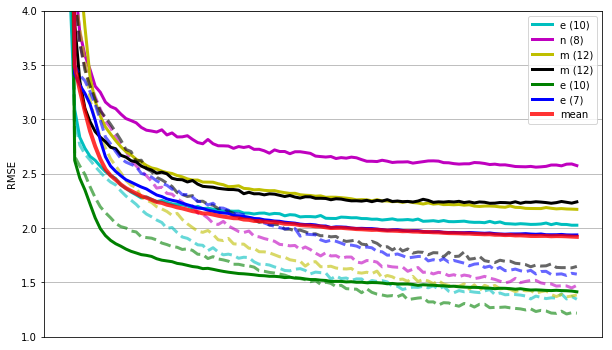

In [35]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
ax.set_color_cycle(['c', 'c', 'm', 'm', 'y', 'y', 'k', 'k', 'g', 'g', 'b', 'b'])

valid_losses = []
train_losses = []

for model_number, (cg, model) in enumerate(models.items(), 1):
    valid_loss = np.array([i['valid_loss'] for i in model.train_history_])
    train_loss = np.array([i['train_loss'] for i in model.train_history_])
    valid_loss = np.sqrt(valid_loss) * 48
    train_loss = np.sqrt(train_loss) * 48
    valid_loss = rebin(valid_loss, (100,))
    train_loss = rebin(train_loss, (100,))
    valid_losses.append(valid_loss)
    train_losses.append(train_loss)
    ax.plot(valid_loss,label='{} ({})'.format(cg[0], len(cg)), linewidth=3)
    ax.plot(train_loss,linestyle='--', linewidth=3, alpha=0.6)
    ax.set_xticks([])

weights = np.array([m.output_num_units for m in models.values()],dtype=float)
weights /= weights.sum()
mean_valid_loss = (np.vstack(valid_losses) * weights.reshape(-1, 1)).sum(axis=0)
ax.plot(mean_valid_loss, color='r', label='mean', linewidth=4, alpha=0.8)
ax.legend()
ax.set_ylim((1.0, 4.0))
ax.grid()
plt.ylabel("RMSE")
plt.show()

In [40]:
mean_valid_loss[99]

1.9193458468468299

### 9.9 Make predictions to submit to Kaggle

In [15]:
fname_specialists='net-specialists.pickle'
with open(fname_specialists, 'rb') as f:
    specialists = pickle.load(f)

In [36]:
X = load2d(use='test')[0]
y_pred = np.empty((X.shape[0], 30))

for model in specialists.values():
    y_pred1 = model.predict(X)
    y_pred = np.vstack([y_pred, y_pred1]) # changed from hstack to vstack to force it to run but don't think this is really working
    
columns = ()
for cols in specialists.keys():
    columns += cols
    
y_pred2 = y_pred * 48 + 48
y_pred2 = y_pred2.clip(0, 96)

df = DataFrame(y_pred2, columns=columns)

lookup_table = read_csv(os.path.expanduser(FLOOKUP))
values = []

for index, row in lookup_table.iterrows():
    values.append((row['RowId'],df.ix[row.ImageId - 1][row.FeatureName],))

now_str = datetime.now().isoformat().replace(':', '-')
submission = DataFrame(values, columns=('RowId', 'Location'))
filename = 'submission-{}.csv'.format(now_str)
submission.to_csv(filename, index=False)
print("Wrote {}".format(filename))

UnboundLocalError: local variable 'load_idx' referenced before assignment

# END OF TUTORIAL CODE


### 10. Study In-sample Training and Validation Loss

Note that this "Training" and "Validation" data came from our 1940 training examples only. The Neural Net call automatically split 0.1 of these 1940 examples internally for its validation set. This has nothing to do with our development set, which is necessary for us to later compare with other models such as SVM or Logistic Regression.

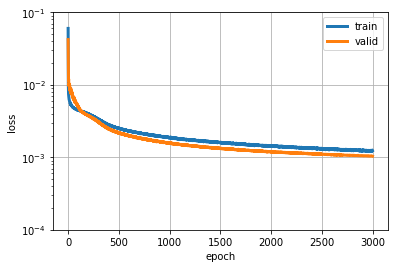

In [96]:
# object net12 keeps training history for each epoch
# we can access this record
train_loss = np.array([i["train_loss"] for i in net_pretrain.train_history_])
valid_loss = np.array([i["valid_loss"] for i in net_pretrain.train_history_])
plt.plot(train_loss, linewidth=3, label="train")
plt.plot(valid_loss, linewidth=3, label="valid")
plt.grid()
plt.legend()
plt.xlabel("epoch")
plt.ylabel("loss")
plt.ylim(1e-4,1e-1)
plt.yscale("log")
plt.show()

In [19]:
# Our validation error is 0.003255 here
# we need to convert this back 
np.sqrt(0.00079)*48
# now it returns a proxy value for the Kaggle board score

1.3491330549652989

### 11. Plot in-sample predictions : training set
how well does the model fit to training examples fed into it?

/usr/local/lib/python3.5/dist-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


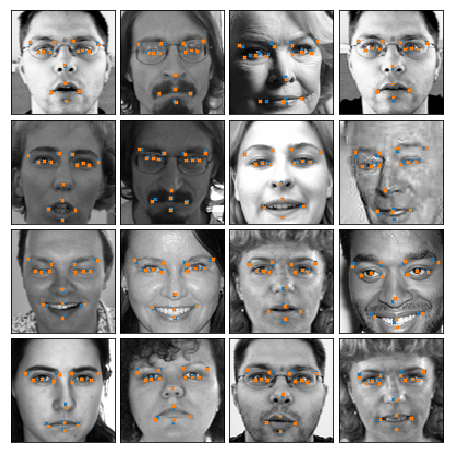

In [17]:
# load test set and predict
y_train_pred = net12.predict(X_train_incomplete)

fig = plt.figure(figsize=(6,6))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

# predicted by model
for i in range(16):
    ax = fig.add_subplot(4, 4, i+1, xticks=[], yticks=[])
    plot_sample(X_train_incomplete[i], y_train_pred[i], ax)

# training labels
for i in range(16):
    ax = fig.add_subplot(4, 4, i+1, xticks=[], yticks=[])
    plot_sample(X_train_incomplete[i], y_train[i], ax)    

plt.show()

# cyan--our model prediction on training examples
# orange--real keypoints on training examples

### 12. Plot out-of-sample predictions : development set
how well does the model perform on the development set?

/usr/local/lib/python3.5/dist-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


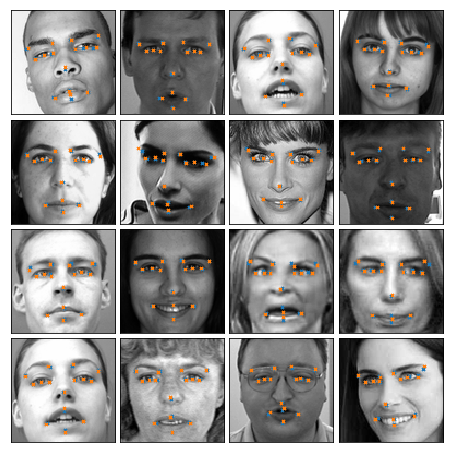

In [18]:
# load test set and predict
#X, _ = load(test=True)
y_dev_pred = net12.predict(X_dev)

fig = plt.figure(figsize=(6,6))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

for i in range(16):
    ax = fig.add_subplot(4, 4, i+1, xticks=[], yticks=[])
    plot_sample(X_dev[i], y_dev_pred[i], ax)

for i in range(16):
    ax = fig.add_subplot(4, 4, i+1, xticks=[], yticks=[])
    plot_sample(X_dev[i], y_dev[i], ax)
    
plt.show()

# cyan--our model prediction on development examples
# orange--real keypoints on development examples

### 12.5 Out-of-sample MSE: Development Set

In [19]:
mean_squared_error(y_dev, y_dev_pred)

0.00086455792

In [20]:
np.sqrt(mean_squared_error(y_dev, y_dev_pred))*48

1.4113615751266479

### 13. How will it look on the test set?
Note that we have no labels available, this is just a preview of how the model will perform on test set

ImageId    1783
Image      1783
dtype: int64


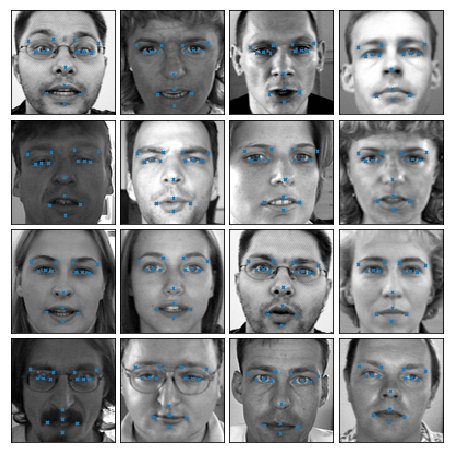

In [21]:
# load test set and predict
X_test, _ = load2d(use='test')
y_test_pred = net12.predict(X_test)

fig = plt.figure(figsize=(6,6))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

for i in range(16):
    ax = fig.add_subplot(4, 4, i+1, xticks=[], yticks=[])
    plot_sample(X_test[i], y_test_pred[i], ax)
    
plt.show()